In [1]:
from plots import *

def grid_size(m, T, factor=1):
    df = 2 * np.sqrt(3*m) / np.pi / T
    df1 = 12 * np.sqrt(5*m) / np.pi / T**2
    df2 = 20 * np.sqrt(7*m) / np.pi / T**3
    return [df*factor, df1*factor, df2*factor]

# Set matplotlib parameters
mplparams = {
    'text.usetex': False,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 1
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'DejaVu Sans',
    'font.size': 20  # Reduced from 22 to prevent overlap
}
matplotlib.rcParams.update(mplparams)
plt.rcParams["mathtext.fontset"] = "cm"

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
homedir = '/home/hoitim.cheung/glitch/'

m = 0.2 
tcoh = 86400*5
factor = 4
dx = grid_size(m, tcoh, factor)

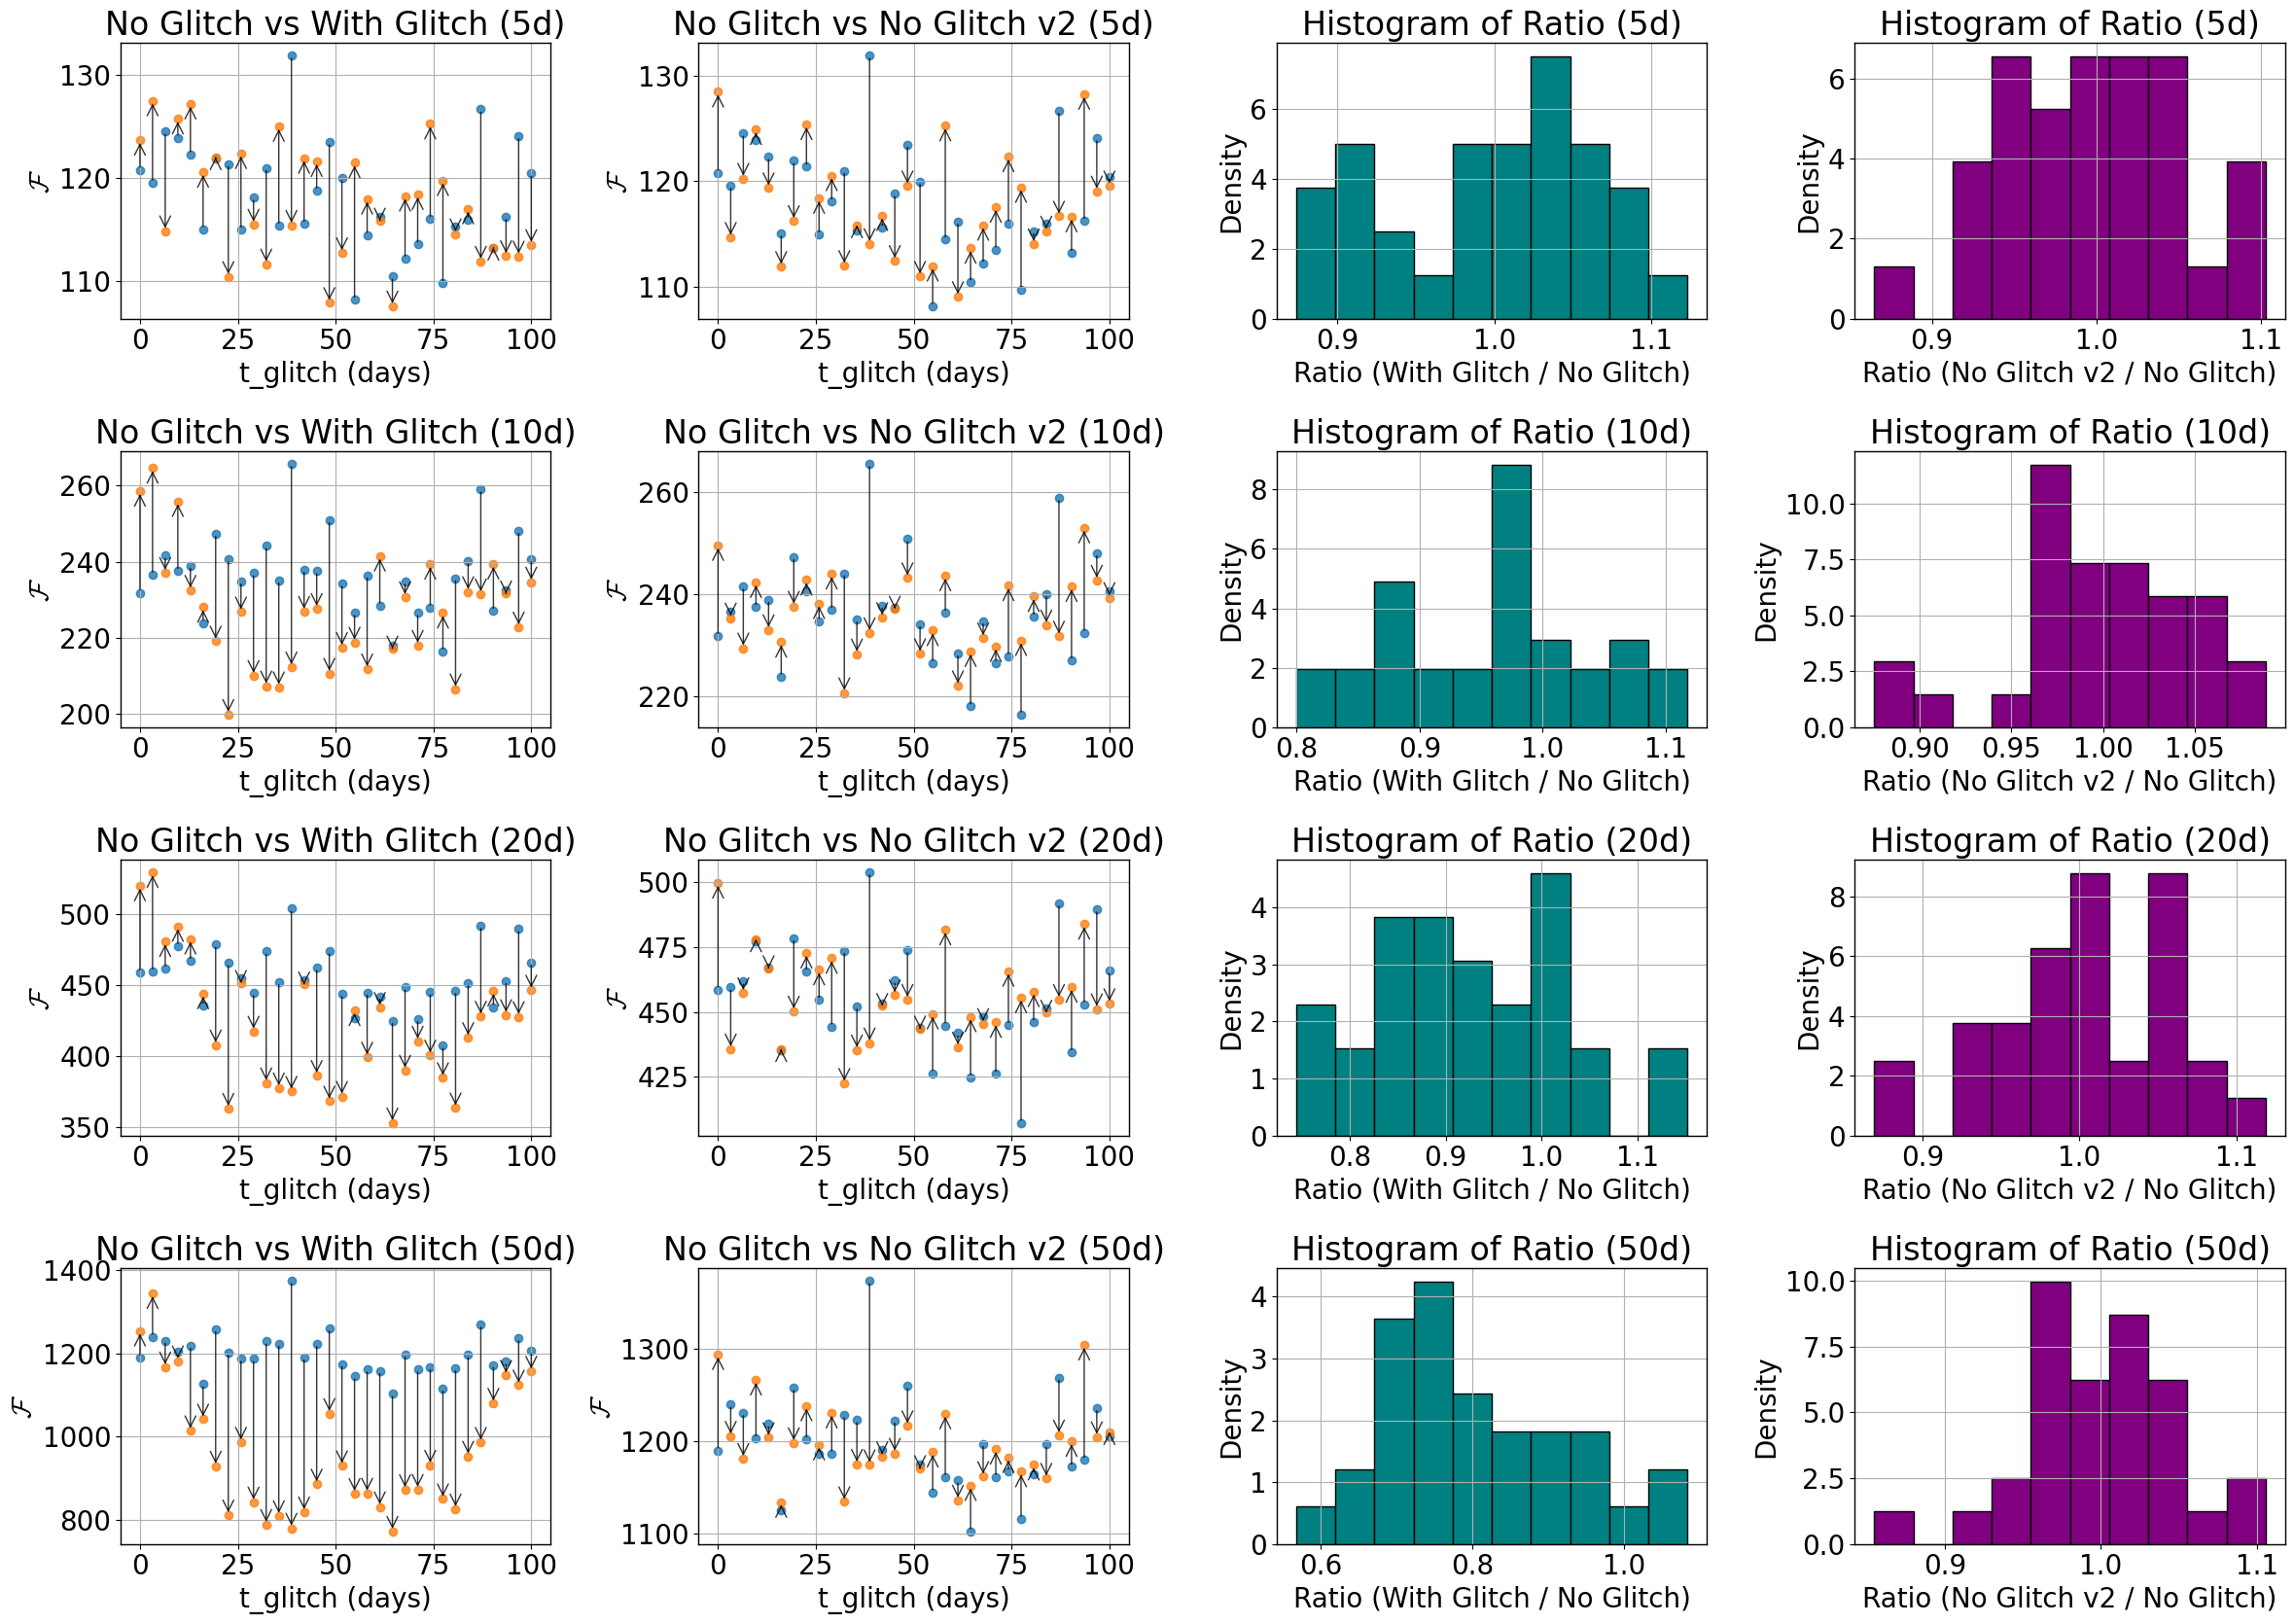

In [4]:
labels = ['no_glitch', 'with_glitch_onlytglitch', 'no_glitch_diffnoise']
plot_labels = ['No Glitch', 'With Glitch', 'No Glitch v2']
plot_glitch_analysis(labels, plot_labels)

# No/With Glitch, Noise/Noise

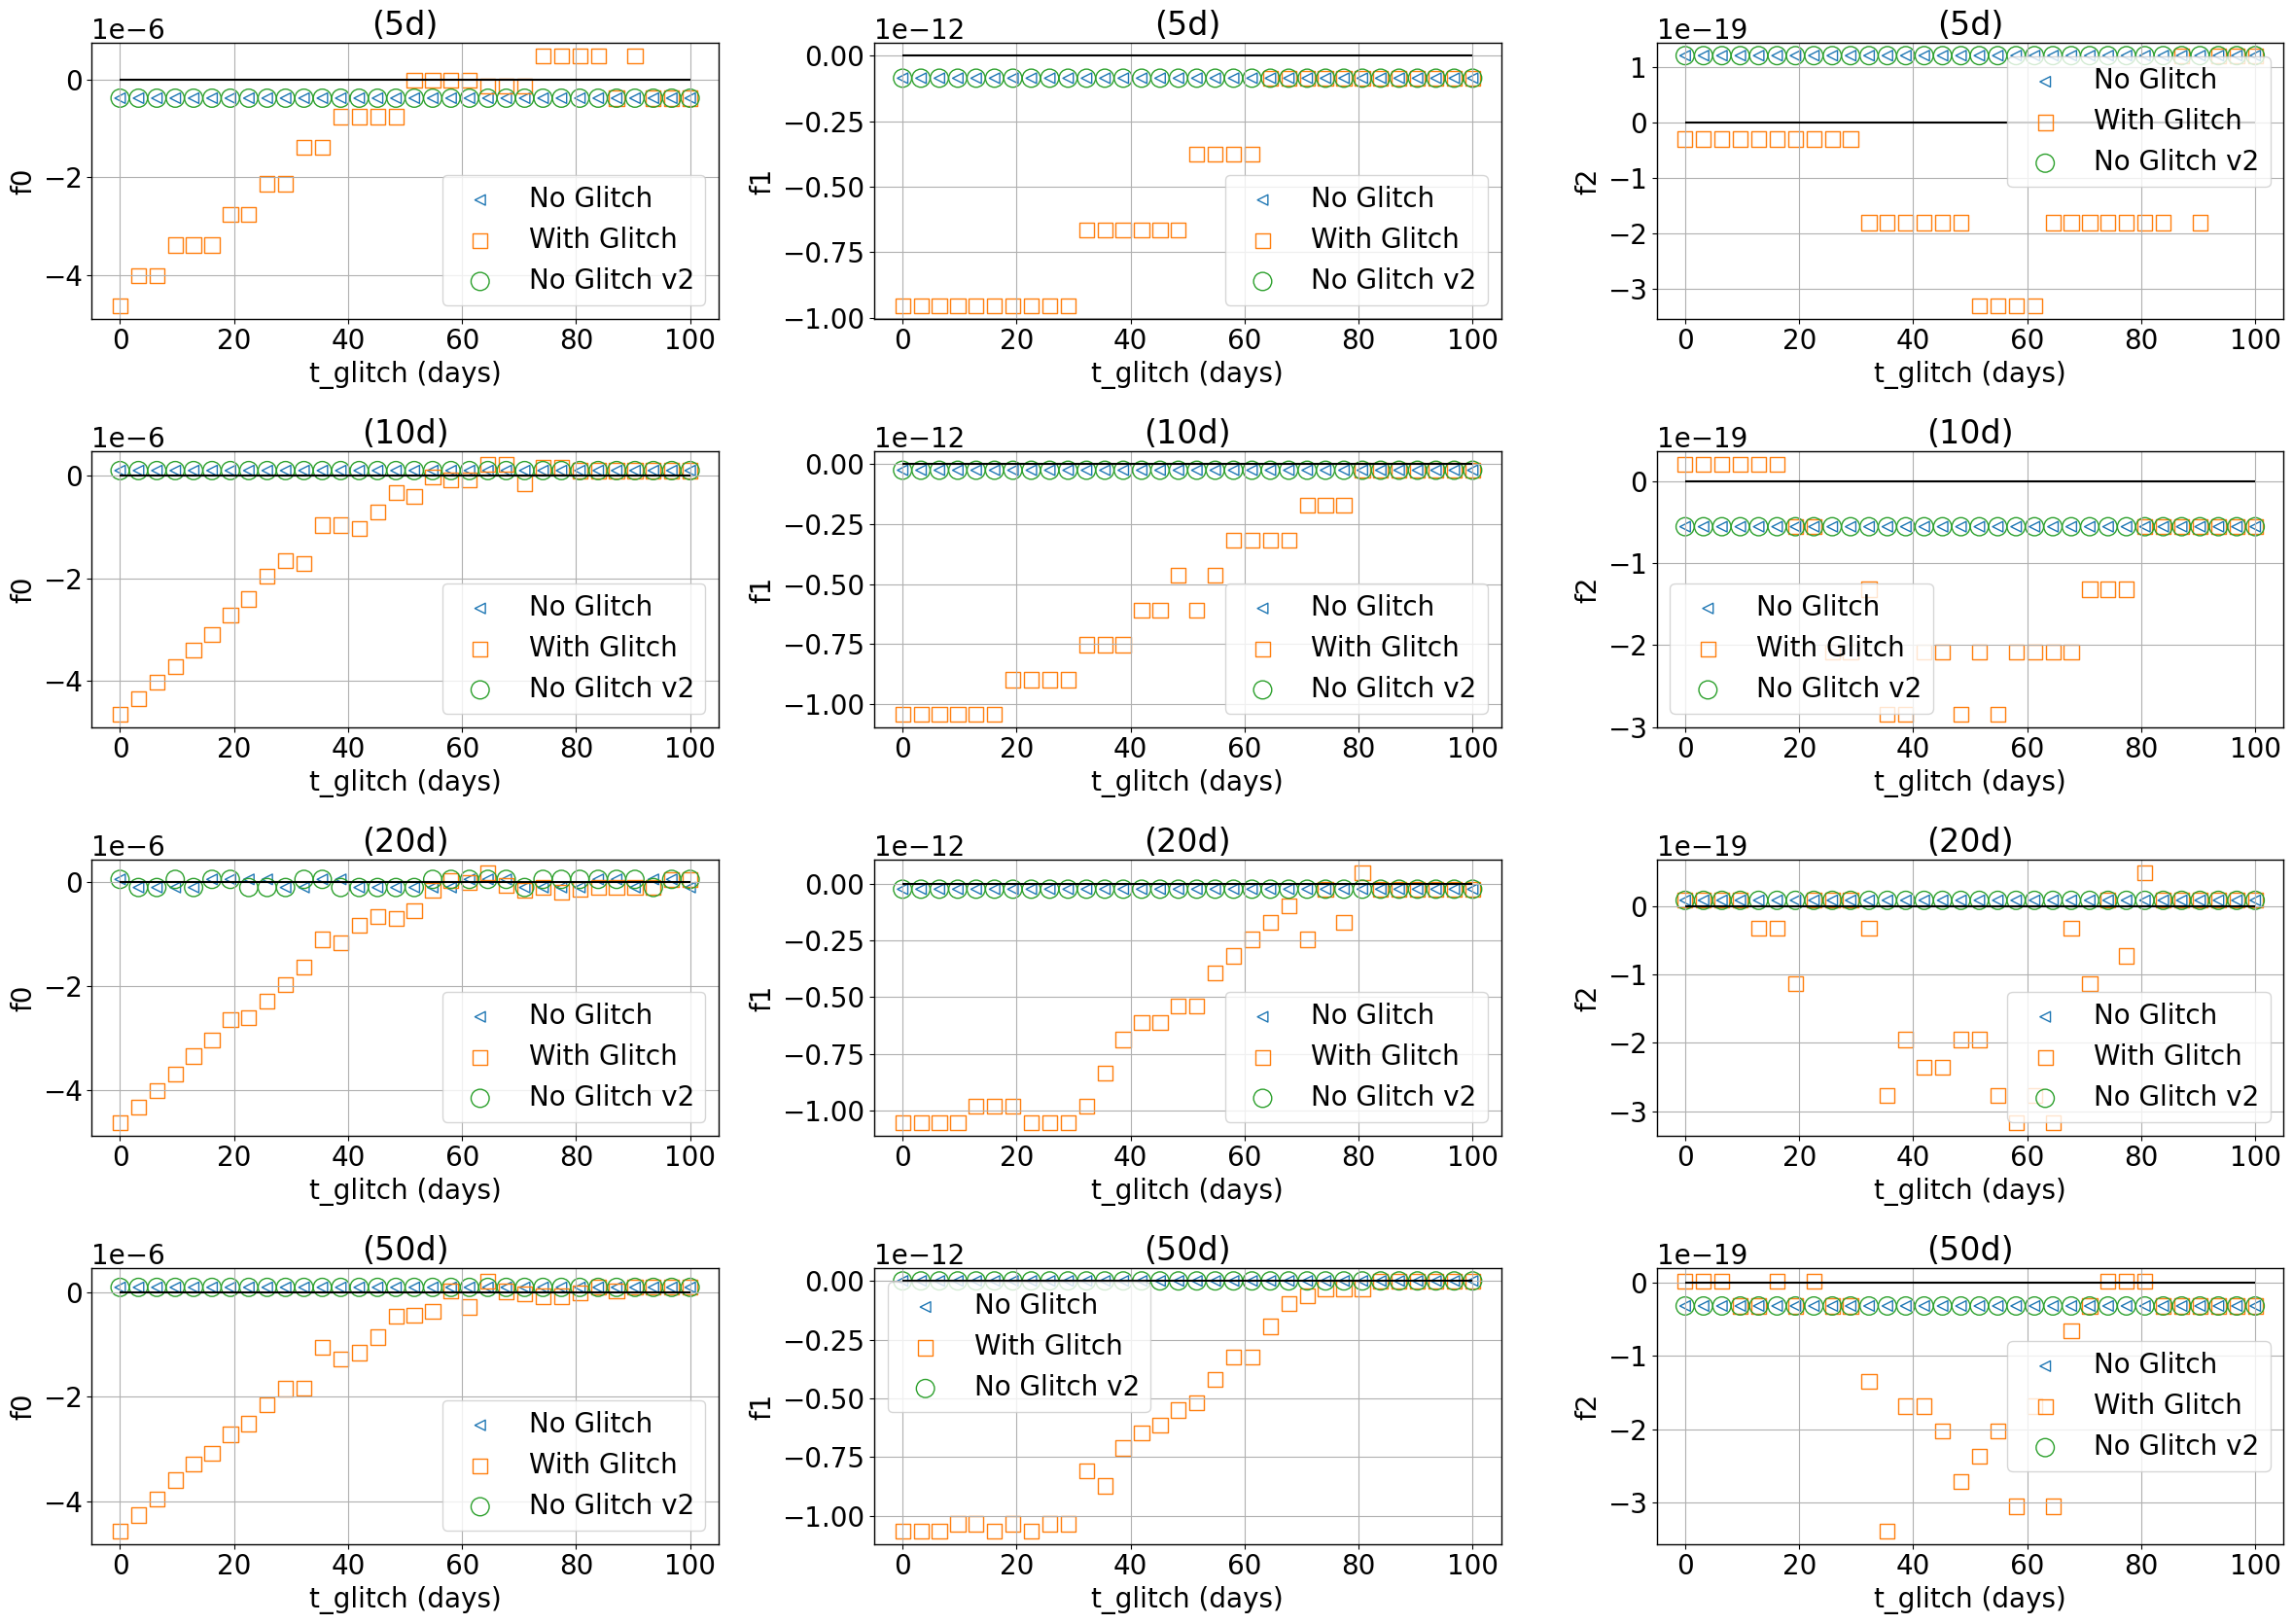

In [5]:
plot_bias(
    labels=['no_glitch', 'with_glitch_onlytglitch', 'no_glitch_diffnoise'],
    plot_labels=['No Glitch', 'With Glitch', 'No Glitch v2']
)

In [12]:
def plot_glitch_ratio_analysis(labels, plot_labels, durations=['5d', '10d', '20d'], n_glitch=1):
    """
    Create a 4x4 subplot grid comparing glitch analysis results with ratios.
    
    Parameters:
    -----------
    labels : list
        List of path components for data files ['no_glitch', 'with_glitch', ...]
    plot_labels : list
        List of labels for plots ['No Glitch', 'With Glitch', ...]
    durations : list
        List of duration strings (default: ['5d', '10d', '20d', '50d'])
    n_glitch : int
        Number of glitches per signal (default: 1)
    """
    
    # Load parameter data
    df = pd.read_csv(f'./data/{labels[1]}_v3/100-100Hz/signal_glitch_params.csv')

    # Extract parameters
    f0 = df['f0'][::n_glitch].values
    f1 = df['f1'][::n_glitch].values
    f2 = df['f2'][::n_glitch].values
    df_p = df['df_p'].values
    df_t = df['df_t'].values
    df1_p = df['df1_p'].values
    q = df['Q'].values
    t_glitch = df['tglitch_day'].values

    # Initialize previous arrays
    prev_a = np.ones(32)  # No Glitch
    prev_b = np.ones(32)  # With Glitch

    # Initialize figure with 4x4 subplots
    fig, ax = plt.subplots(3, 4, figsize=(24, 18))

    # Loop over durations
    for idx, duration in enumerate(durations):
        # Initialize arrays
        a = np.zeros(32)  # No Glitch
        b = np.zeros(32)  # With Glitch
        f0_list = np.zeros((32, 2))
        f1_list = np.zeros((32, 2))
        f2_list = np.zeros((32, 2))

        # Load data
        for i in range(32):
            d1 = fits.open(f'./results/{duration}/{labels[0]}_v2/100-100Hz/{labels[0]}_v2_CW{i}.fts')
            d2 = fits.open(f'./results/{duration}/{labels[1]}_v3/100-100Hz/{labels[1]}_v3_CW{i}.fts')
            
            a[i] = d1[1].data['mean2F'][0]
            b[i] = d2[1].data['mean2F'][0]

            f0_list[i, 0] = d1[1].data['freq'][0]
            f1_list[i, 0] = d1[1].data['f1dot'][0]
            f2_list[i, 0] = d1[1].data['f2dot'][0]

            f0_list[i, 1] = d2[1].data['freq'][0]
            f1_list[i, 1] = d2[1].data['f1dot'][0]
            f2_list[i, 1] = d2[1].data['f2dot'][0]

        # Scatter plot: No Glitch vs With Glitch
        ax[idx, 0].scatter(t_glitch, a, label=plot_labels[0], alpha=0.8)
        ax[idx, 0].scatter(t_glitch, b, label=plot_labels[1], alpha=0.8)
        ax[idx, 0].set_xlabel('t_glitch (days)')
        ax[idx, 0].set_ylabel(r'$\mathcal{F}$')
        ax[idx, 0].grid(True)
        ax[idx, 0].set_title(f'{plot_labels[0]} vs {plot_labels[1]} ({duration})')
        
        for i in range(len(t_glitch)):
            ax[idx, 0].annotate('', xy=(t_glitch[i], b[i]), xytext=(t_glitch[i], a[i]), 
                               arrowprops=dict(arrowstyle='->', color='k', alpha=0.8))
        
        # Scatter plot: Ratio (No Glitch vs With Glitch)
        ax[idx, 1].scatter(t_glitch, a/a, label=plot_labels[0], alpha=0.8)
        ax[idx, 1].scatter(t_glitch, b/a, label=plot_labels[1], alpha=0.8)
        ax[idx, 1].set_xlabel('t_glitch (days)')
        ax[idx, 1].set_ylabel(r'$\mathcal{F}$')
        ax[idx, 1].grid(True)
        ax[idx, 1].set_title(f'Ratio ({duration})')
        
        for i in range(len(t_glitch)):
            ax[idx, 1].annotate('', xy=(t_glitch[i], b[i]/a[i]), xytext=(t_glitch[i], a[i]/a[i]), 
                               arrowprops=dict(arrowstyle='->', color='k', alpha=0.8))

        if idx != 0:
            # Histogram: Ratio Increase (No Glitch)
            ratios = a / prev_a
            ax[idx, 2].hist(ratios, bins=10, color='teal', edgecolor='black', density=True)
            ax[idx, 2].set_xlabel(f'Ratio Increase ({plot_labels[0]})')
            ax[idx, 2].set_ylabel('Density')
            ax[idx, 2].grid(True)
            ax[idx, 2].set_title(f'Histogram of Ratio ({duration})')
            
            # Histogram: Ratio Increase (With Glitch)
            ratios = b / prev_b
            ax[idx, 3].hist(ratios, bins=10, color='purple', edgecolor='black', density=True)
            ax[idx, 3].set_xlabel(f'Ratio Increase ({plot_labels[1]})')
            ax[idx, 3].set_ylabel('Density')
            ax[idx, 3].grid(True)
            ax[idx, 3].set_title(f'Histogram of Ratio ({duration})')

        prev_a, prev_b = a, b

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_bias_ab(labels, plot_labels, durations=['5d', '10d', '20d'], n_glitch=1, markers=['<', 's', 'o']):
    """
    Create a 4x3 subplot grid comparing frequency parameters for glitch analysis.
    
    Parameters:
    -----------
    labels : list
        List of path components for data files ['no_glitch', 'with_glitch', 'no_glitch_diffnoise']
    plot_labels : list
        List of labels for plots ['No Glitch', 'With Glitch', 'No Glitch Noise']
    durations : list
        List of duration strings (default: ['5d', '10d', '20d', '50d'])
    n_glitch : int
        Number of glitches per signal (default: 1)
    markers : list
        List of markers for scatter plots (default: ['o', '<', '>'])
    colors : list
        List of colors for scatter plots (default: ['blue', 'red', 'green'])
    """
    
    # Load parameter data
    df = pd.read_csv(f'./data/{labels[1]}_v3/100-100Hz/signal_glitch_params.csv')

    # Extract parameters
    f0 = df['f0'][::n_glitch].values
    f1 = df['f1'][::n_glitch].values
    f2 = df['f2'][::n_glitch].values
    df_p = df['df_p'].values
    df_t = df['df_t'].values
    df1_p = df['df1_p'].values
    q = df['Q'].values
    t_glitch = df['tglitch_day'].values

    # Initialize figure with 4x3 subplots
    fig, ax = plt.subplots(3, 3, figsize=(22, 18))
    # Loop over durations
    for idx, duration in enumerate(durations):
        # Initialize arrays
        f0_list = np.zeros((32, 2))
        f1_list = np.zeros((32, 2))
        f2_list = np.zeros((32, 2))

        # Load data
        for i in range(32):
            d1 = fits.open(f'./results/{duration}/{labels[0]}_v2/100-100Hz/{labels[0]}_v2_CW{i}.fts')
            d2 = fits.open(f'./results/{duration}/{labels[1]}_v3/100-100Hz/{labels[1]}_v3_CW{i}.fts')

            f0_list[i, 0] = d1[1].data['freq'][0]
            f1_list[i, 0] = d1[1].data['f1dot'][0]
            f2_list[i, 0] = d1[1].data['f2dot'][0]

            f0_list[i, 1] = d2[1].data['freq'][0]
            f1_list[i, 1] = d2[1].data['f1dot'][0]
            f2_list[i, 1] = d2[1].data['f2dot'][0]

        # Data and truth arrays for plotting
        data = [f0_list, f1_list, f2_list]
        truth = [f0, f1, f2]

        # Plot for each frequency parameter (f0, f1, f2)
        for plot_i in range(3):
            for j in range(2):
                # Scatter plot: Difference from truth
                ax[idx, plot_i].scatter(t_glitch, (data[plot_i][:, j] - truth[plot_i]), 
                                       color=colors[j], label=plot_labels[j], 
                                       marker=markers[j], facecolors='none', s=30*2*((j+1)))
            ax[idx, plot_i].hlines([0], 0, 100, color="k")
            ax[idx, plot_i].set_xlabel('t_glitch (days)')
            ax[idx, plot_i].set_ylabel(f'f{plot_i}')
            ax[idx, plot_i].legend()
            ax[idx, plot_i].grid(True)
            ax[idx, plot_i].set_title(f'({duration})')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

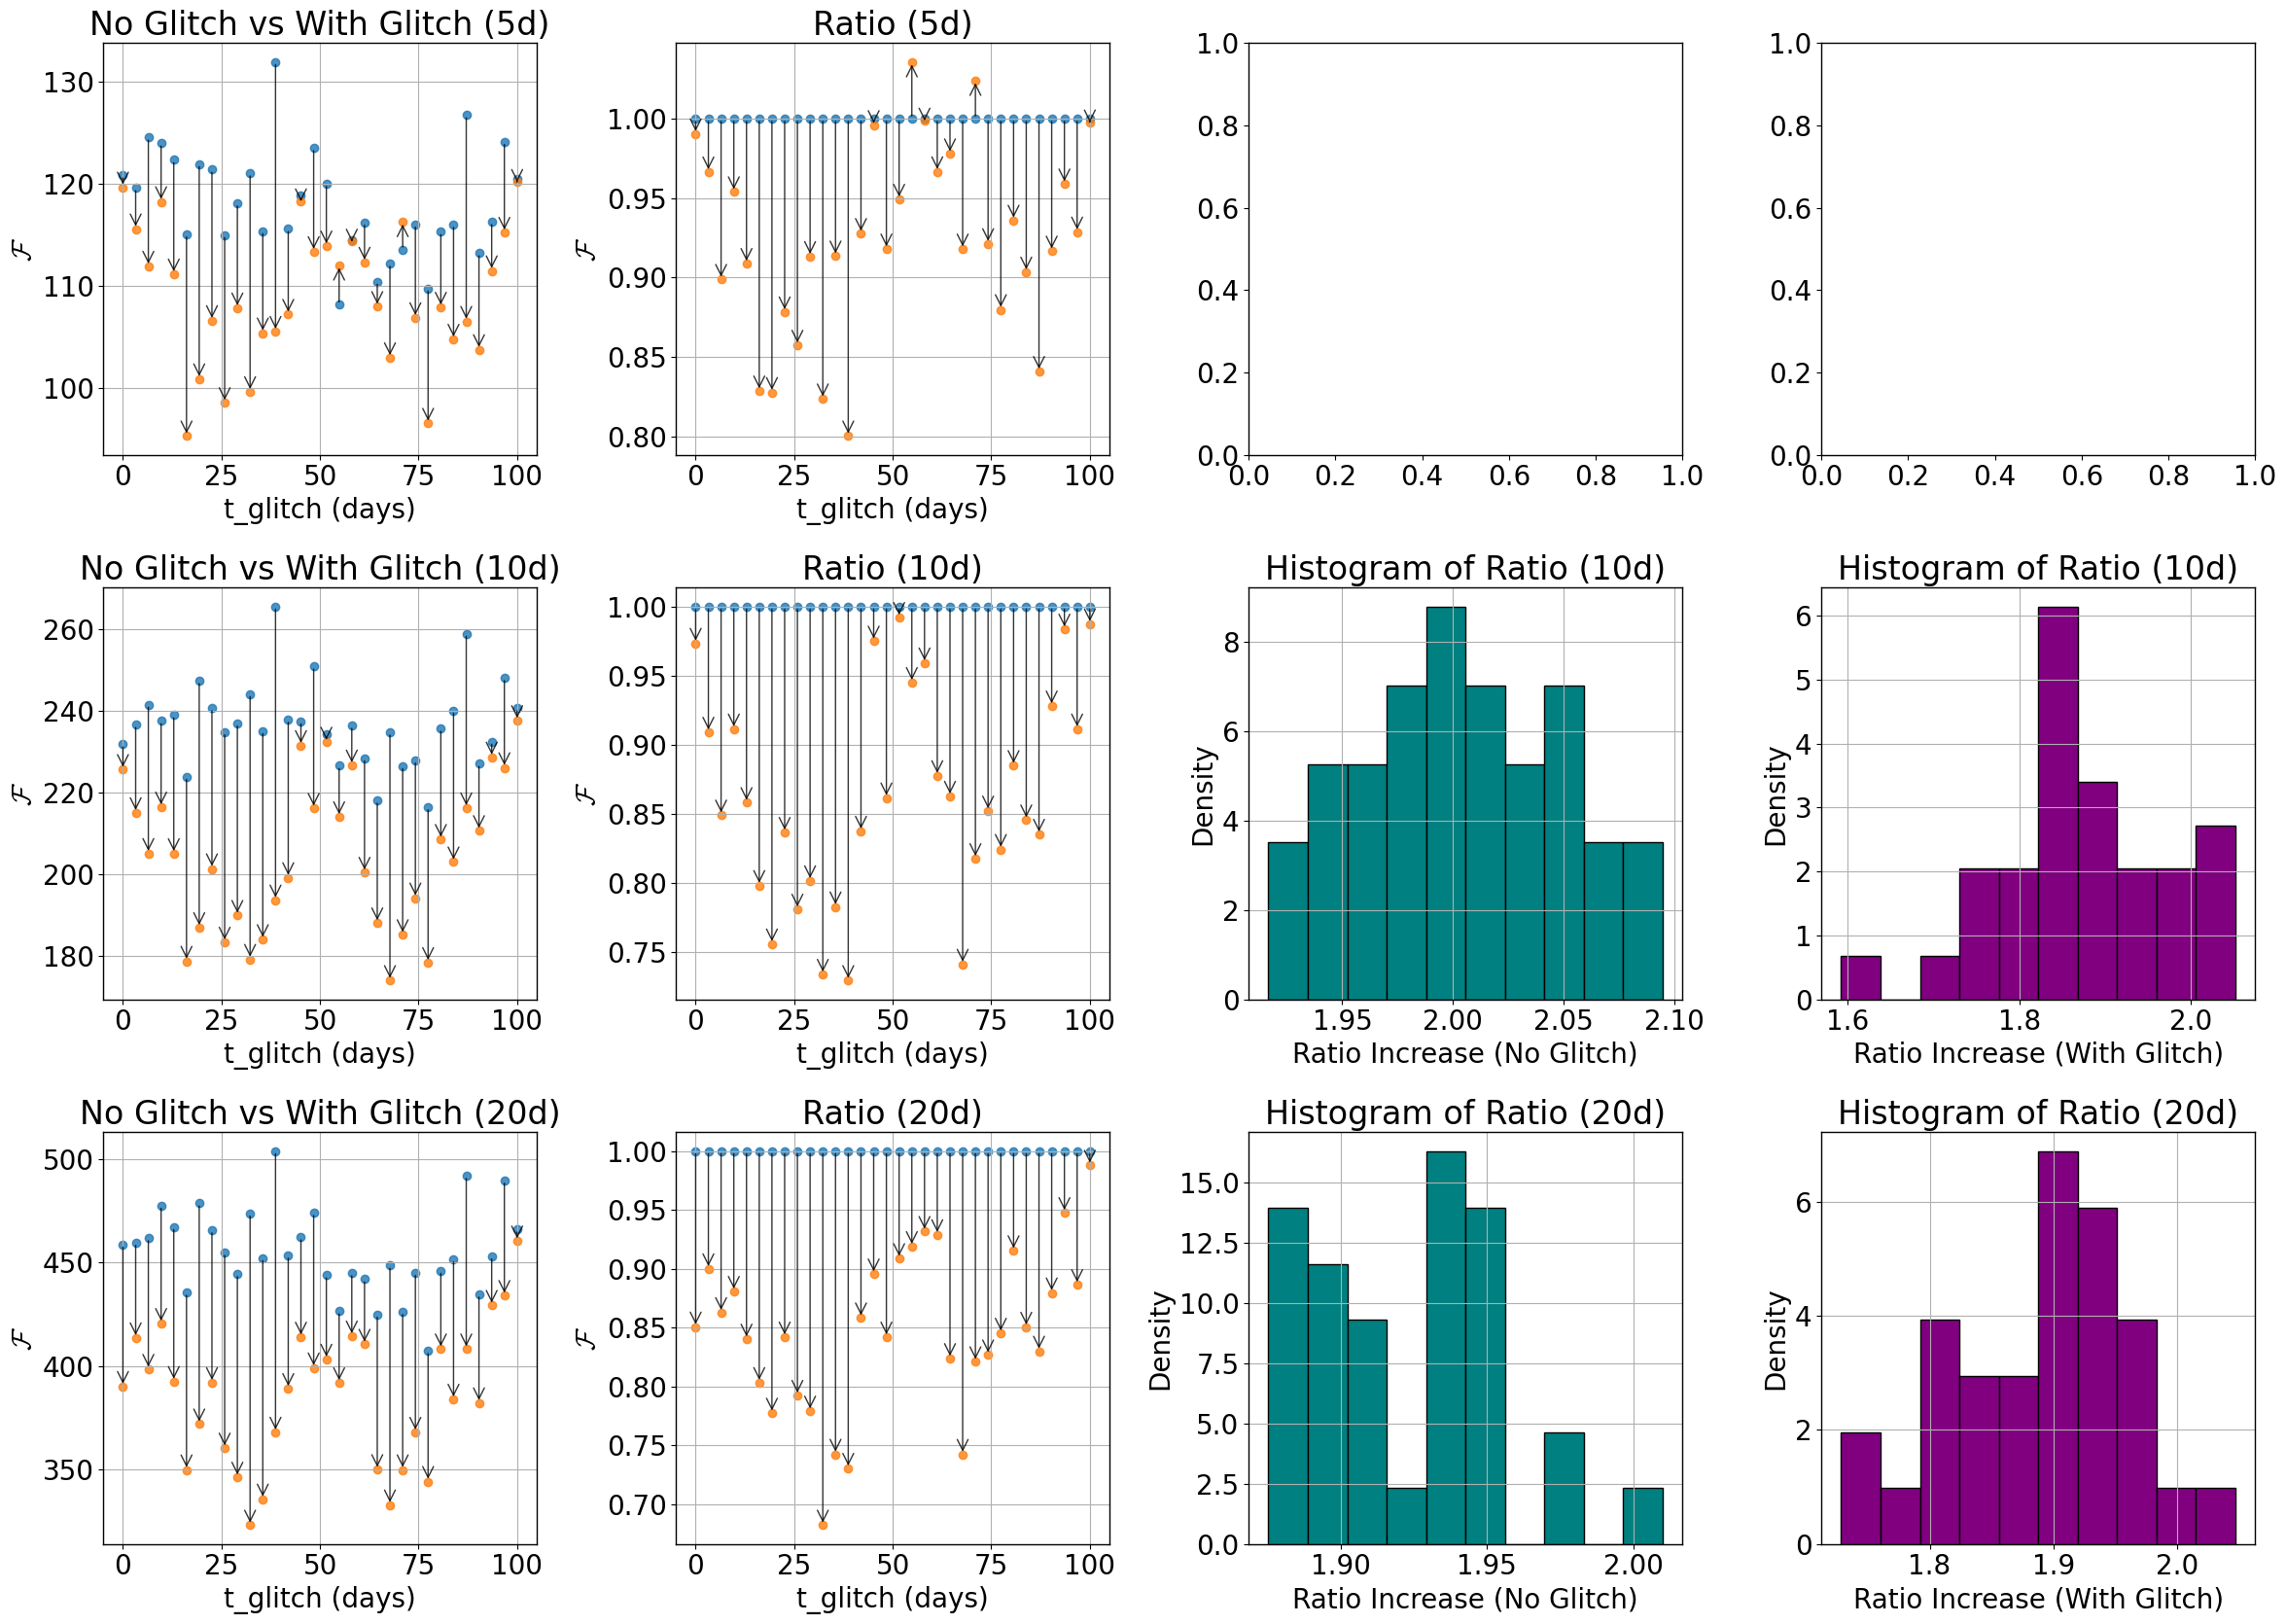

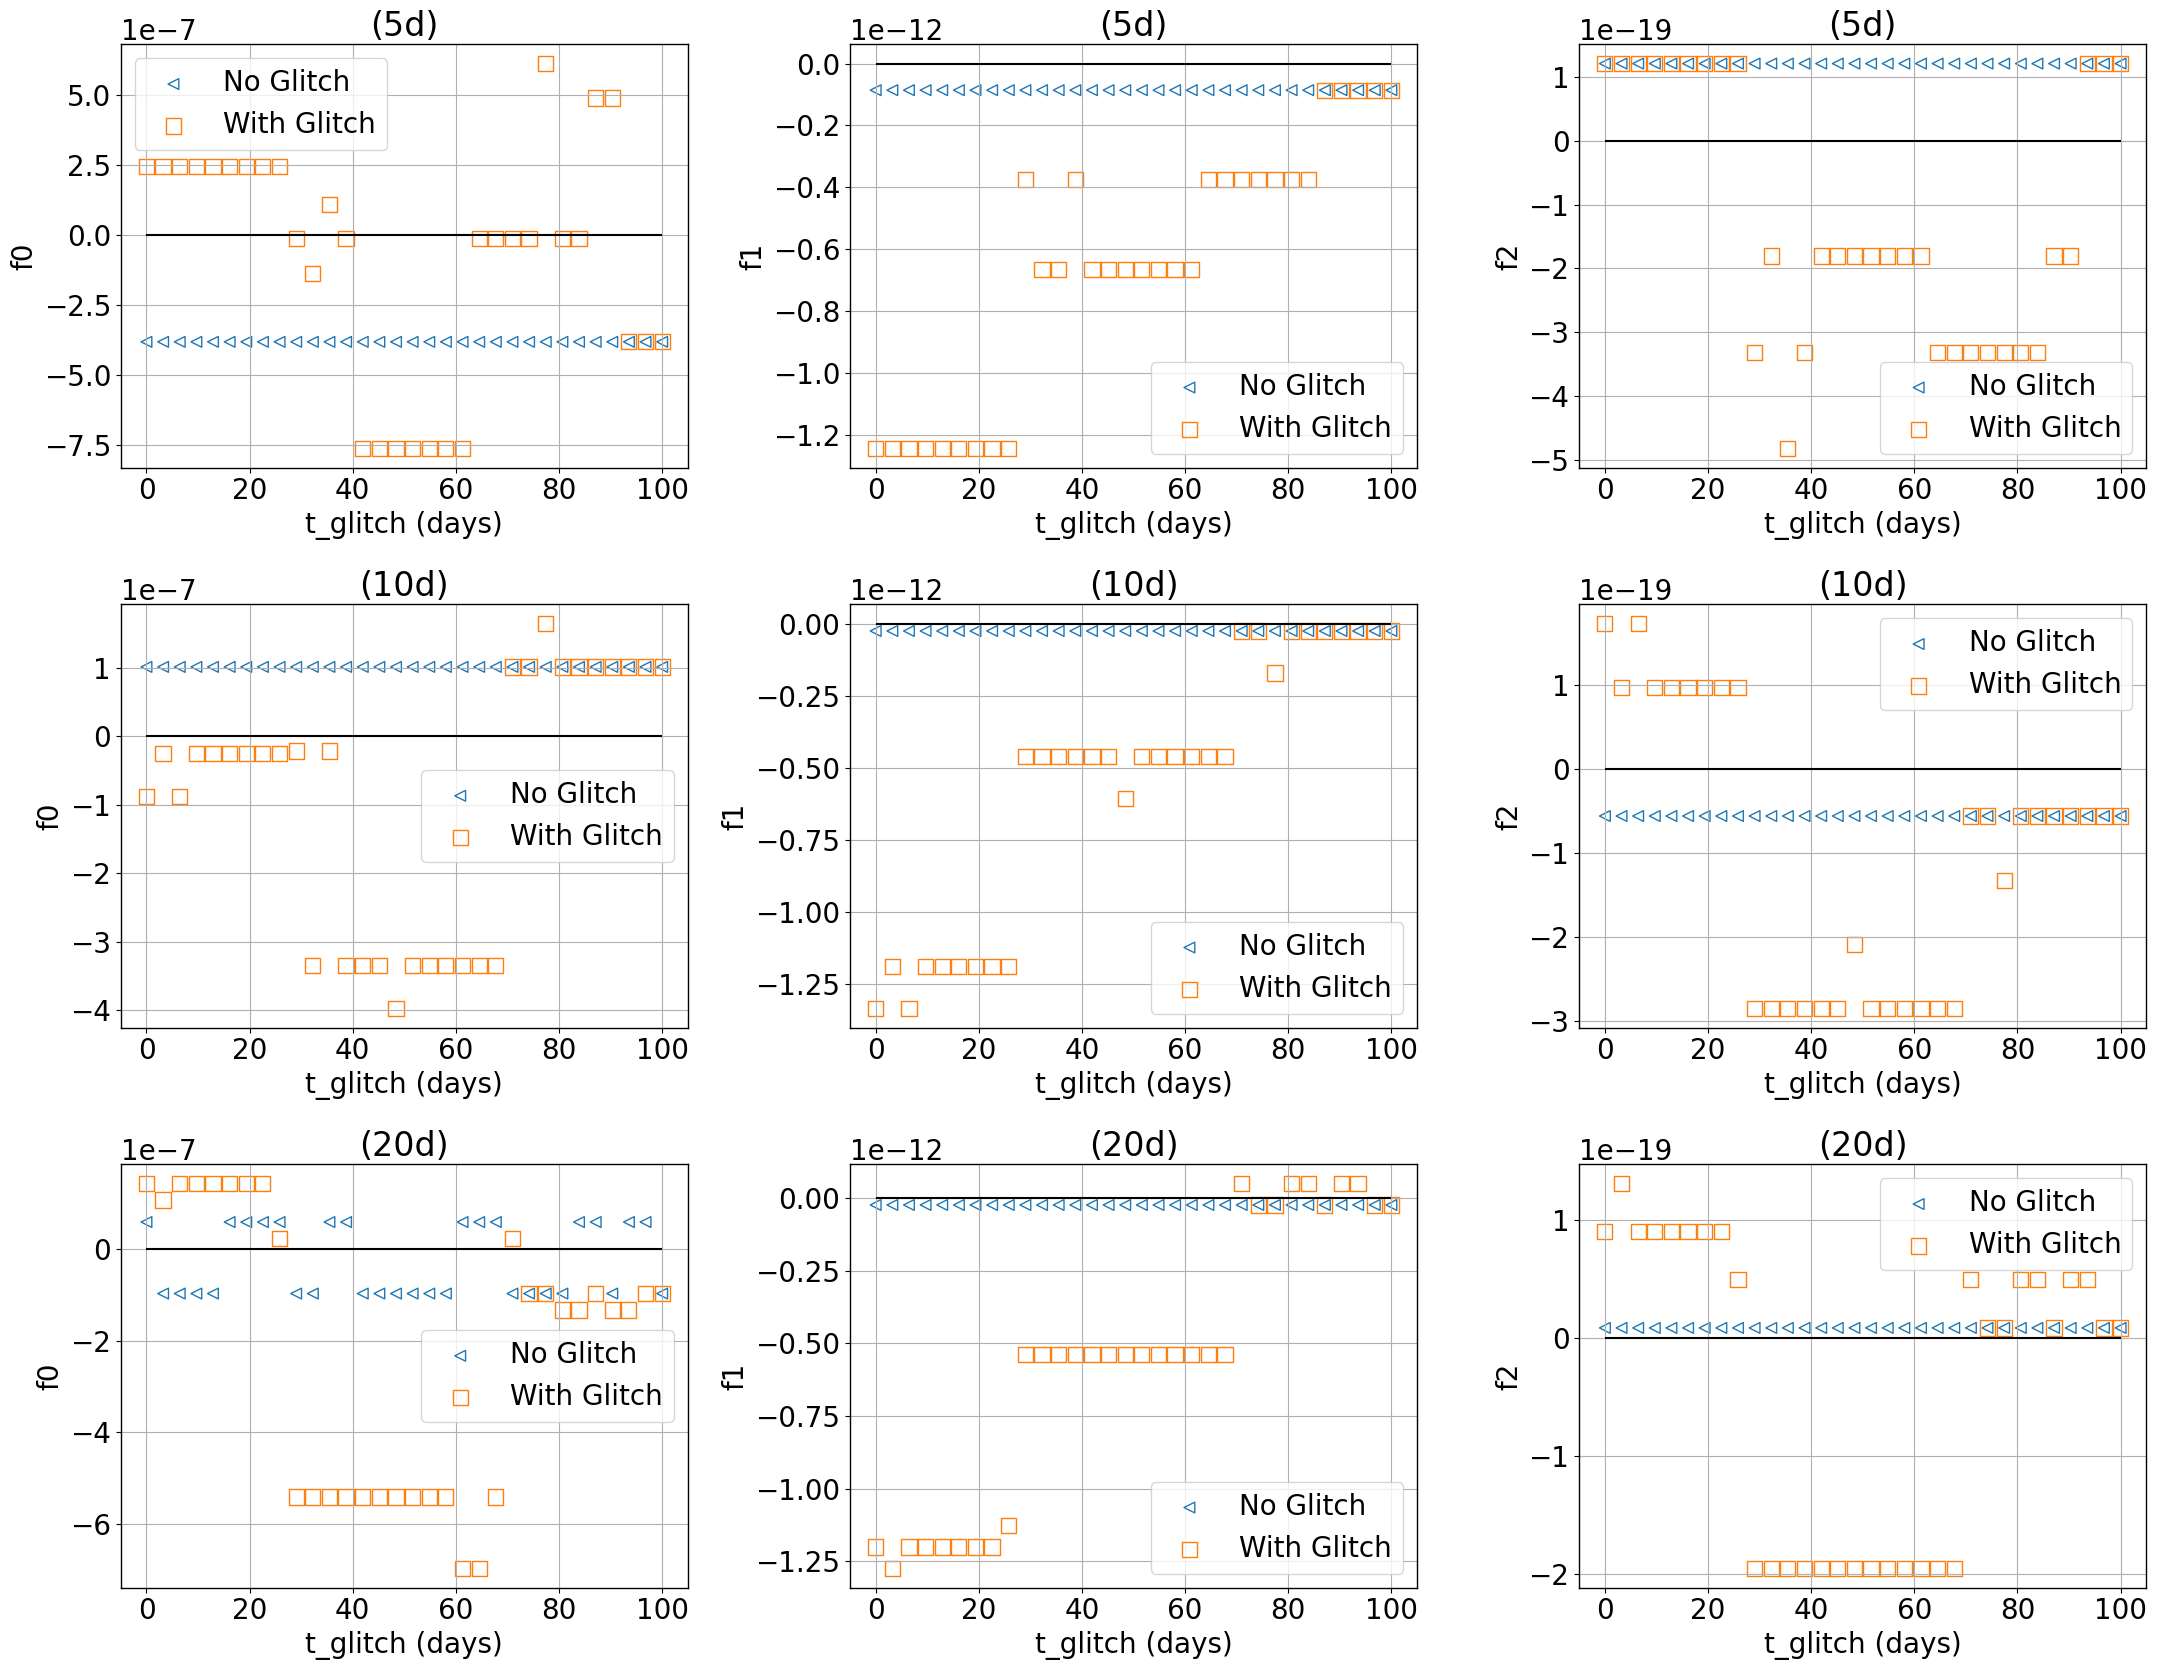

In [13]:
labels = ['no_glitch', 'with_glitch_onlytglitch']
plot_labels = ['No Glitch', 'With Glitch']
plot_glitch_ratio_analysis(labels, plot_labels, durations=['5d', '10d', '20d'])

plot_bias_ab(
    labels=['no_glitch', 'with_glitch_onlytglitch'],
    plot_labels=['No Glitch', 'With Glitch'],
    durations=['5d', '10d', '20d']
)



In [14]:
def plot_glitch_ratio_analysis(labels, plot_labels, durations=['5d', '10d', '20d'], n_glitch=1):
    """
    Create a 4x4 subplot grid comparing glitch analysis results with ratios.
    
    Parameters:
    -----------
    labels : list
        List of path components for data files ['no_glitch', 'with_glitch', ...]
    plot_labels : list
        List of labels for plots ['No Glitch', 'With Glitch', ...]
    durations : list
        List of duration strings (default: ['5d', '10d', '20d', '50d'])
    n_glitch : int
        Number of glitches per signal (default: 1)
    """
    
    # Load parameter data
    df = pd.read_csv(f'./data/{labels[1]}_v3/100-100Hz/signal_glitch_params.csv')

    # Extract parameters
    f0 = df['f0'][::n_glitch].values
    f1 = df['f1'][::n_glitch].values
    f2 = df['f2'][::n_glitch].values
    df_p = df['df_p'].values
    df_t = df['df_t'].values
    df1_p = df['df1_p'].values
    q = df['Q'].values
    t_glitch = df['tglitch_day'].values

    # Initialize previous arrays
    prev_a = np.ones(32)  # No Glitch
    prev_b = np.ones(32)  # With Glitch

    # Initialize figure with 4x4 subplots
    fig, ax = plt.subplots(3, 4, figsize=(24, 18))

    # Loop over durations
    for idx, duration in enumerate(durations):
        # Initialize arrays
        a = np.zeros(32)  # No Glitch
        b = np.zeros(32)  # With Glitch
        f0_list = np.zeros((32, 2))
        f1_list = np.zeros((32, 2))
        f2_list = np.zeros((32, 2))

        # Load data
        for i in range(32):
            d1 = fits.open(f'./results/{duration}/{labels[0]}_v2/100-100Hz/{labels[0]}_v2_CW{i}.fts')
            d2 = fits.open(f'./results/{duration}/{labels[1]}_v3/100-100Hz/{labels[1]}_v3_CW{i}_fixf1f2.fts')
            
            a[i] = d1[1].data['mean2F'][0]
            b[i] = d2[1].data['mean2F'][0]

            f0_list[i, 0] = d1[1].data['freq'][0]
            f1_list[i, 0] = d1[1].data['f1dot'][0]
            f2_list[i, 0] = d1[1].data['f2dot'][0]

            f0_list[i, 1] = d2[1].data['freq'][0]
            f1_list[i, 1] = d2[1].data['f1dot'][0]
            f2_list[i, 1] = d2[1].data['f2dot'][0]

        # Scatter plot: No Glitch vs With Glitch
        ax[idx, 0].scatter(t_glitch, a, label=plot_labels[0], alpha=0.8)
        ax[idx, 0].scatter(t_glitch, b, label=plot_labels[1], alpha=0.8)
        ax[idx, 0].set_xlabel('t_glitch (days)')
        ax[idx, 0].set_ylabel(r'$\mathcal{F}$')
        ax[idx, 0].grid(True)
        ax[idx, 0].set_title(f'{plot_labels[0]} vs {plot_labels[1]} ({duration})')
        
        for i in range(len(t_glitch)):
            ax[idx, 0].annotate('', xy=(t_glitch[i], b[i]), xytext=(t_glitch[i], a[i]), 
                               arrowprops=dict(arrowstyle='->', color='k', alpha=0.8))
        
        # Scatter plot: Ratio (No Glitch vs With Glitch)
        ax[idx, 1].scatter(t_glitch, a/a, label=plot_labels[0], alpha=0.8)
        ax[idx, 1].scatter(t_glitch, b/a, label=plot_labels[1], alpha=0.8)
        ax[idx, 1].set_xlabel('t_glitch (days)')
        ax[idx, 1].set_ylabel(r'$\mathcal{F}$')
        ax[idx, 1].grid(True)
        ax[idx, 1].set_title(f'Ratio ({duration})')
        
        for i in range(len(t_glitch)):
            ax[idx, 1].annotate('', xy=(t_glitch[i], b[i]/a[i]), xytext=(t_glitch[i], a[i]/a[i]), 
                               arrowprops=dict(arrowstyle='->', color='k', alpha=0.8))

        if idx != 0:
            # Histogram: Ratio Increase (No Glitch)
            ratios = a / prev_a
            ax[idx, 2].hist(ratios, bins=10, color='teal', edgecolor='black', density=True)
            ax[idx, 2].set_xlabel(f'Ratio Increase ({plot_labels[0]})')
            ax[idx, 2].set_ylabel('Density')
            ax[idx, 2].grid(True)
            ax[idx, 2].set_title(f'Histogram of Ratio ({duration})')
            
            # Histogram: Ratio Increase (With Glitch)
            ratios = b / prev_b
            ax[idx, 3].hist(ratios, bins=10, color='purple', edgecolor='black', density=True)
            ax[idx, 3].set_xlabel(f'Ratio Increase ({plot_labels[1]})')
            ax[idx, 3].set_ylabel('Density')
            ax[idx, 3].grid(True)
            ax[idx, 3].set_title(f'Histogram of Ratio ({duration})')

        prev_a, prev_b = a, b

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_bias_ab(labels, plot_labels, durations=['5d', '10d', '20d'], n_glitch=1, markers=['<', 's', 'o']):
    """
    Create a 4x3 subplot grid comparing frequency parameters for glitch analysis.
    
    Parameters:
    -----------
    labels : list
        List of path components for data files ['no_glitch', 'with_glitch', 'no_glitch_diffnoise']
    plot_labels : list
        List of labels for plots ['No Glitch', 'With Glitch', 'No Glitch Noise']
    durations : list
        List of duration strings (default: ['5d', '10d', '20d', '50d'])
    n_glitch : int
        Number of glitches per signal (default: 1)
    markers : list
        List of markers for scatter plots (default: ['o', '<', '>'])
    colors : list
        List of colors for scatter plots (default: ['blue', 'red', 'green'])
    """
    
    # Load parameter data
    df = pd.read_csv(f'./data/{labels[1]}_v3/100-100Hz/signal_glitch_params.csv')

    # Extract parameters
    f0 = df['f0'][::n_glitch].values
    f1 = df['f1'][::n_glitch].values
    f2 = df['f2'][::n_glitch].values
    df_p = df['df_p'].values
    df_t = df['df_t'].values
    df1_p = df['df1_p'].values
    q = df['Q'].values
    t_glitch = df['tglitch_day'].values

    # Initialize figure with 4x3 subplots
    fig, ax = plt.subplots(3, 3, figsize=(22, 18))
    # Loop over durations
    for idx, duration in enumerate(durations):
        # Initialize arrays
        f0_list = np.zeros((32, 2))
        f1_list = np.zeros((32, 2))
        f2_list = np.zeros((32, 2))

        # Load data
        for i in range(32):
            d1 = fits.open(f'./results/{duration}/{labels[0]}_v2/100-100Hz/{labels[0]}_v2_CW{i}.fts')
            d2 = fits.open(f'./results/{duration}/{labels[1]}_v3/100-100Hz/{labels[1]}_v3_CW{i}_fixf1f2.fts')

            f0_list[i, 0] = d1[1].data['freq'][0]
            f1_list[i, 0] = d1[1].data['f1dot'][0]
            f2_list[i, 0] = d1[1].data['f2dot'][0]

            f0_list[i, 1] = d2[1].data['freq'][0]
            f1_list[i, 1] = d2[1].data['f1dot'][0]
            f2_list[i, 1] = d2[1].data['f2dot'][0]

        # Data and truth arrays for plotting
        data = [f0_list, f1_list, f2_list]
        truth = [f0, f1, f2]

        # Plot for each frequency parameter (f0, f1, f2)
        for plot_i in range(3):
            for j in range(2):
                # Scatter plot: Difference from truth
                ax[idx, plot_i].scatter(t_glitch, (data[plot_i][:, j] - truth[plot_i]), 
                                       color=colors[j], label=plot_labels[j], 
                                       marker=markers[j], facecolors='none', s=30*2*((j+1)))
            ax[idx, plot_i].hlines([0], 0, 100, color="k")
            ax[idx, plot_i].set_xlabel('t_glitch (days)')
            ax[idx, plot_i].set_ylabel(f'f{plot_i}')
            ax[idx, plot_i].legend()
            ax[idx, plot_i].grid(True)
            ax[idx, plot_i].set_title(f'({duration})')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

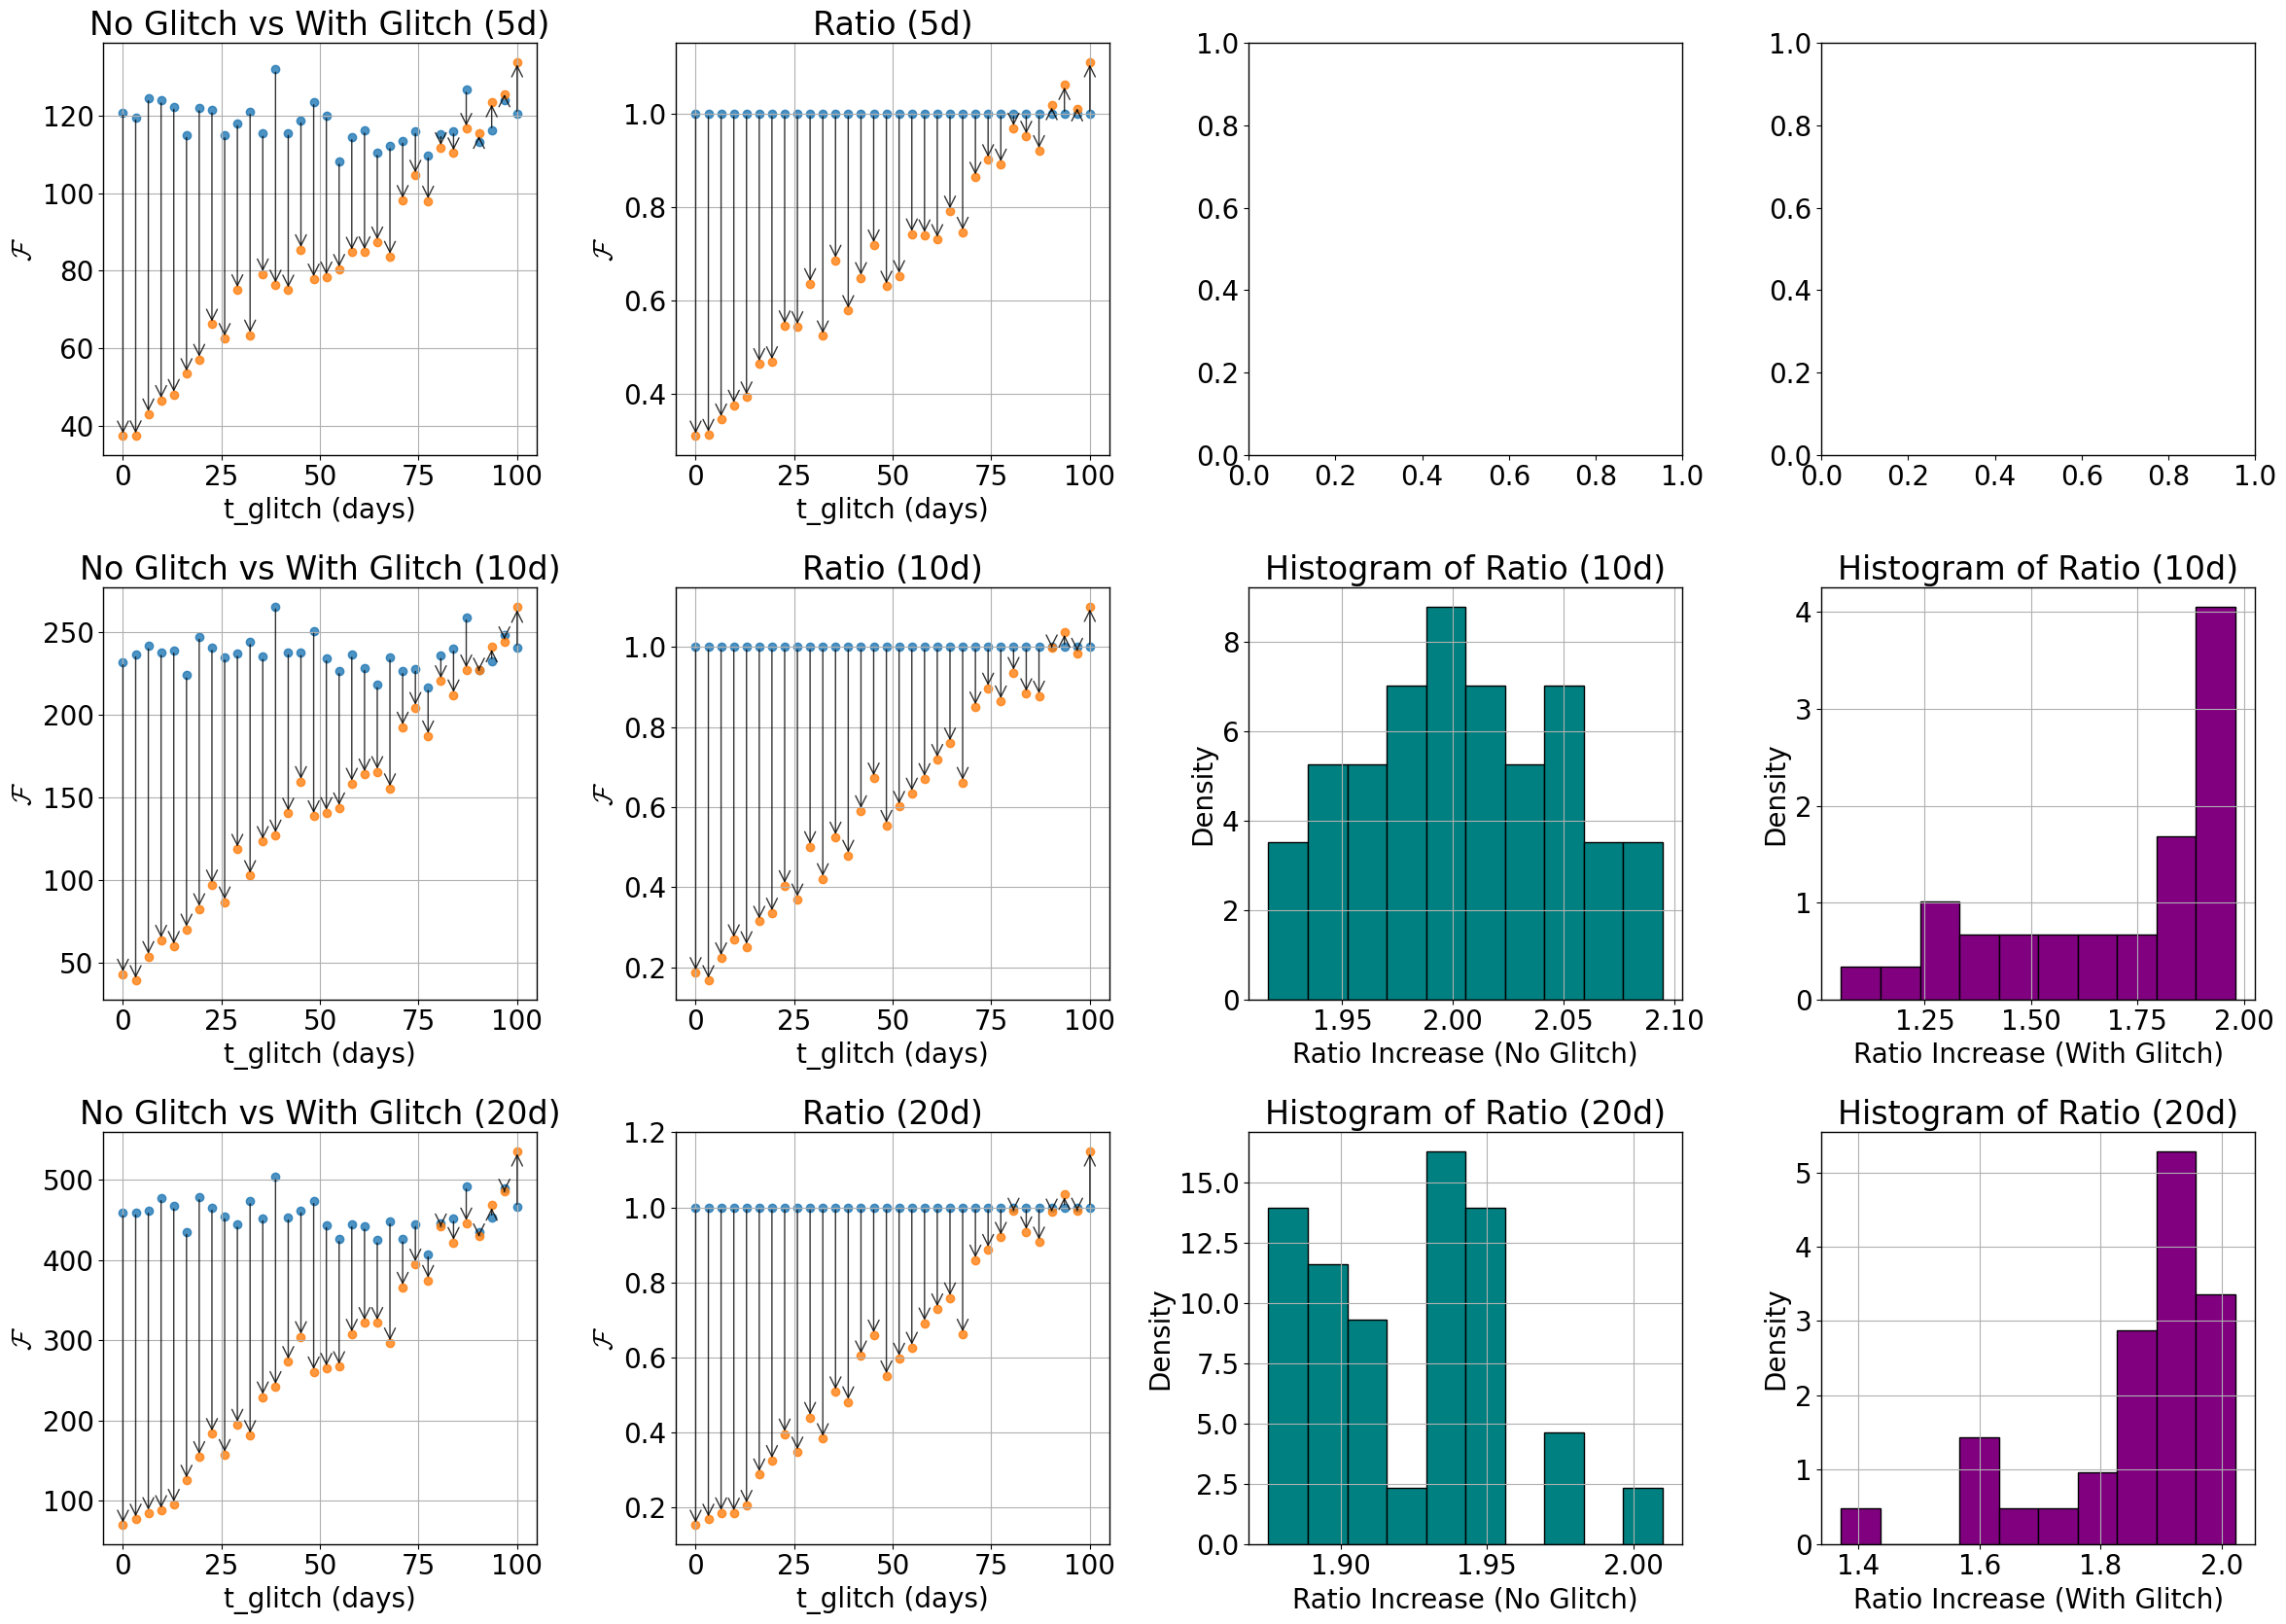

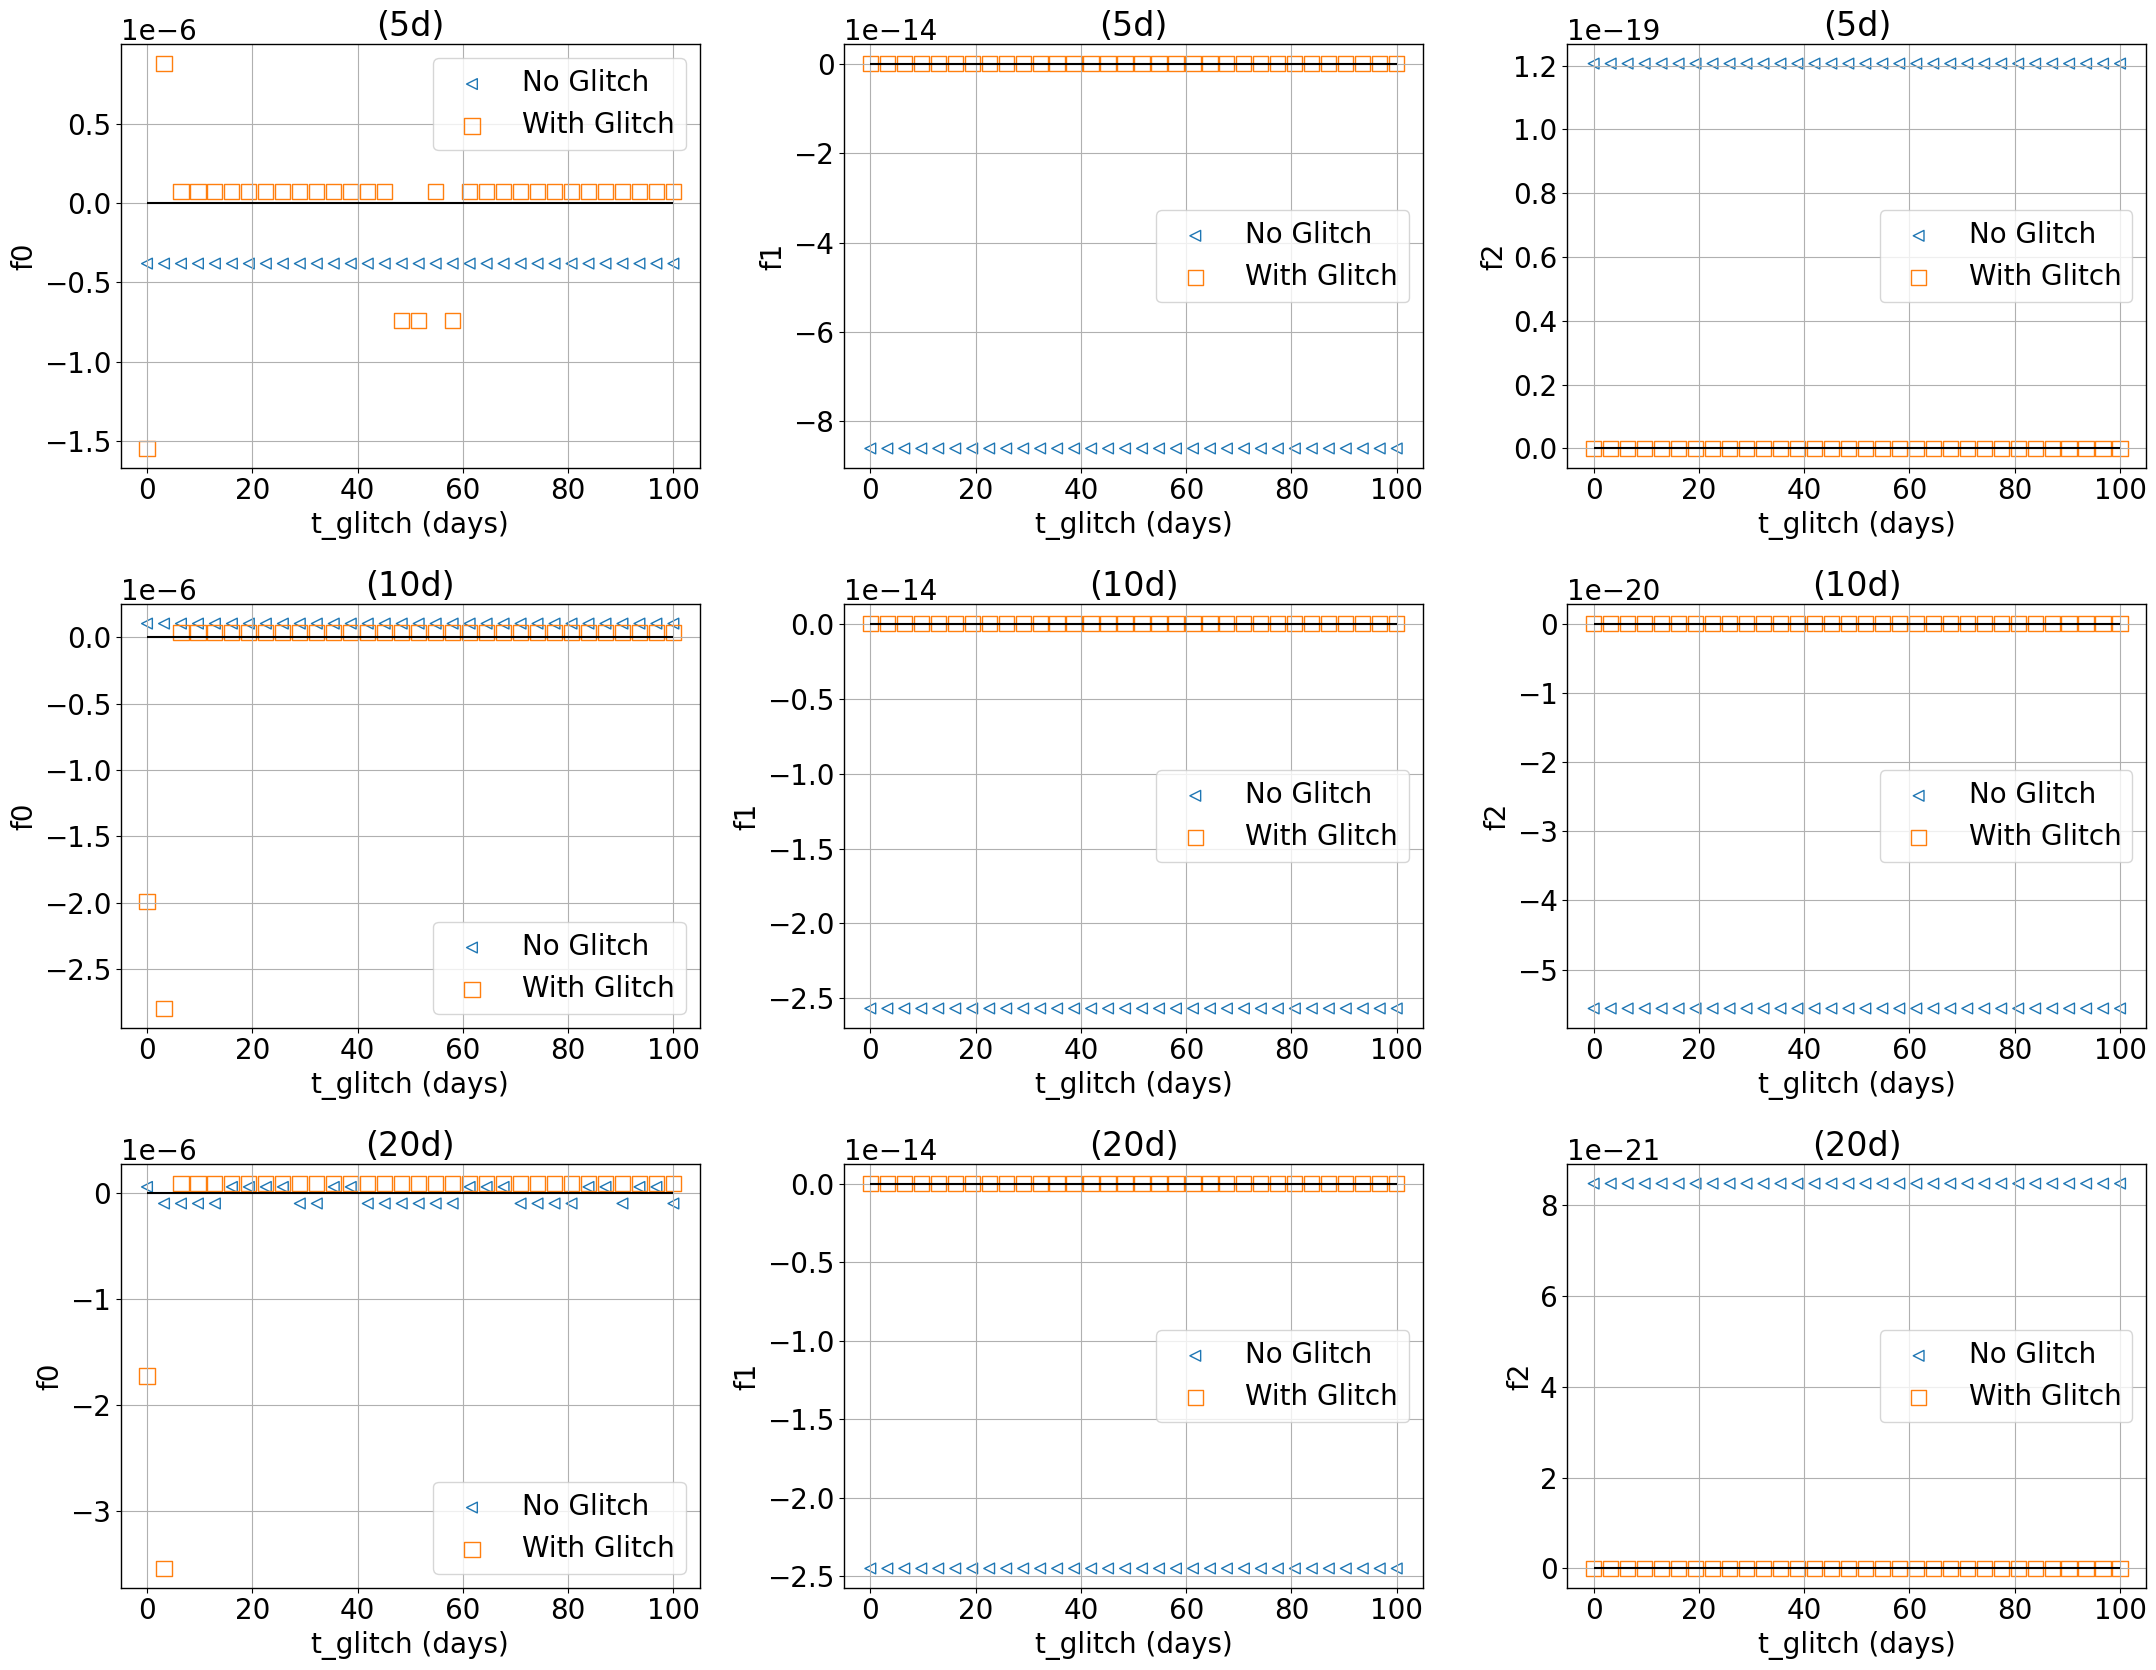

In [15]:
labels = ['no_glitch', 'with_glitch_onlytglitch']
plot_labels = ['No Glitch', 'With Glitch']
plot_glitch_ratio_analysis(labels, plot_labels, durations=['5d', '10d', '20d'])

plot_bias_ab(
    labels=['no_glitch', 'with_glitch_onlytglitch'],
    plot_labels=['No Glitch', 'With Glitch'],
    durations=['5d', '10d', '20d']
)

In [22]:
def plot_glitch_ratio_analysis(labels, plot_labels, durations=['5d', '10d', '20d'], n_glitch=1):
    """
    Create a 4x4 subplot grid comparing glitch analysis results with ratios.
    
    Parameters:
    -----------
    labels : list
        List of path components for data files ['no_glitch', 'with_glitch', ...]
    plot_labels : list
        List of labels for plots ['No Glitch', 'With Glitch', ...]
    durations : list
        List of duration strings (default: ['5d', '10d', '20d', '50d'])
    n_glitch : int
        Number of glitches per signal (default: 1)
    """
    
    # Load parameter data
    df = pd.read_csv(f'./data/{labels[1]}_v3/100-100Hz/signal_glitch_params.csv')

    # Extract parameters
    f0 = df['f0'][::n_glitch].values
    f1 = df['f1'][::n_glitch].values
    f2 = df['f2'][::n_glitch].values
    df_p = df['df_p'].values
    df_t = df['df_t'].values
    df1_p = df['df1_p'].values
    q = df['Q'].values
    t_glitch = df['tglitch_day'].values

    # Initialize previous arrays
    prev_a = np.ones(32)  # No Glitch
    prev_b = np.ones(32)  # With Glitch

    # Initialize figure with 4x4 subplots
    fig, ax = plt.subplots(3, 4, figsize=(24, 18))

    # Loop over durations
    for idx, duration in enumerate(durations):
        # Initialize arrays
        a = np.zeros(32)  # No Glitch
        b = np.zeros(32)  # With Glitch
        f0_list = np.zeros((32, 2))
        f1_list = np.zeros((32, 2))
        f2_list = np.zeros((32, 2))

        # Load data
        for i in range(32):
            d1 = fits.open(f'./results/{duration}/{labels[0]}_v2/100-100Hz/{labels[0]}_v2_CW{i}.fts')
            d2 = fits.open(f'./results/{duration}/{labels[1]}_v3/100-100Hz/{labels[1]}_v3_CW{i}_fixf1f2.fts')
            
            a[i] = d1[1].data['mean2F'][0]
            b[i] = d2[1].data['mean2F'][0]

            f0_list[i, 0] = d1[1].data['freq'][0]
            f1_list[i, 0] = d1[1].data['f1dot'][0]
            f2_list[i, 0] = d1[1].data['f2dot'][0]

            f0_list[i, 1] = d2[1].data['freq'][0]
            f1_list[i, 1] = d2[1].data['f1dot'][0]
            f2_list[i, 1] = d2[1].data['f2dot'][0]

        # Scatter plot: No Glitch vs With Glitch
        ax[idx, 0].scatter(t_glitch, a, label=plot_labels[0], alpha=0.8)
        ax[idx, 0].scatter(t_glitch, b, label=plot_labels[1], alpha=0.8)
        ax[idx, 0].set_xlabel('t_glitch (days)')
        ax[idx, 0].set_ylabel(r'$\mathcal{F}$')
        ax[idx, 0].grid(True)
        ax[idx, 0].set_title(f'{plot_labels[0]} vs {plot_labels[1]} ({duration})')
        
        for i in range(len(t_glitch)):
            ax[idx, 0].annotate('', xy=(t_glitch[i], b[i]), xytext=(t_glitch[i], a[i]), 
                               arrowprops=dict(arrowstyle='->', color='k', alpha=0.8))
        
        # Scatter plot: Ratio (No Glitch vs With Glitch)
        ax[idx, 1].scatter(t_glitch, a/a, label=plot_labels[0], alpha=0.8)
        ax[idx, 1].scatter(t_glitch, b/a, label=plot_labels[1], alpha=0.8)
        ax[idx, 1].set_xlabel('t_glitch (days)')
        ax[idx, 1].set_ylabel(r'$\mathcal{F}$')
        ax[idx, 1].grid(True)
        ax[idx, 1].set_title(f'Ratio ({duration})')
        
        for i in range(len(t_glitch)):
            ax[idx, 1].annotate('', xy=(t_glitch[i], b[i]/a[i]), xytext=(t_glitch[i], a[i]/a[i]), 
                               arrowprops=dict(arrowstyle='->', color='k', alpha=0.8))

        if idx != 0:
            # Histogram: Ratio Increase (No Glitch)
            ratios = a / prev_a
            ax[idx, 2].hist(ratios, bins=10, color='teal', edgecolor='black', density=True)
            ax[idx, 2].set_xlabel(f'Ratio Increase ({plot_labels[0]})')
            ax[idx, 2].set_ylabel('Density')
            ax[idx, 2].grid(True)
            ax[idx, 2].set_title(f'Histogram of Ratio ({duration})')
            
            # Histogram: Ratio Increase (With Glitch)
            ratios = b / prev_b
            ax[idx, 3].hist(ratios, bins=10, color='purple', edgecolor='black', density=True)
            ax[idx, 3].set_xlabel(f'Ratio Increase ({plot_labels[1]})')
            ax[idx, 3].set_ylabel('Density')
            ax[idx, 3].grid(True)
            ax[idx, 3].set_title(f'Histogram of Ratio ({duration})')

        prev_a, prev_b = a, b

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_bias_ab(labels, plot_labels, durations=['5d', '10d', '20d'], n_glitch=1, markers=['<', 's', 'o']):
    """
    Create a 4x3 subplot grid comparing frequency parameters for glitch analysis.
    
    Parameters:
    -----------
    labels : list
        List of path components for data files ['no_glitch', 'with_glitch', 'no_glitch_diffnoise']
    plot_labels : list
        List of labels for plots ['No Glitch', 'With Glitch', 'No Glitch Noise']
    durations : list
        List of duration strings (default: ['5d', '10d', '20d', '50d'])
    n_glitch : int
        Number of glitches per signal (default: 1)
    markers : list
        List of markers for scatter plots (default: ['o', '<', '>'])
    colors : list
        List of colors for scatter plots (default: ['blue', 'red', 'green'])
    """
    
    # Load parameter data
    df = pd.read_csv(f'./data/{labels[1]}_v3/100-100Hz/signal_glitch_params.csv')

    # Extract parameters
    f0 = df['f0'][::n_glitch].values
    f1 = df['f1'][::n_glitch].values
    f2 = df['f2'][::n_glitch].values
    df_p = df['df_p'].values
    df_t = df['df_t'].values
    df1_p = df['df1_p'].values
    q = df['Q'].values
    t_glitch = df['tglitch_day'].values

    # Initialize figure with 4x3 subplots
    fig, ax = plt.subplots(3, 3, figsize=(22, 18))
    # Loop over durations
    for idx, duration in enumerate(durations):
        # Initialize arrays
        f0_list = np.zeros((32, 2))
        f1_list = np.zeros((32, 2))
        f2_list = np.zeros((32, 2))

        # Load data
        for i in range(32):
            d1 = fits.open(f'./results/{duration}/{labels[0]}_v2/100-100Hz/{labels[0]}_v2_CW{i}.fts')
            d2 = fits.open(f'./results/{duration}/{labels[1]}_v3/100-100Hz/{labels[1]}_v3_CW{i}_fixf1f2.fts')

            f0_list[i, 0] = d1[1].data['freq'][0]
            f1_list[i, 0] = d1[1].data['f1dot'][0]
            f2_list[i, 0] = d1[1].data['f2dot'][0]

            f0_list[i, 1] = d2[1].data['freq'][0]
            f1_list[i, 1] = d2[1].data['f1dot'][0]
            f2_list[i, 1] = d2[1].data['f2dot'][0]

        # Data and truth arrays for plotting
        data = [f0_list, f1_list, f2_list]
        truth = [f0, f1, f2]

        # Plot for each frequency parameter (f0, f1, f2)
        for plot_i in range(3):
            for j in range(2):
                # Scatter plot: Difference from truth
                ax[idx, plot_i].scatter(t_glitch, (data[plot_i][:, j] - truth[plot_i]), 
                                       color=colors[j], label=plot_labels[j], 
                                       marker=markers[j], facecolors='none', s=30*2*((j+1)))
            ax[idx, plot_i].hlines([0], 0, 100, color="k")
            ax[idx, plot_i].set_xlabel('t_glitch (days)')

            if plot_i == 0:
                ax[idx, plot_i].set_ylim(-5e-7, 5e-7)
                
            ax[idx, plot_i].set_ylabel(f'f{plot_i}')
            ax[idx, plot_i].legend()
            ax[idx, plot_i].grid(True)
            ax[idx, plot_i].set_title(f'({duration})')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

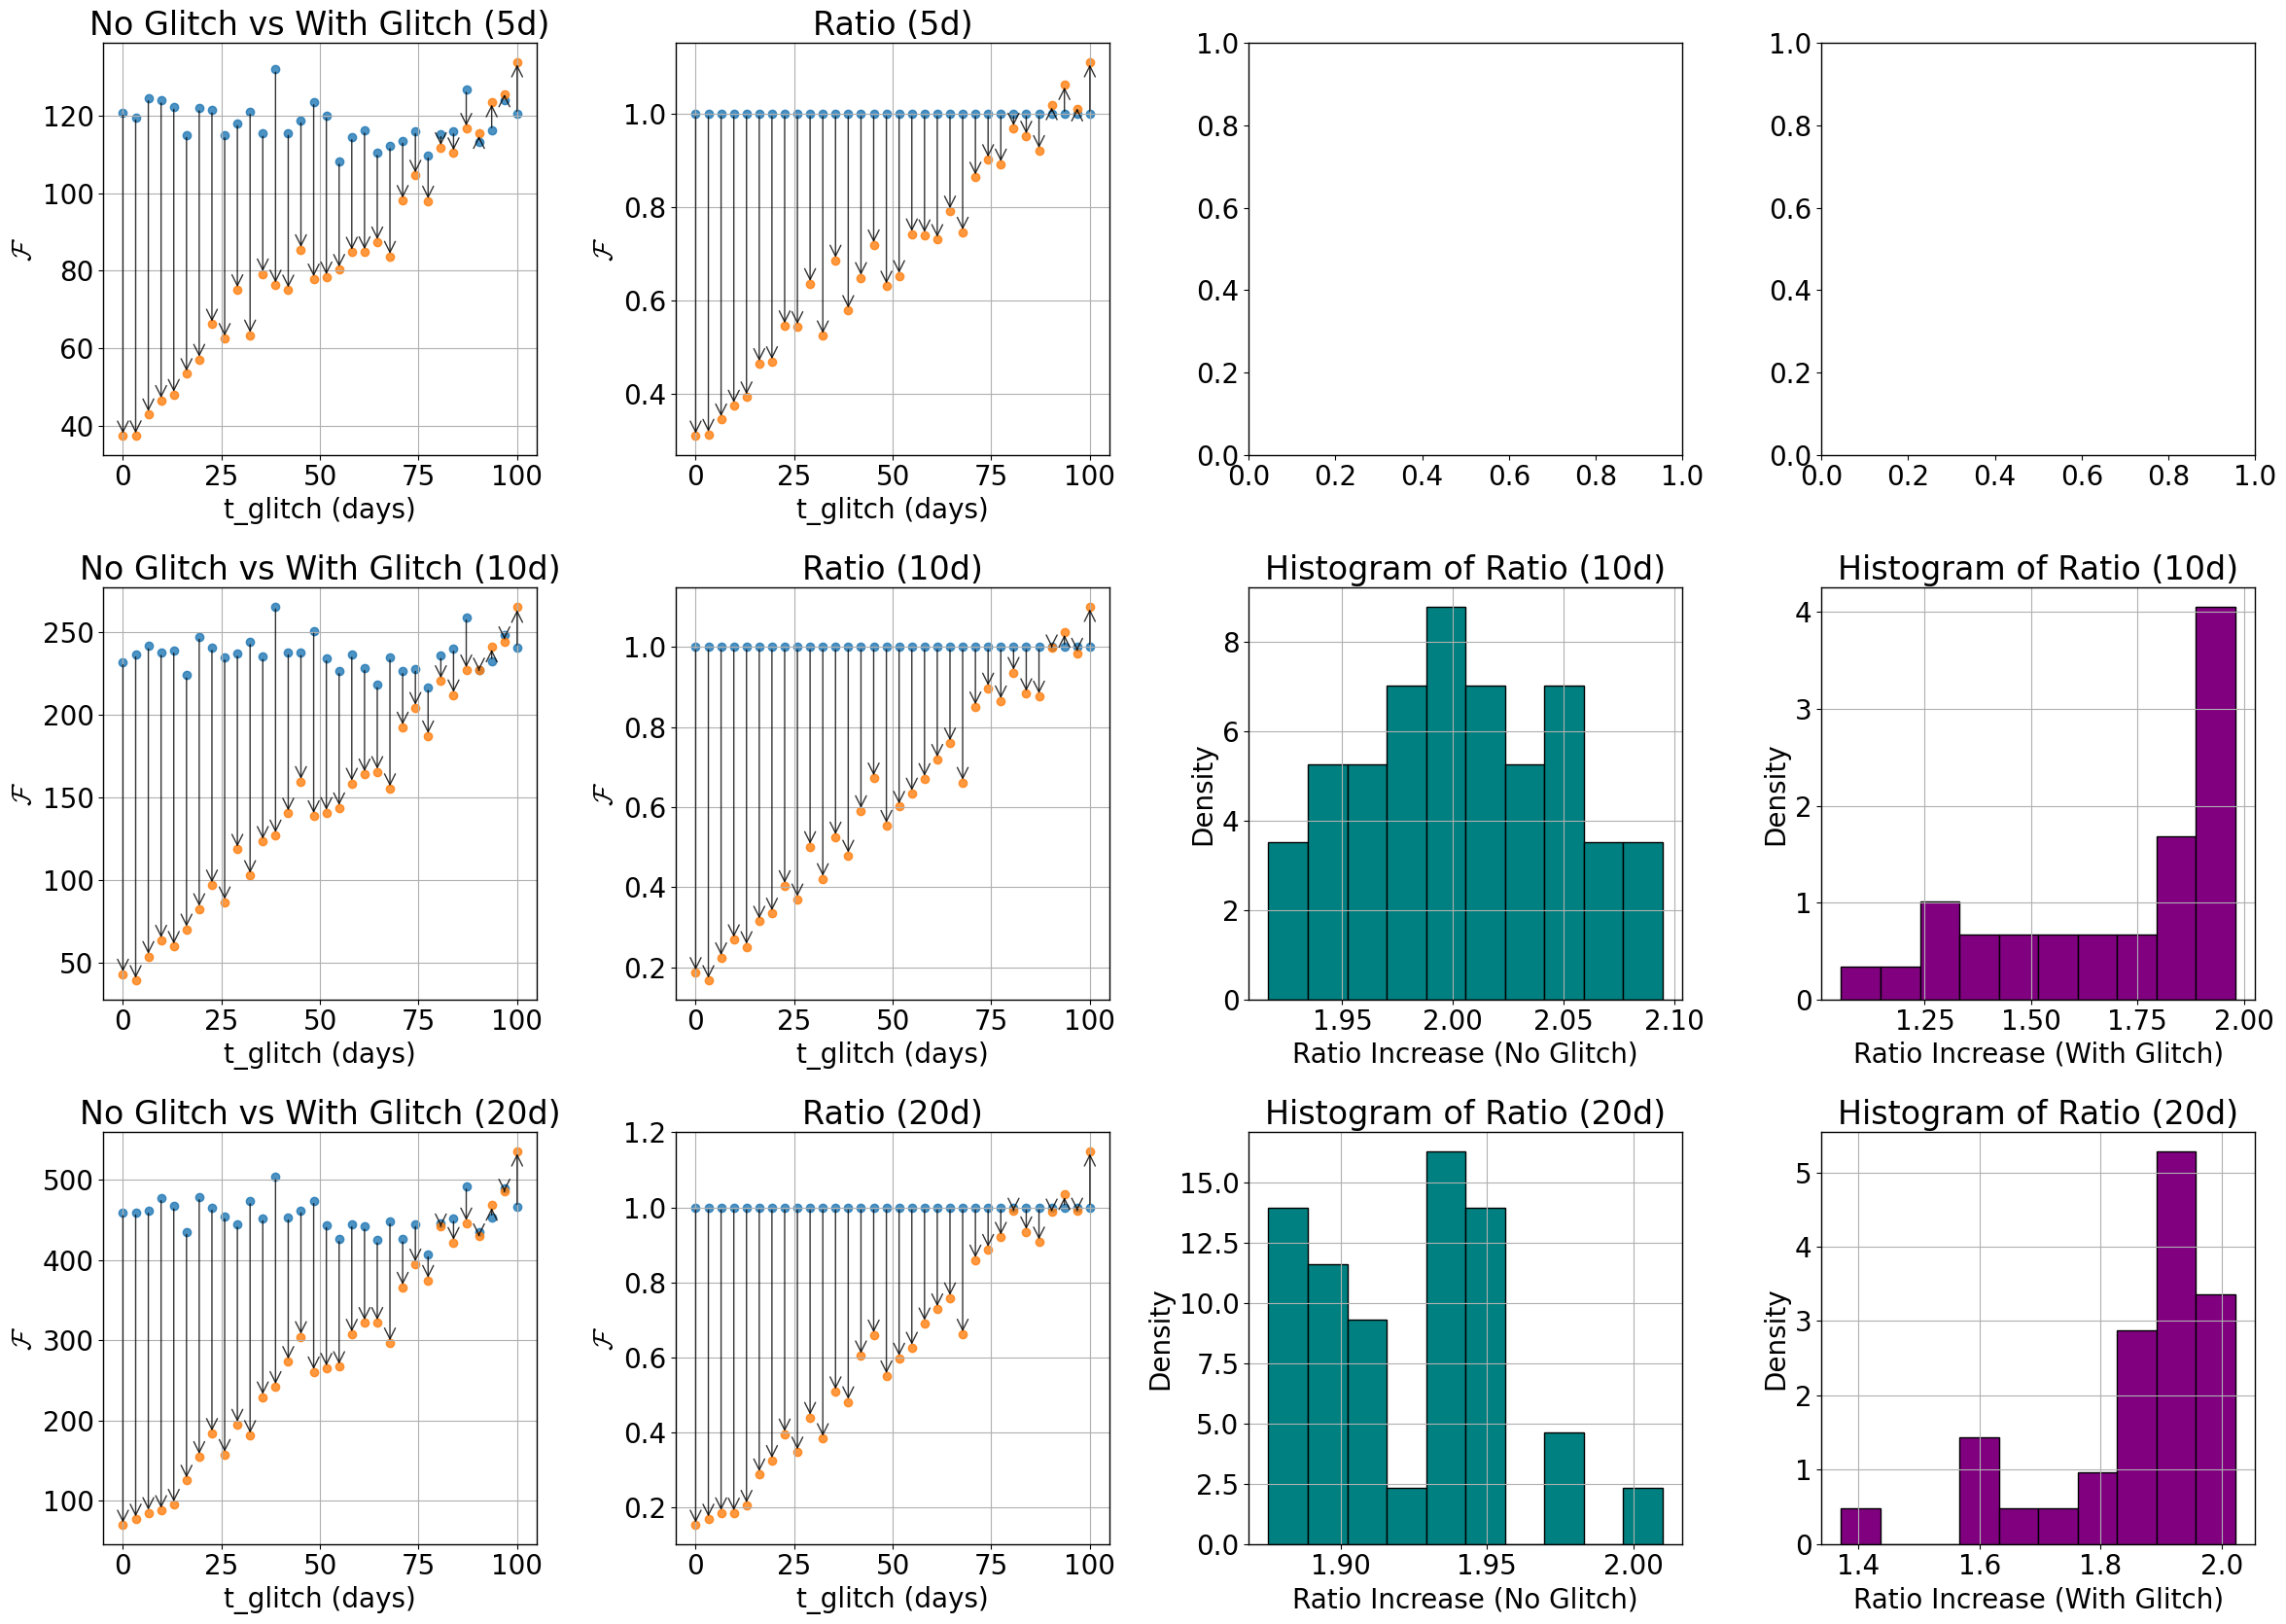

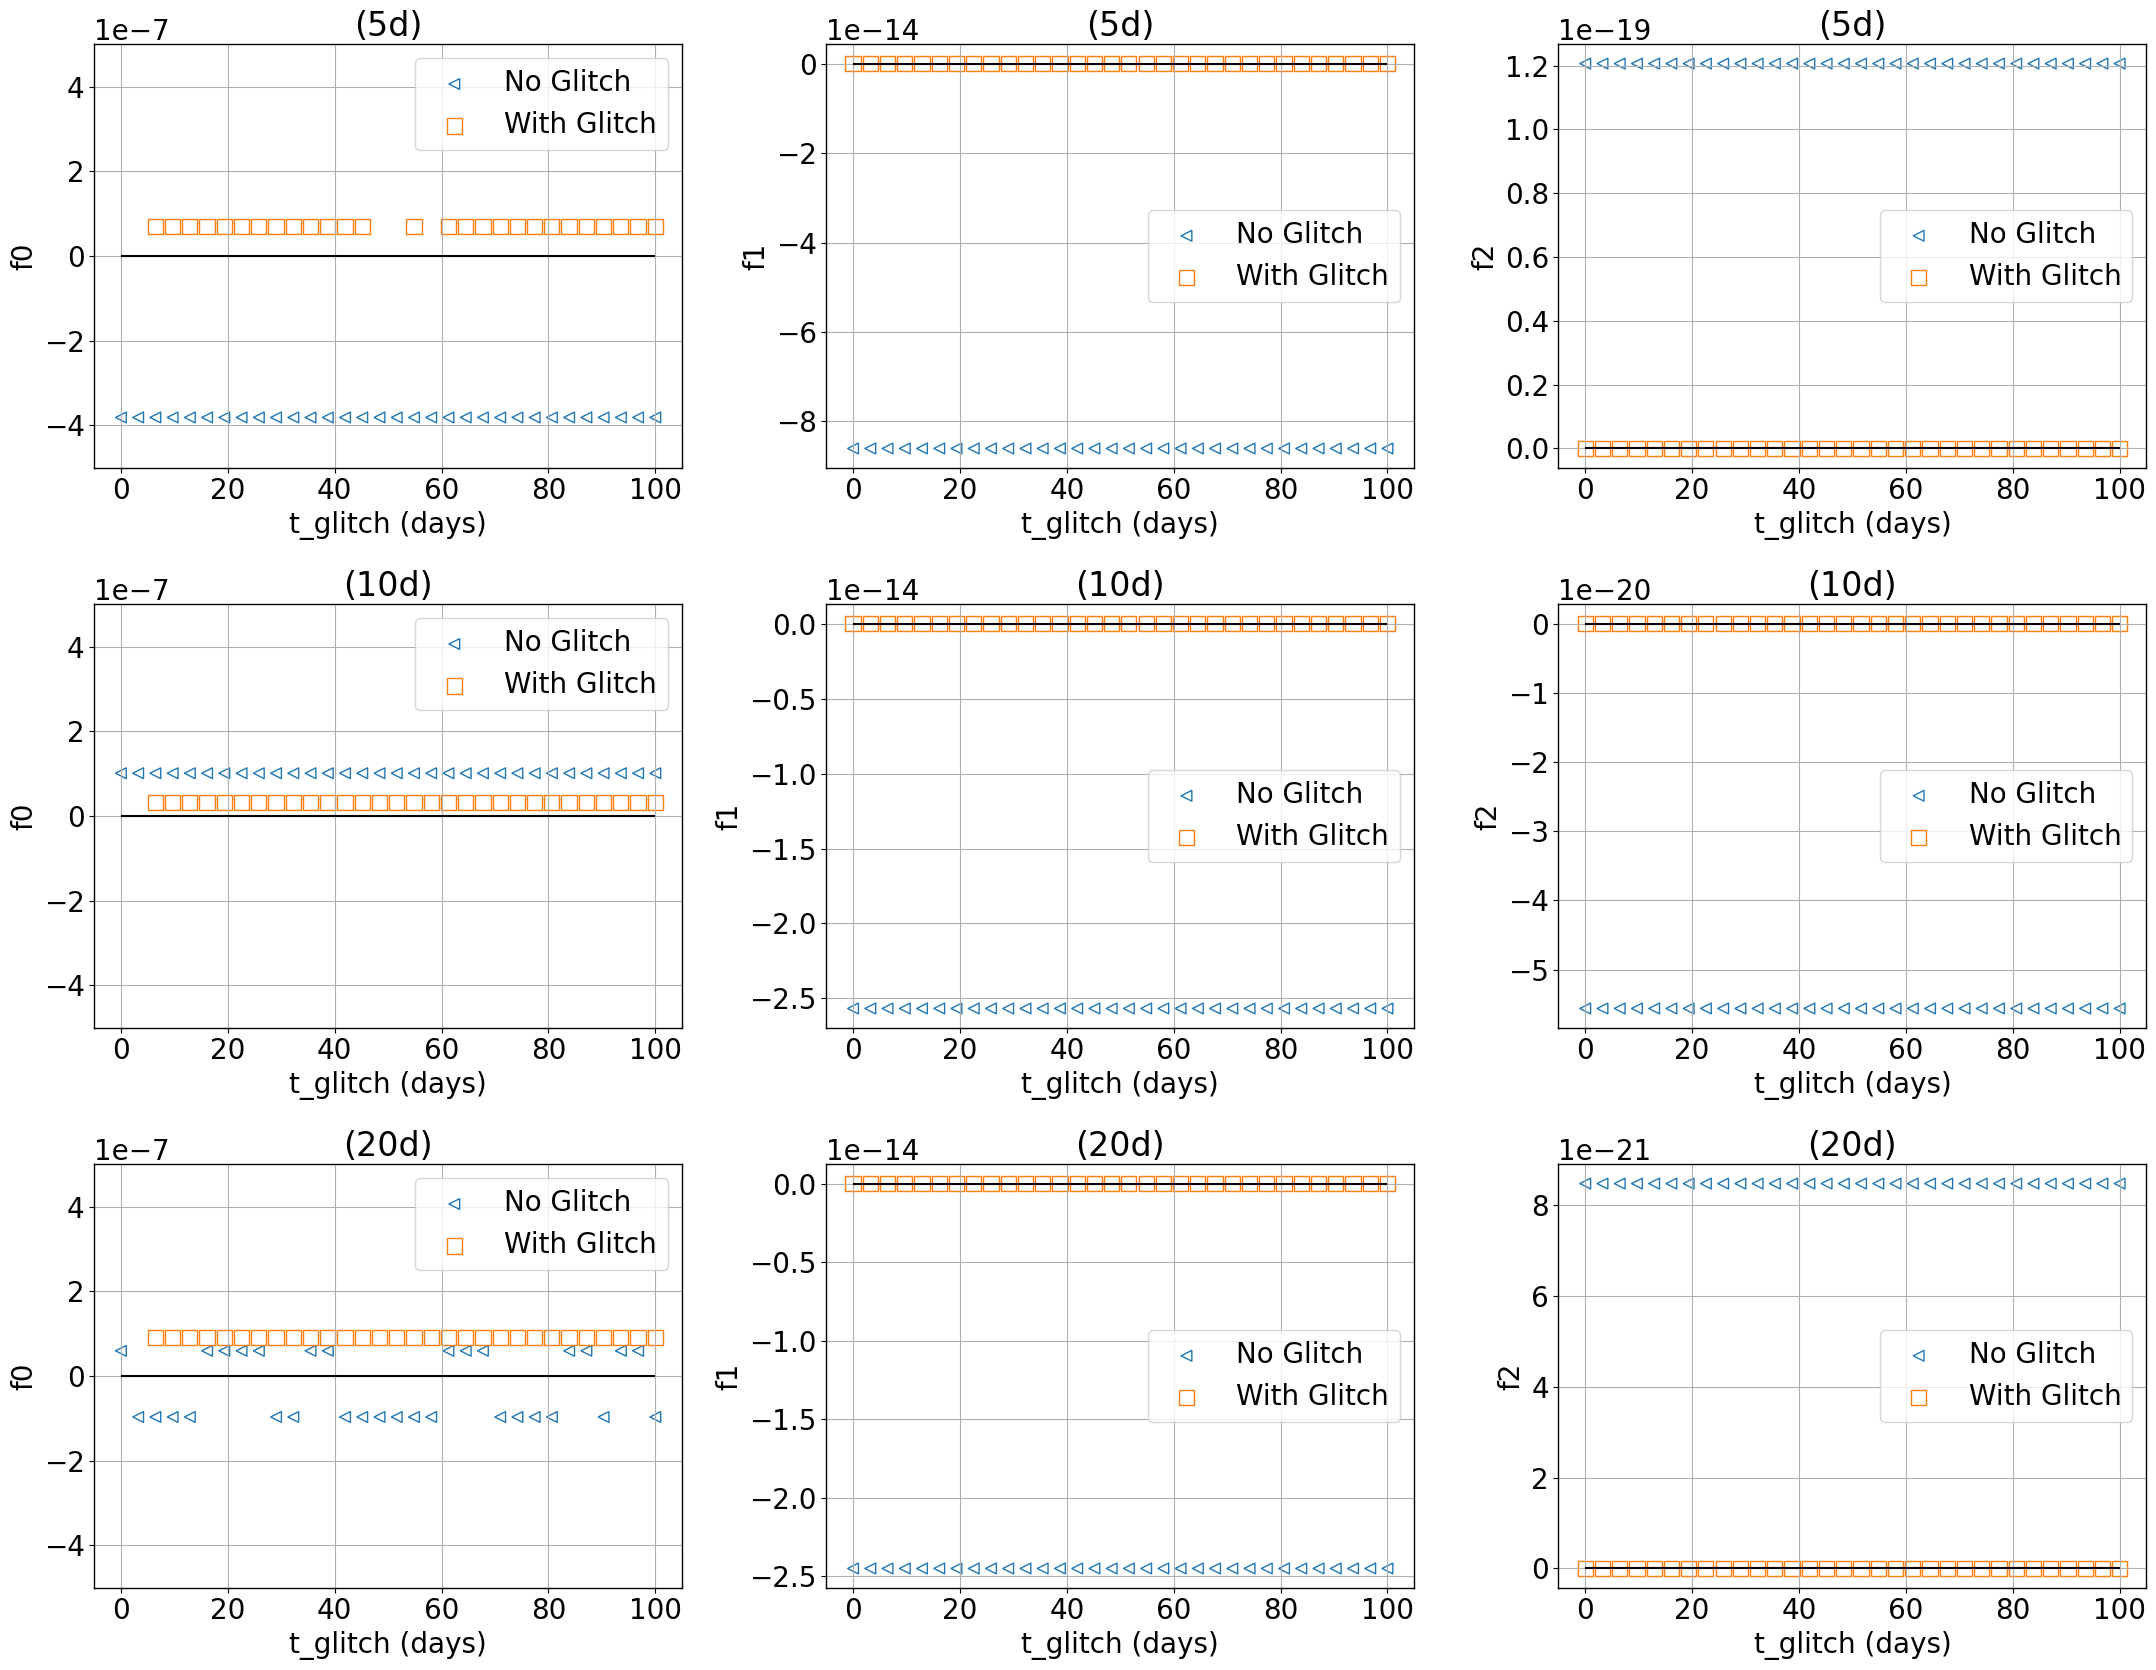

In [23]:
labels = ['no_glitch', 'with_glitch_onlytglitch']
plot_labels = ['No Glitch', 'With Glitch']
plot_glitch_ratio_analysis(labels, plot_labels, durations=['5d', '10d', '20d'])

plot_bias_ab(
    labels=['no_glitch', 'with_glitch_onlytglitch'],
    plot_labels=['No Glitch', 'With Glitch'],
    durations=['5d', '10d', '20d']
)

# Parameter Bias

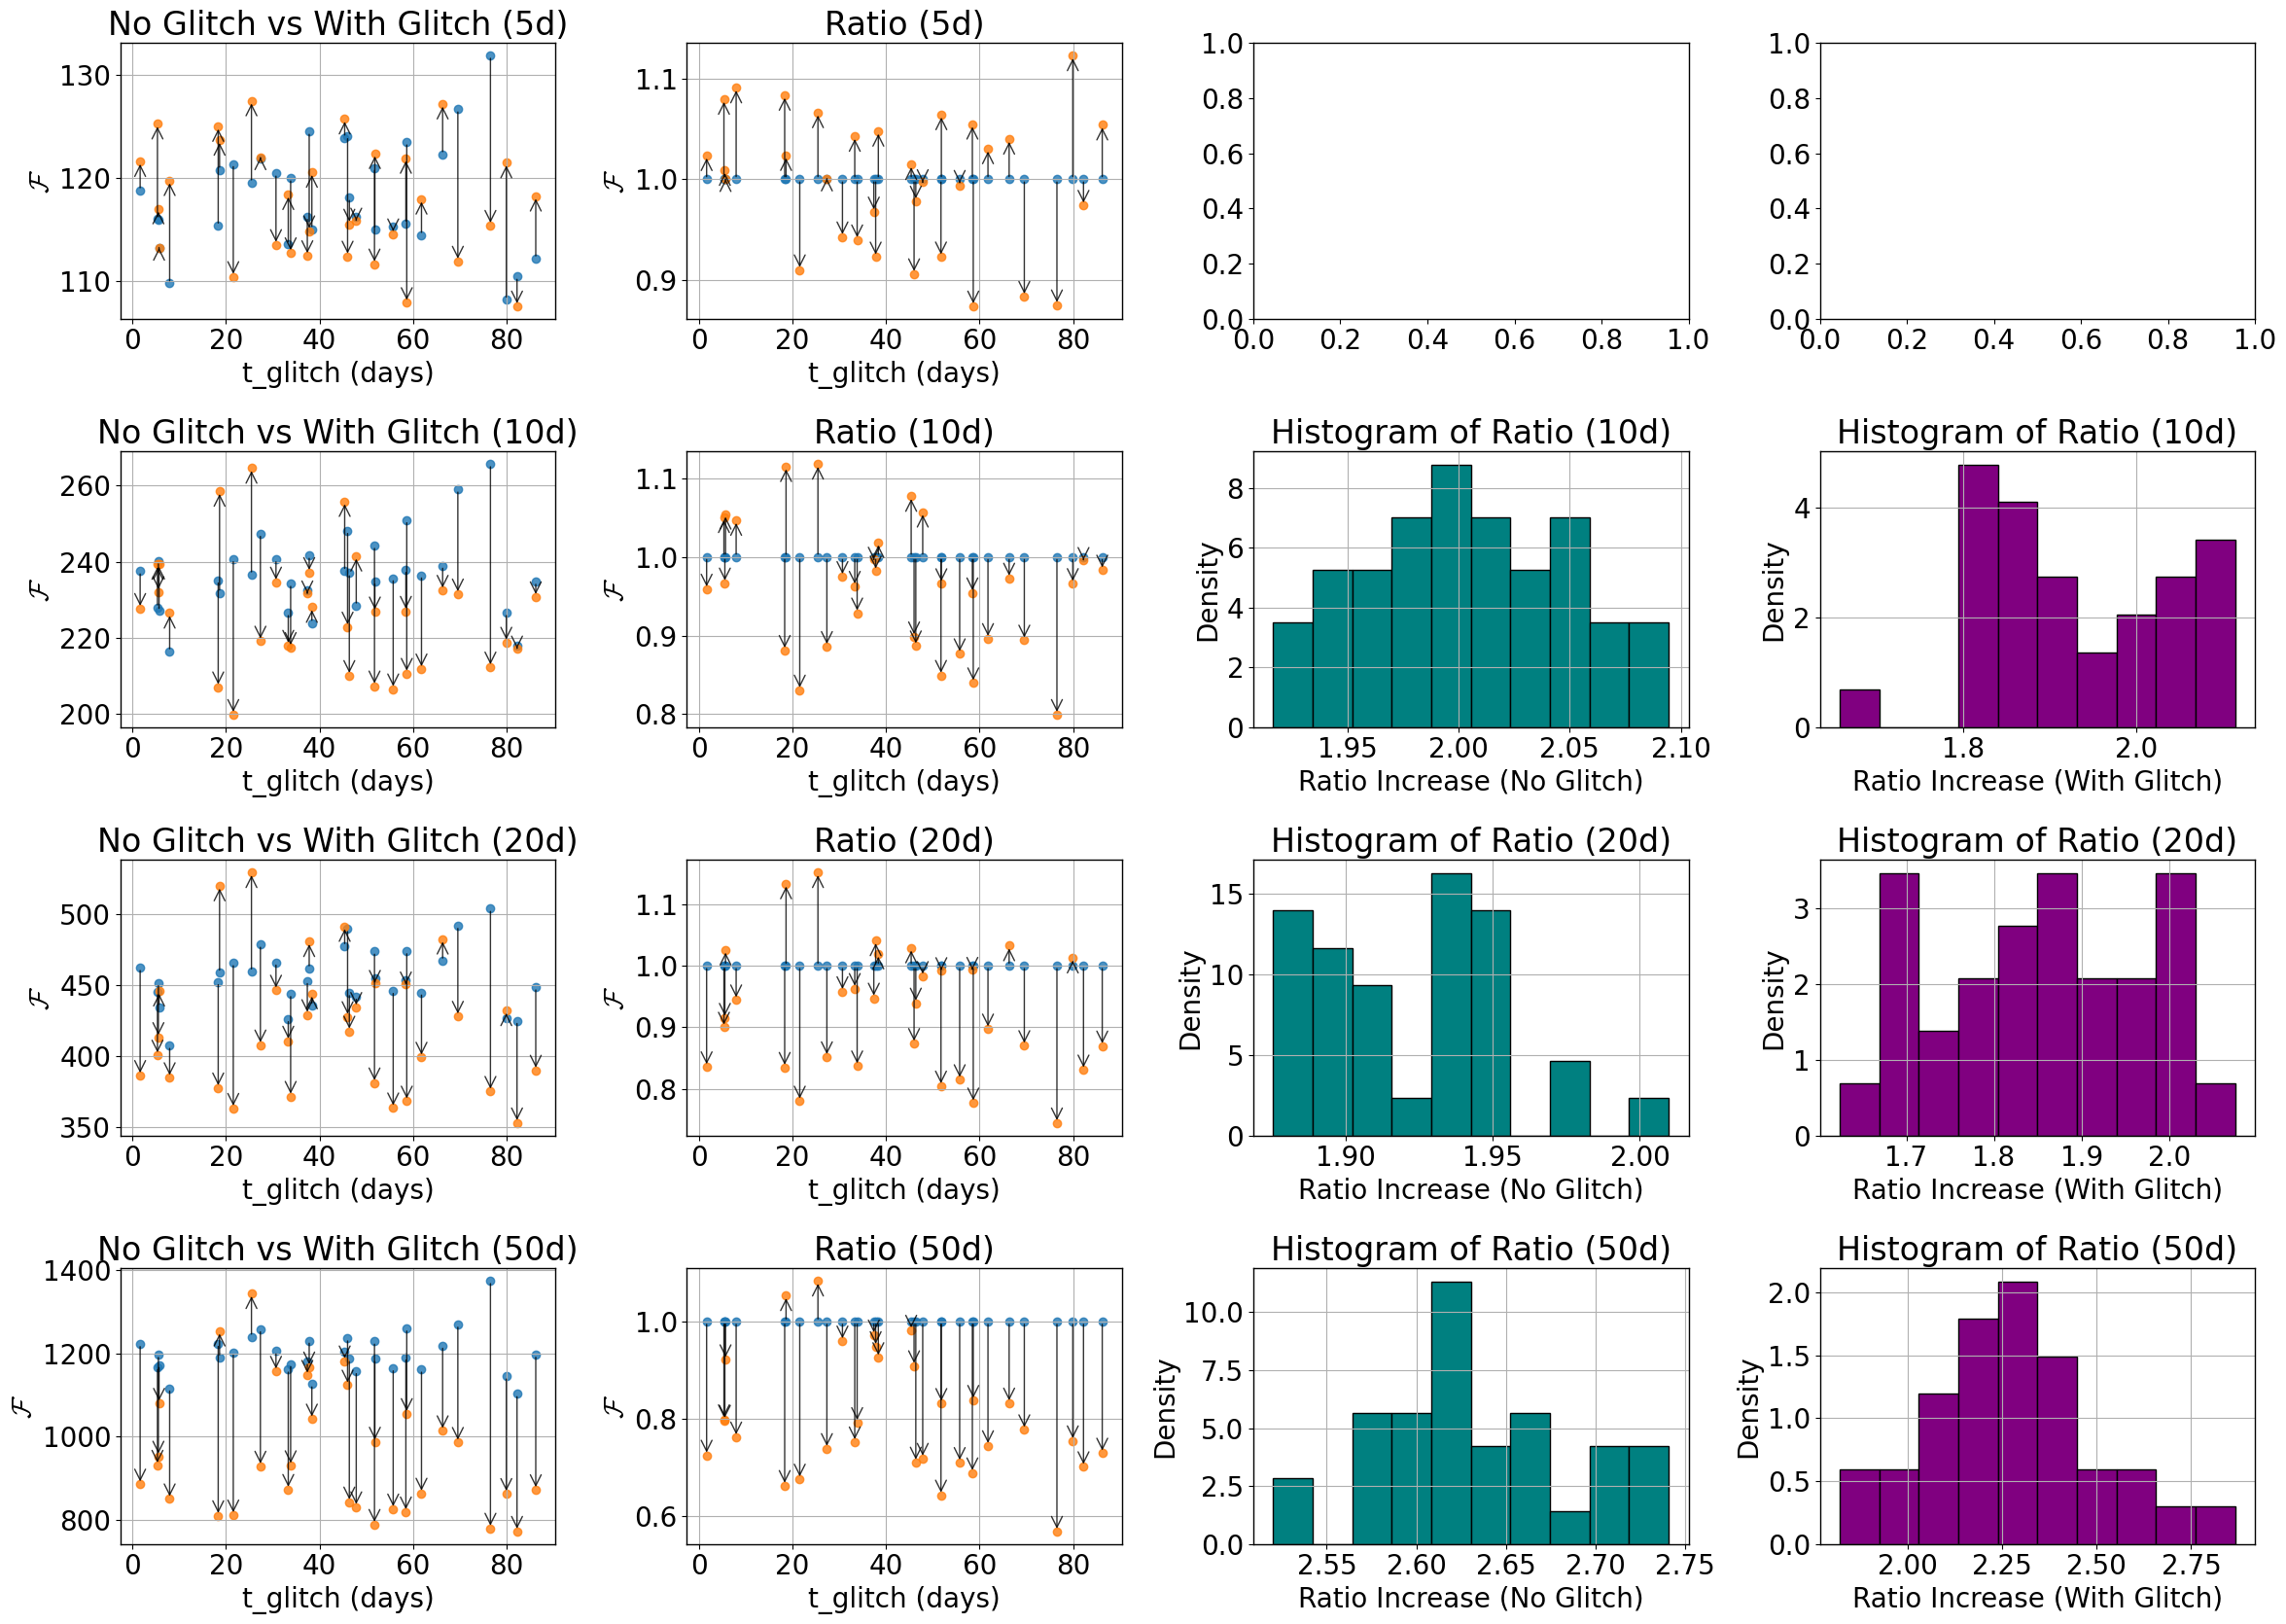

In [11]:
plot_glitch_ratio_analysis(
    labels=['no_glitch', 'with_glitch_onlytglitch'],
    plot_labels=['No Glitch', 'With Glitch']
)

# No/With Glitch Magnitude, Ratio, and Ratio Increase

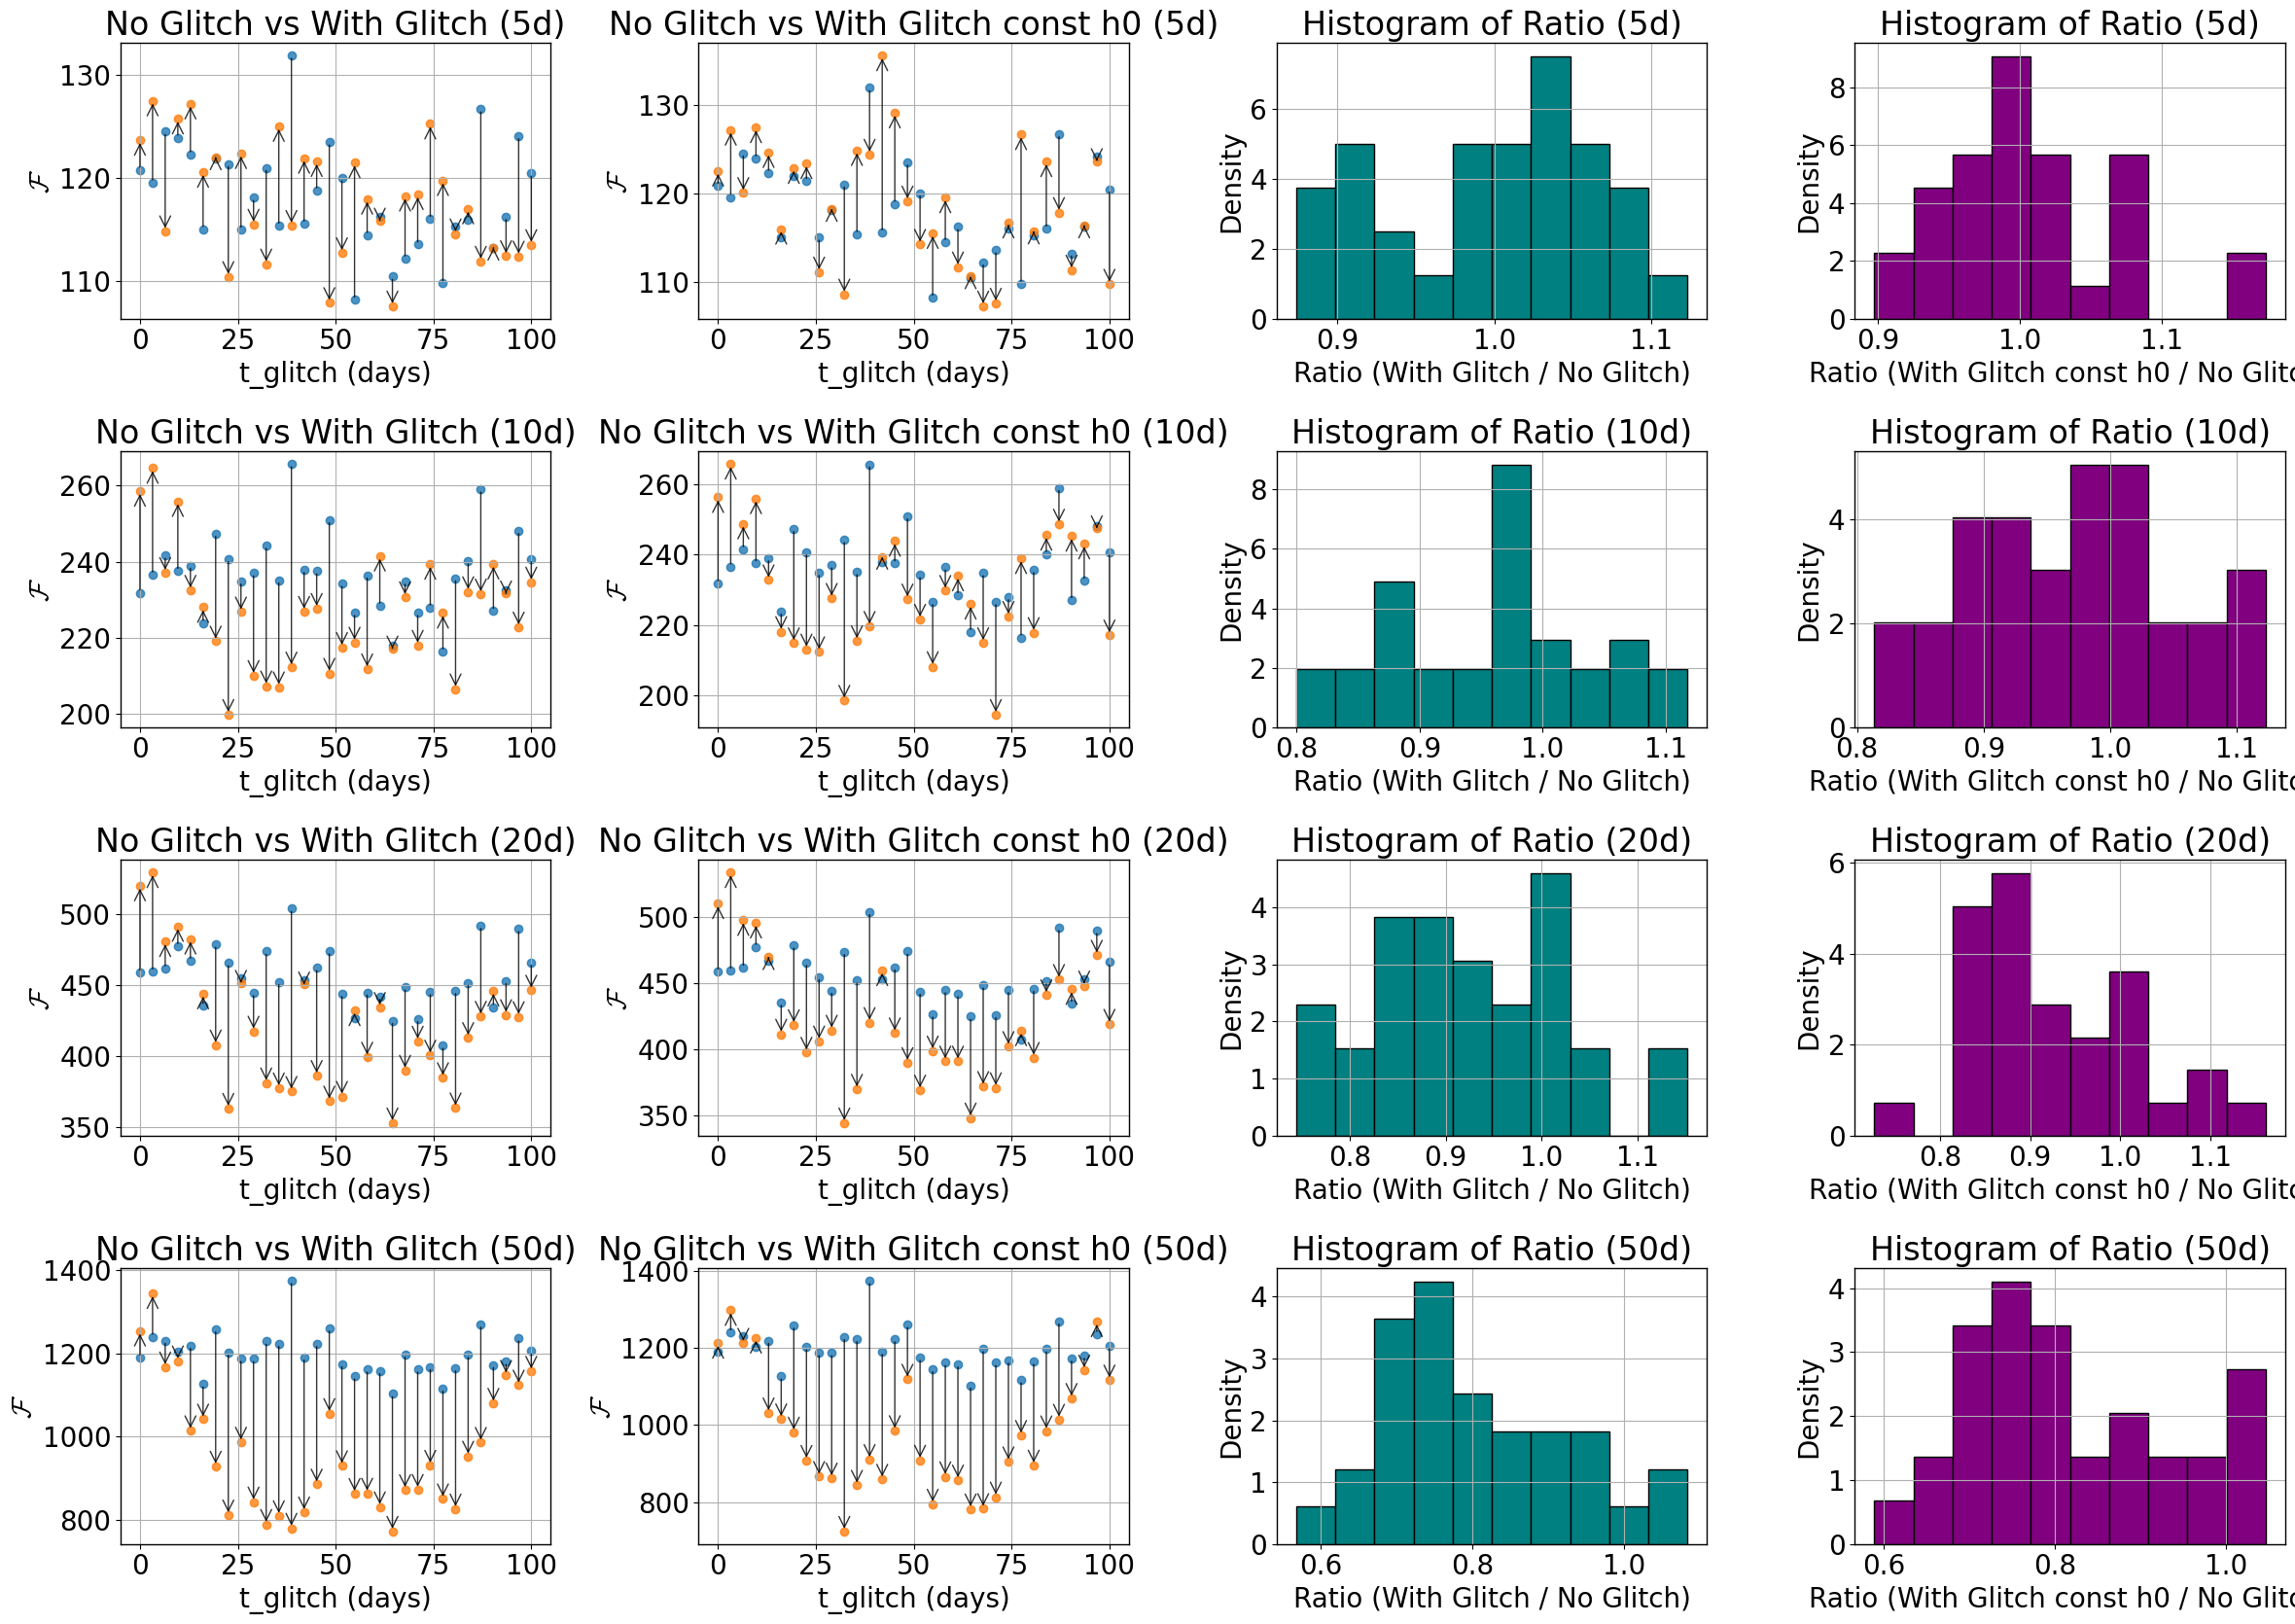

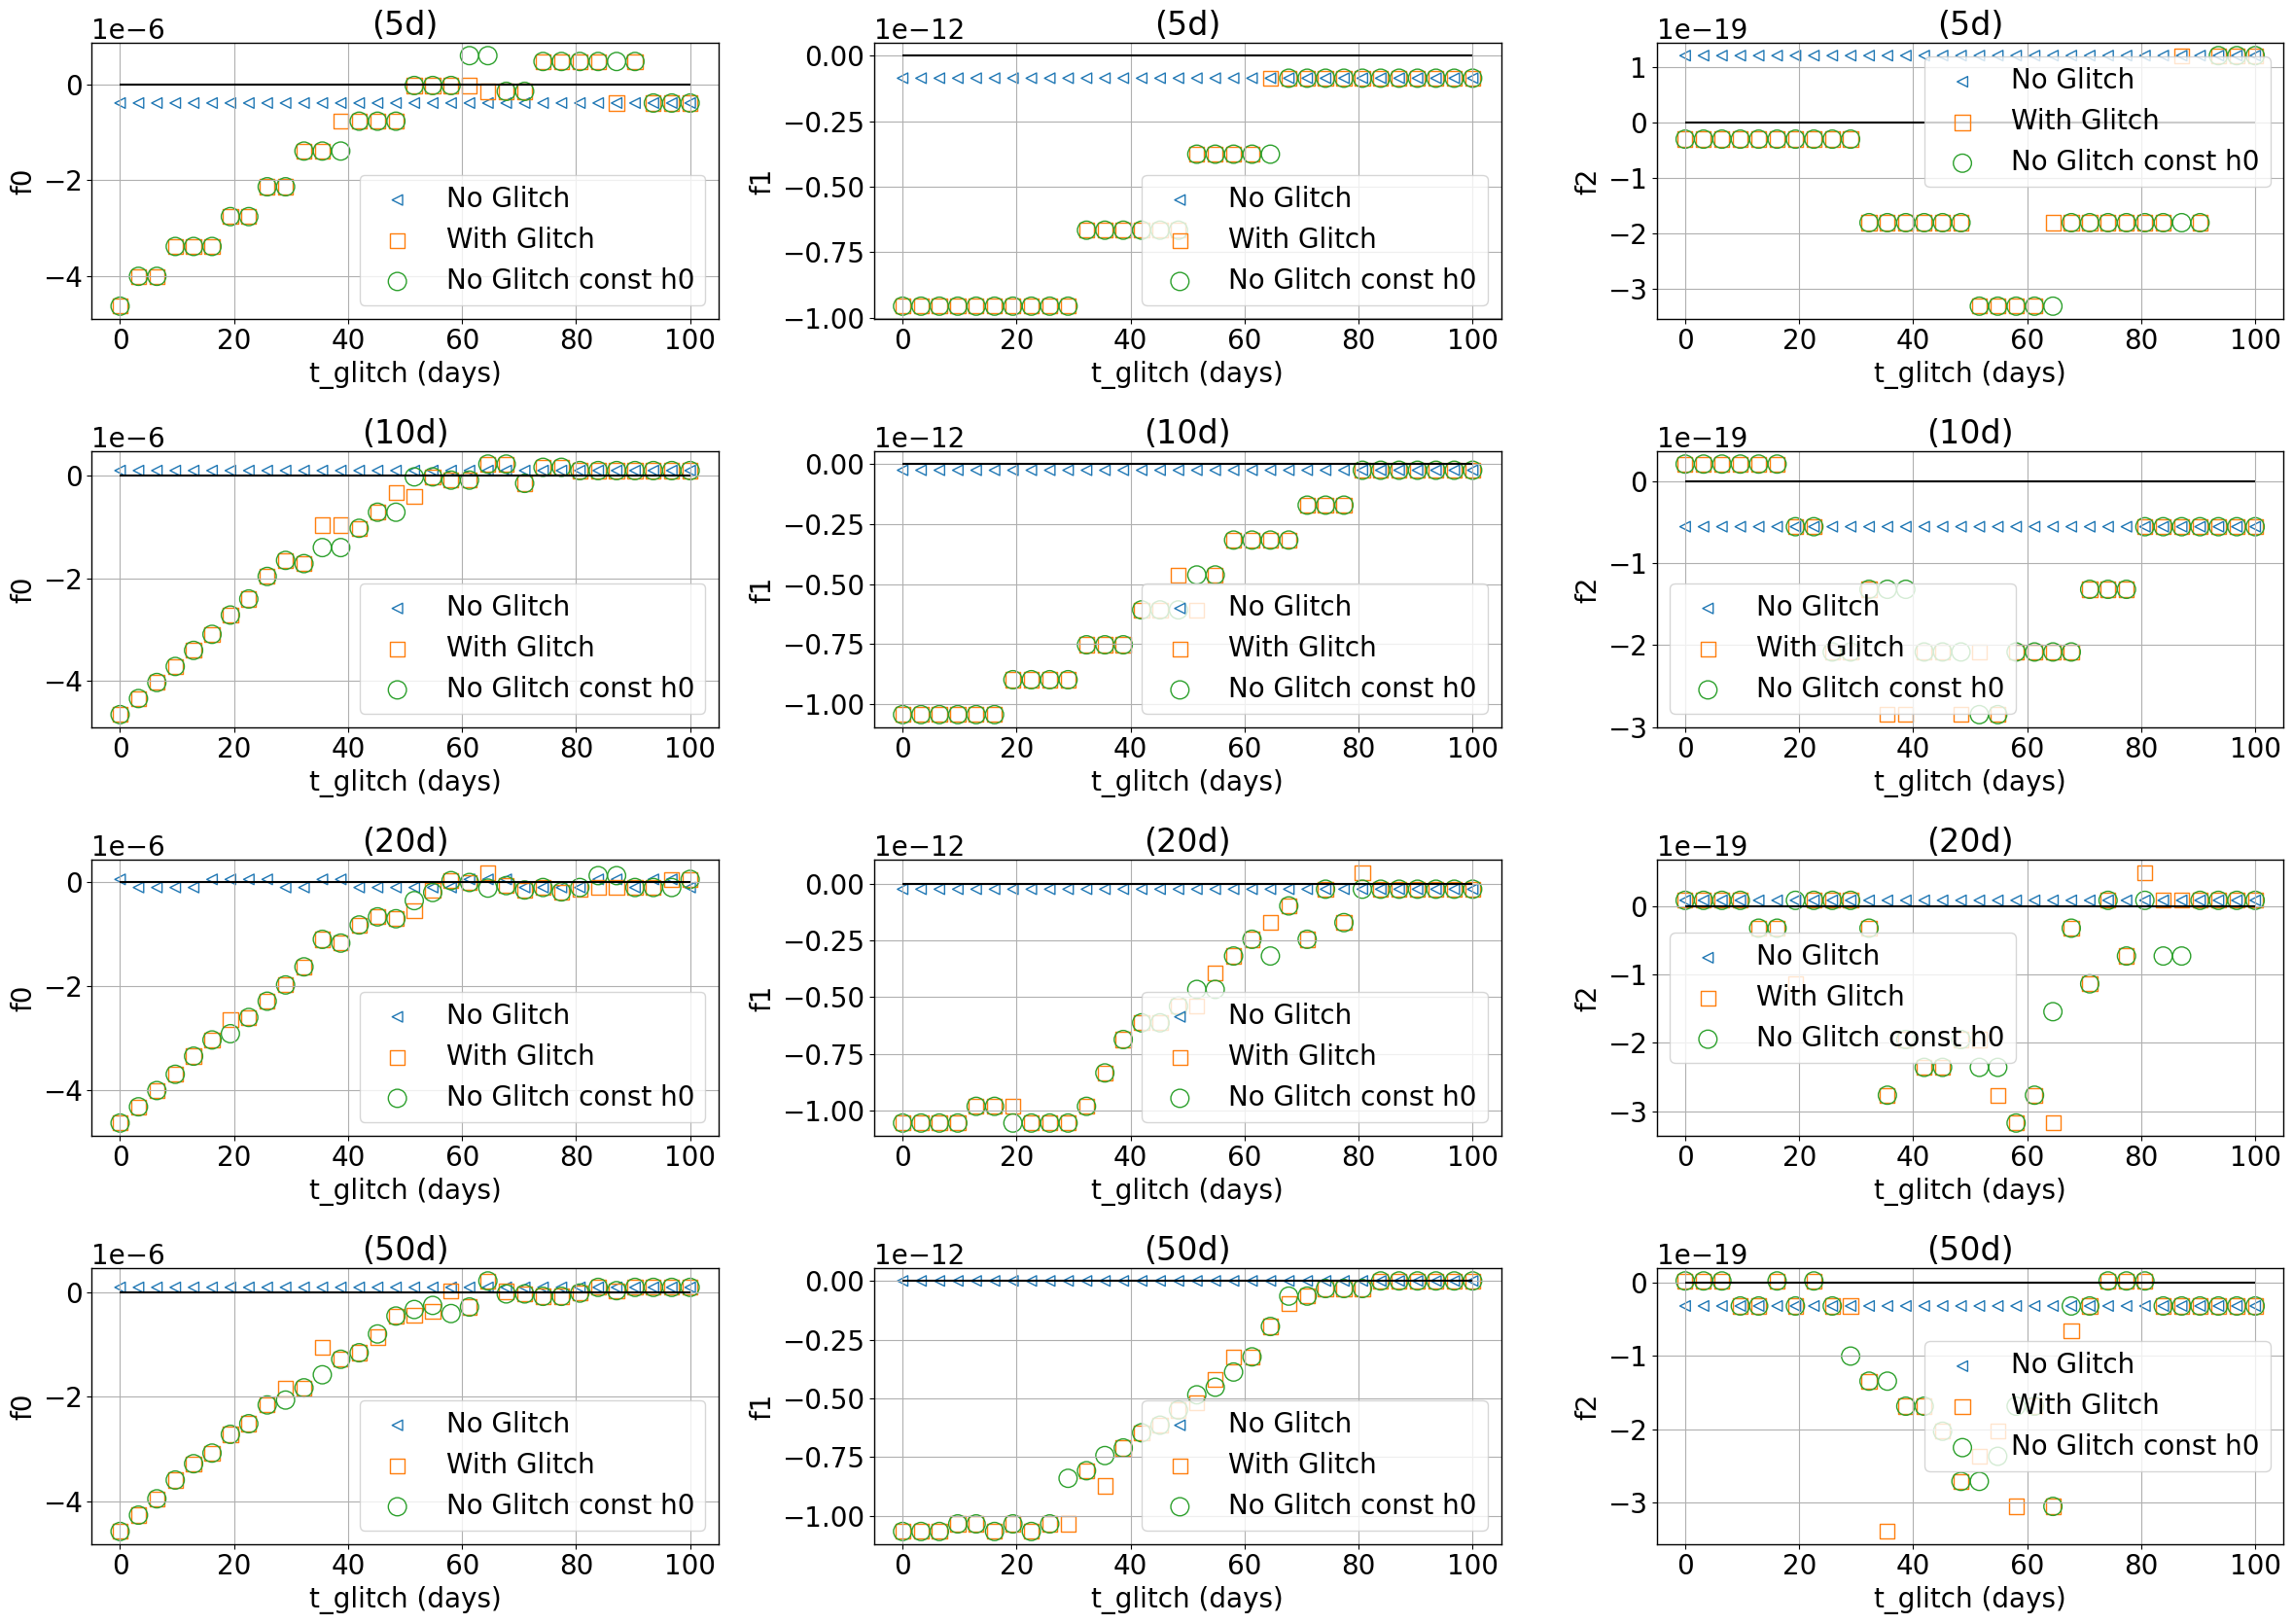

In [12]:
labels = ['no_glitch', 'with_glitch_onlytglitch', 'with_glitch_onlytglitch_ch0']
plot_labels = ['No Glitch', 'With Glitch', 'With Glitch const h0']
plot_glitch_analysis(labels, plot_labels)

plot_bias(
    labels=['no_glitch', 'with_glitch_onlytglitch', 'with_glitch_onlytglitch_ch0'],
    plot_labels=['No Glitch', 'With Glitch', 'No Glitch const h0']
)


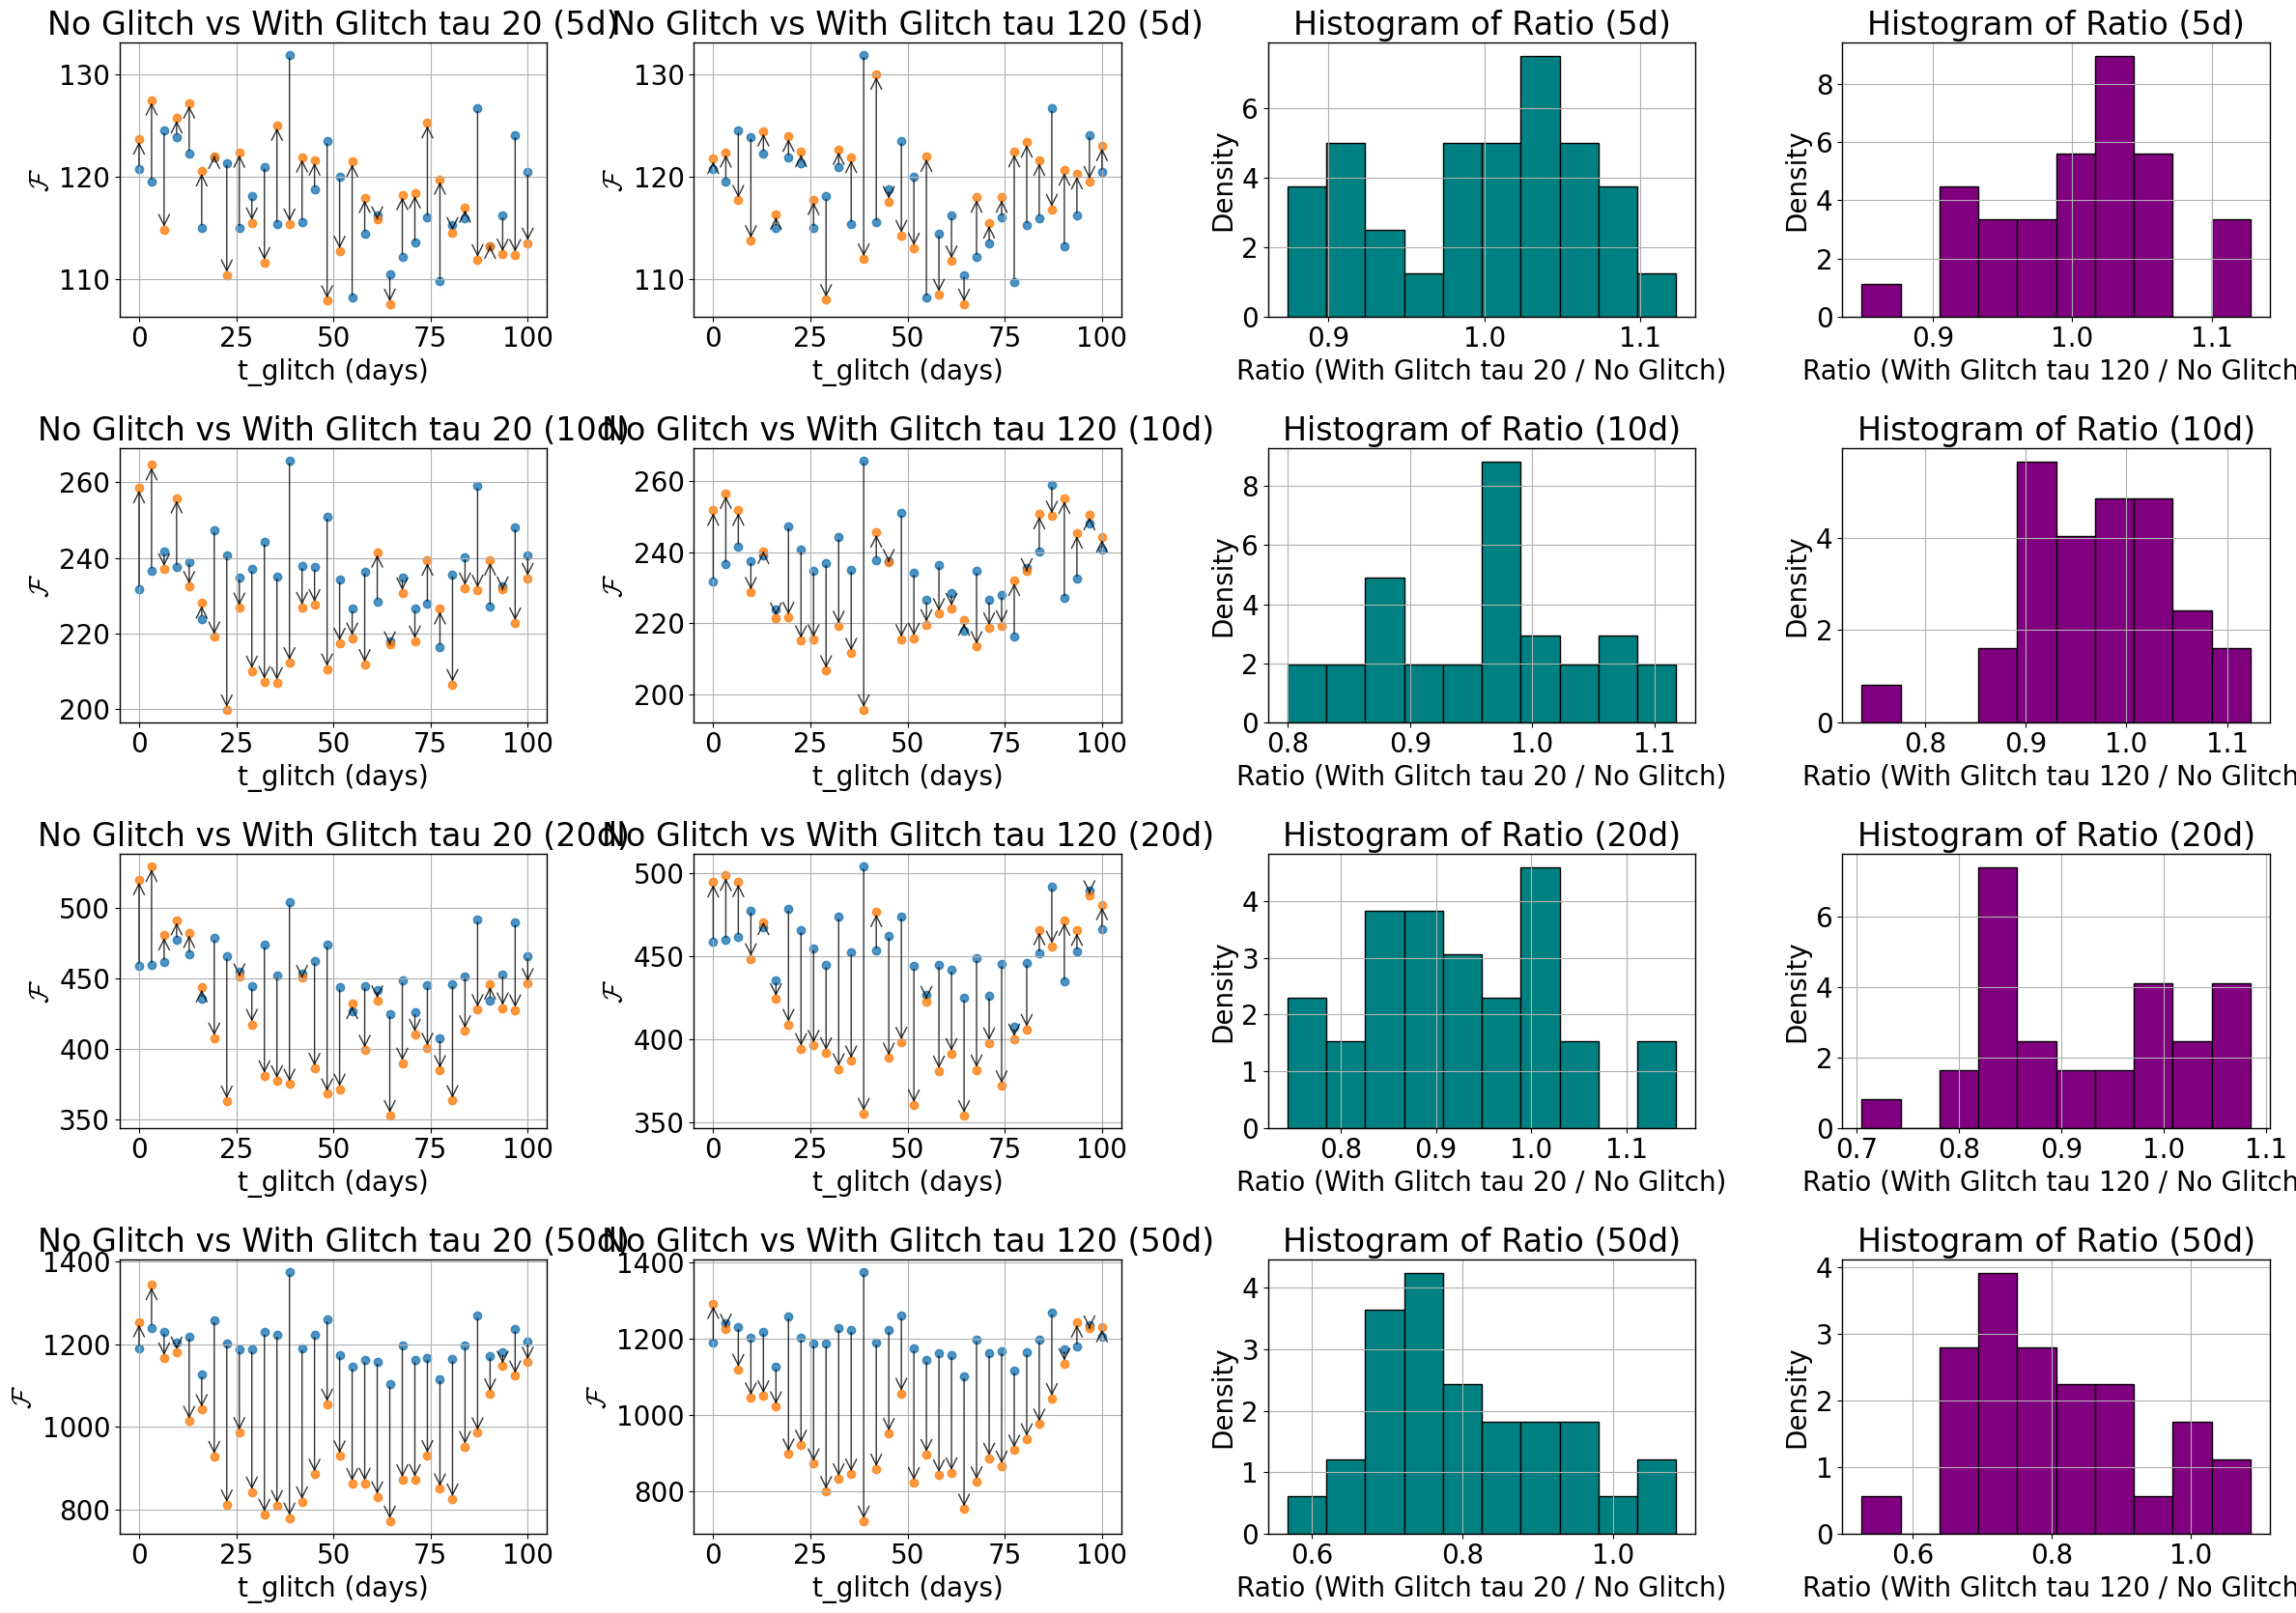

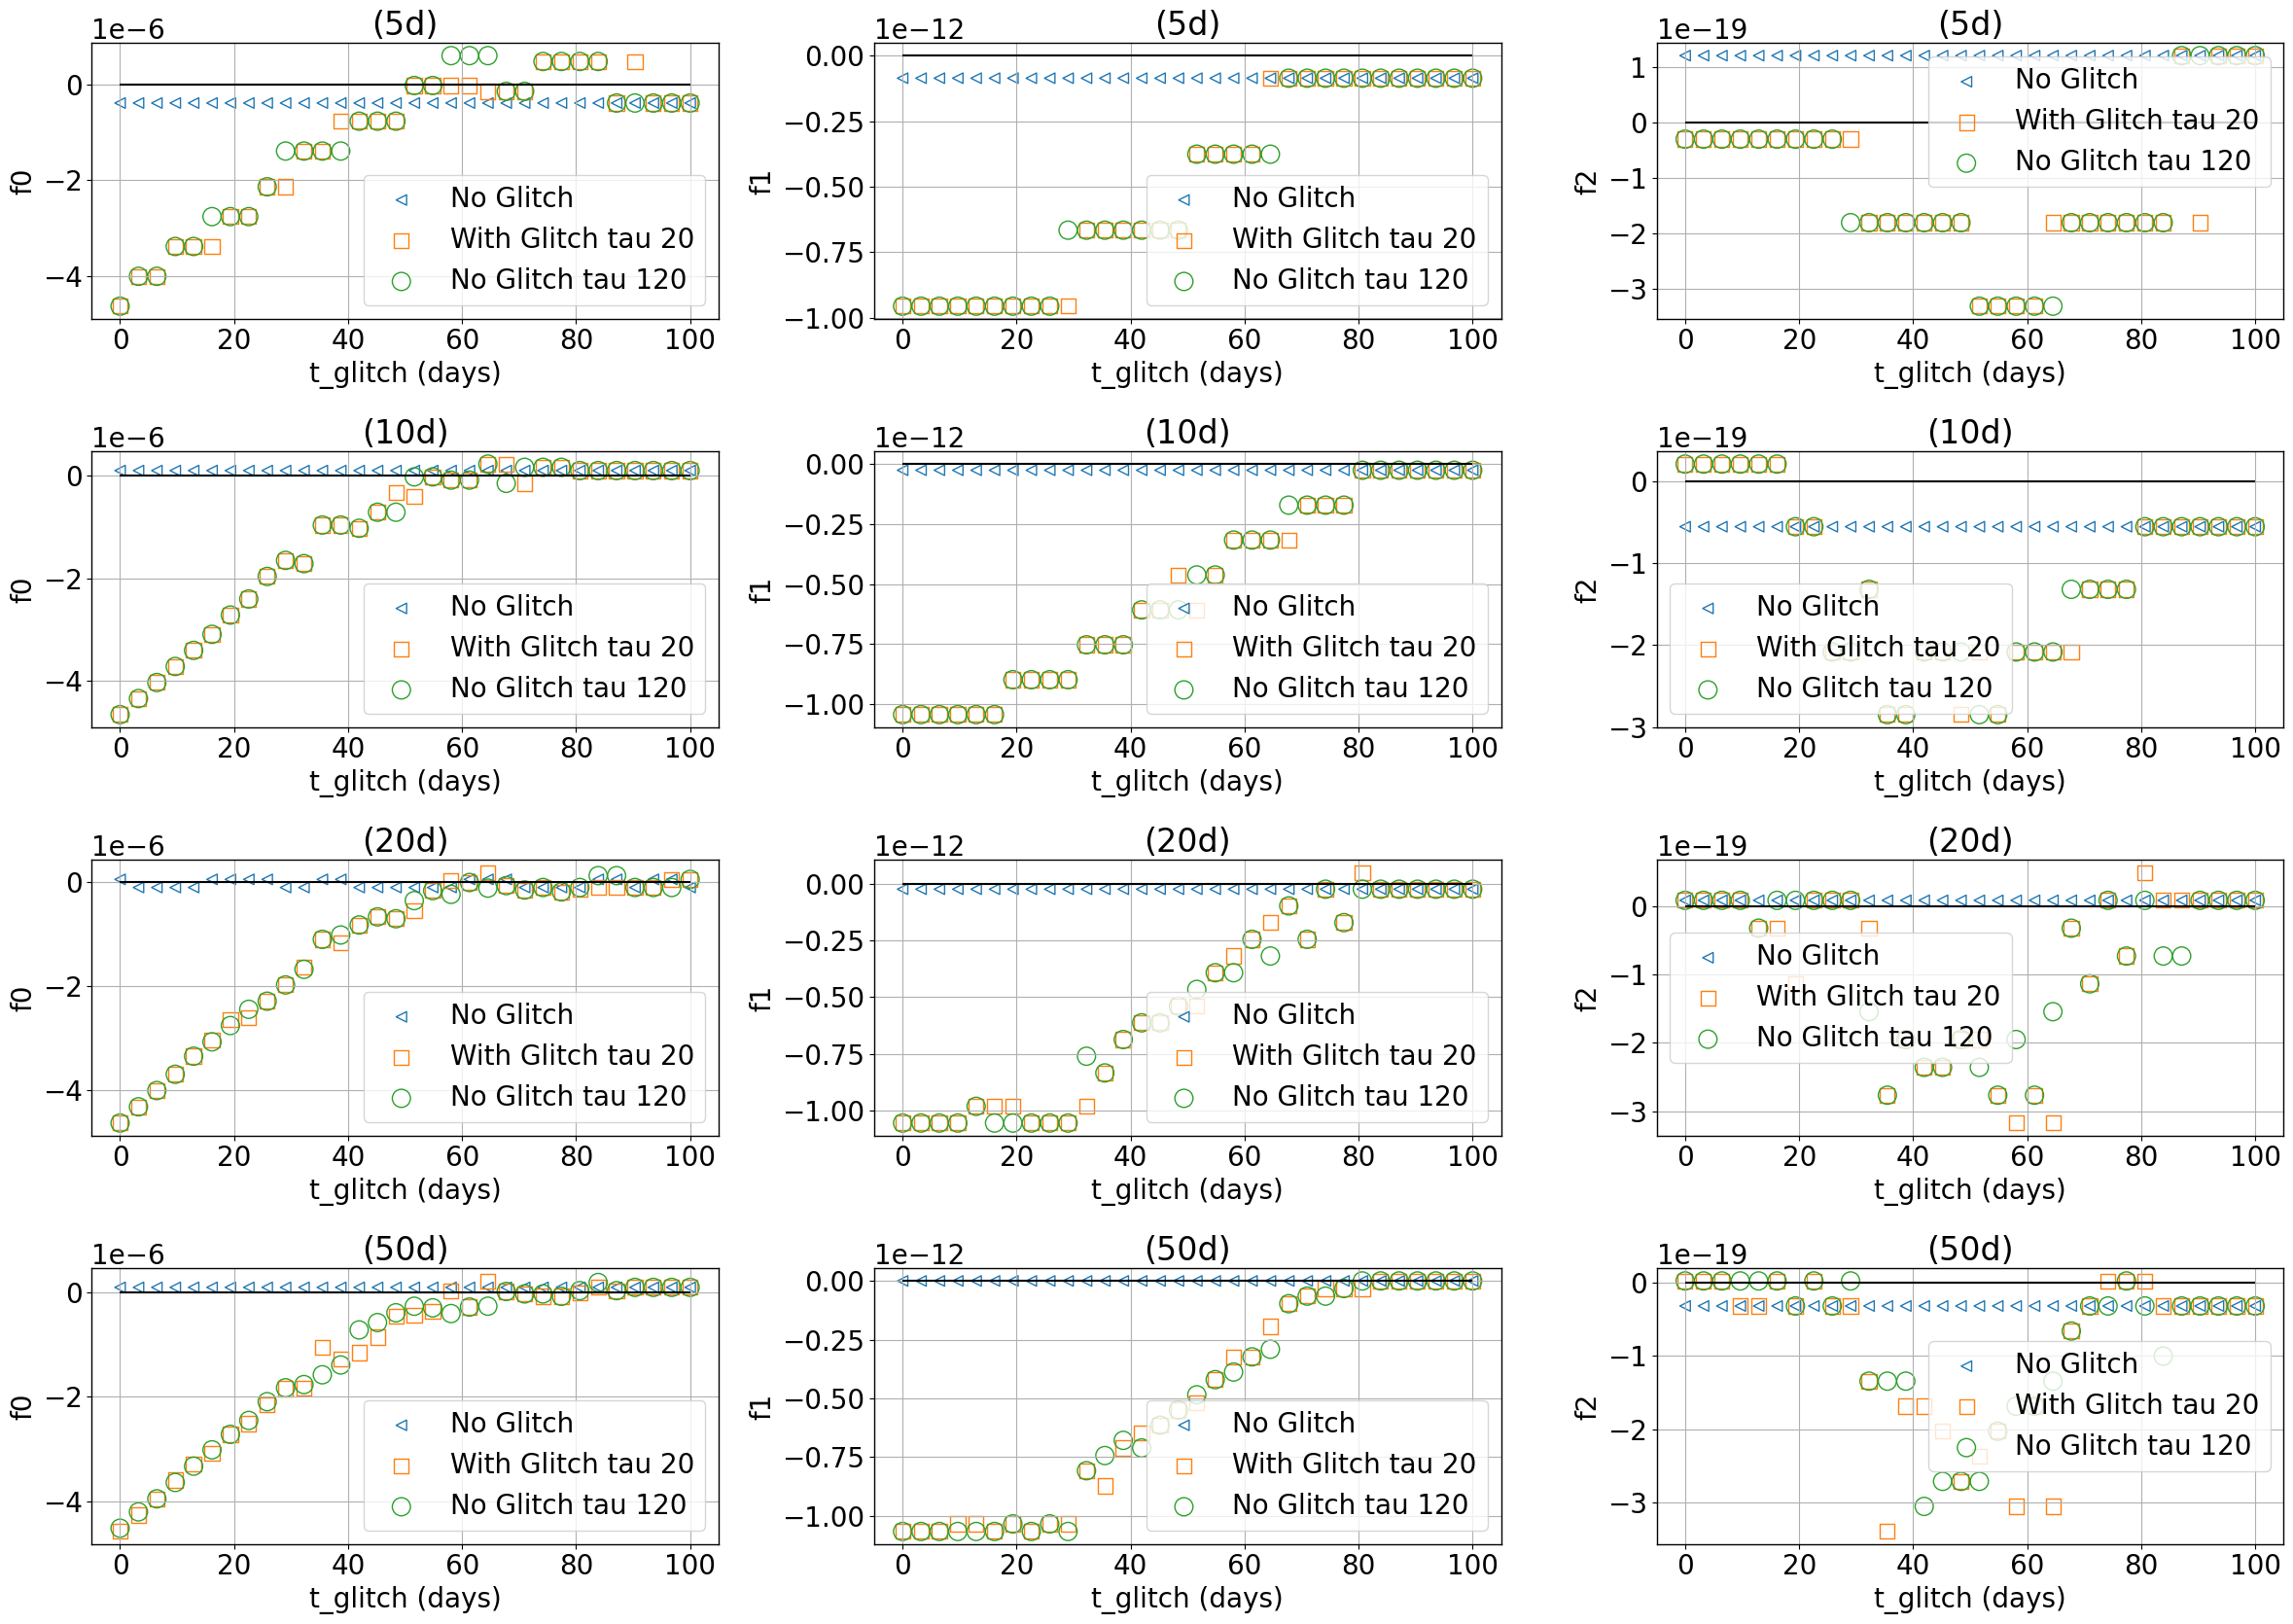

In [13]:
labels = ['no_glitch', 'with_glitch_onlytglitch', 'with_glitch_onlytglitch_tau120']
plot_labels = ['No Glitch', 'With Glitch tau 20', 'With Glitch tau 120']
plot_glitch_analysis(labels, plot_labels)

plot_bias(
    labels=['no_glitch', 'with_glitch_onlytglitch', 'with_glitch_onlytglitch_tau120'],
    plot_labels=['No Glitch', 'With Glitch tau 20', 'No Glitch tau 120']
)


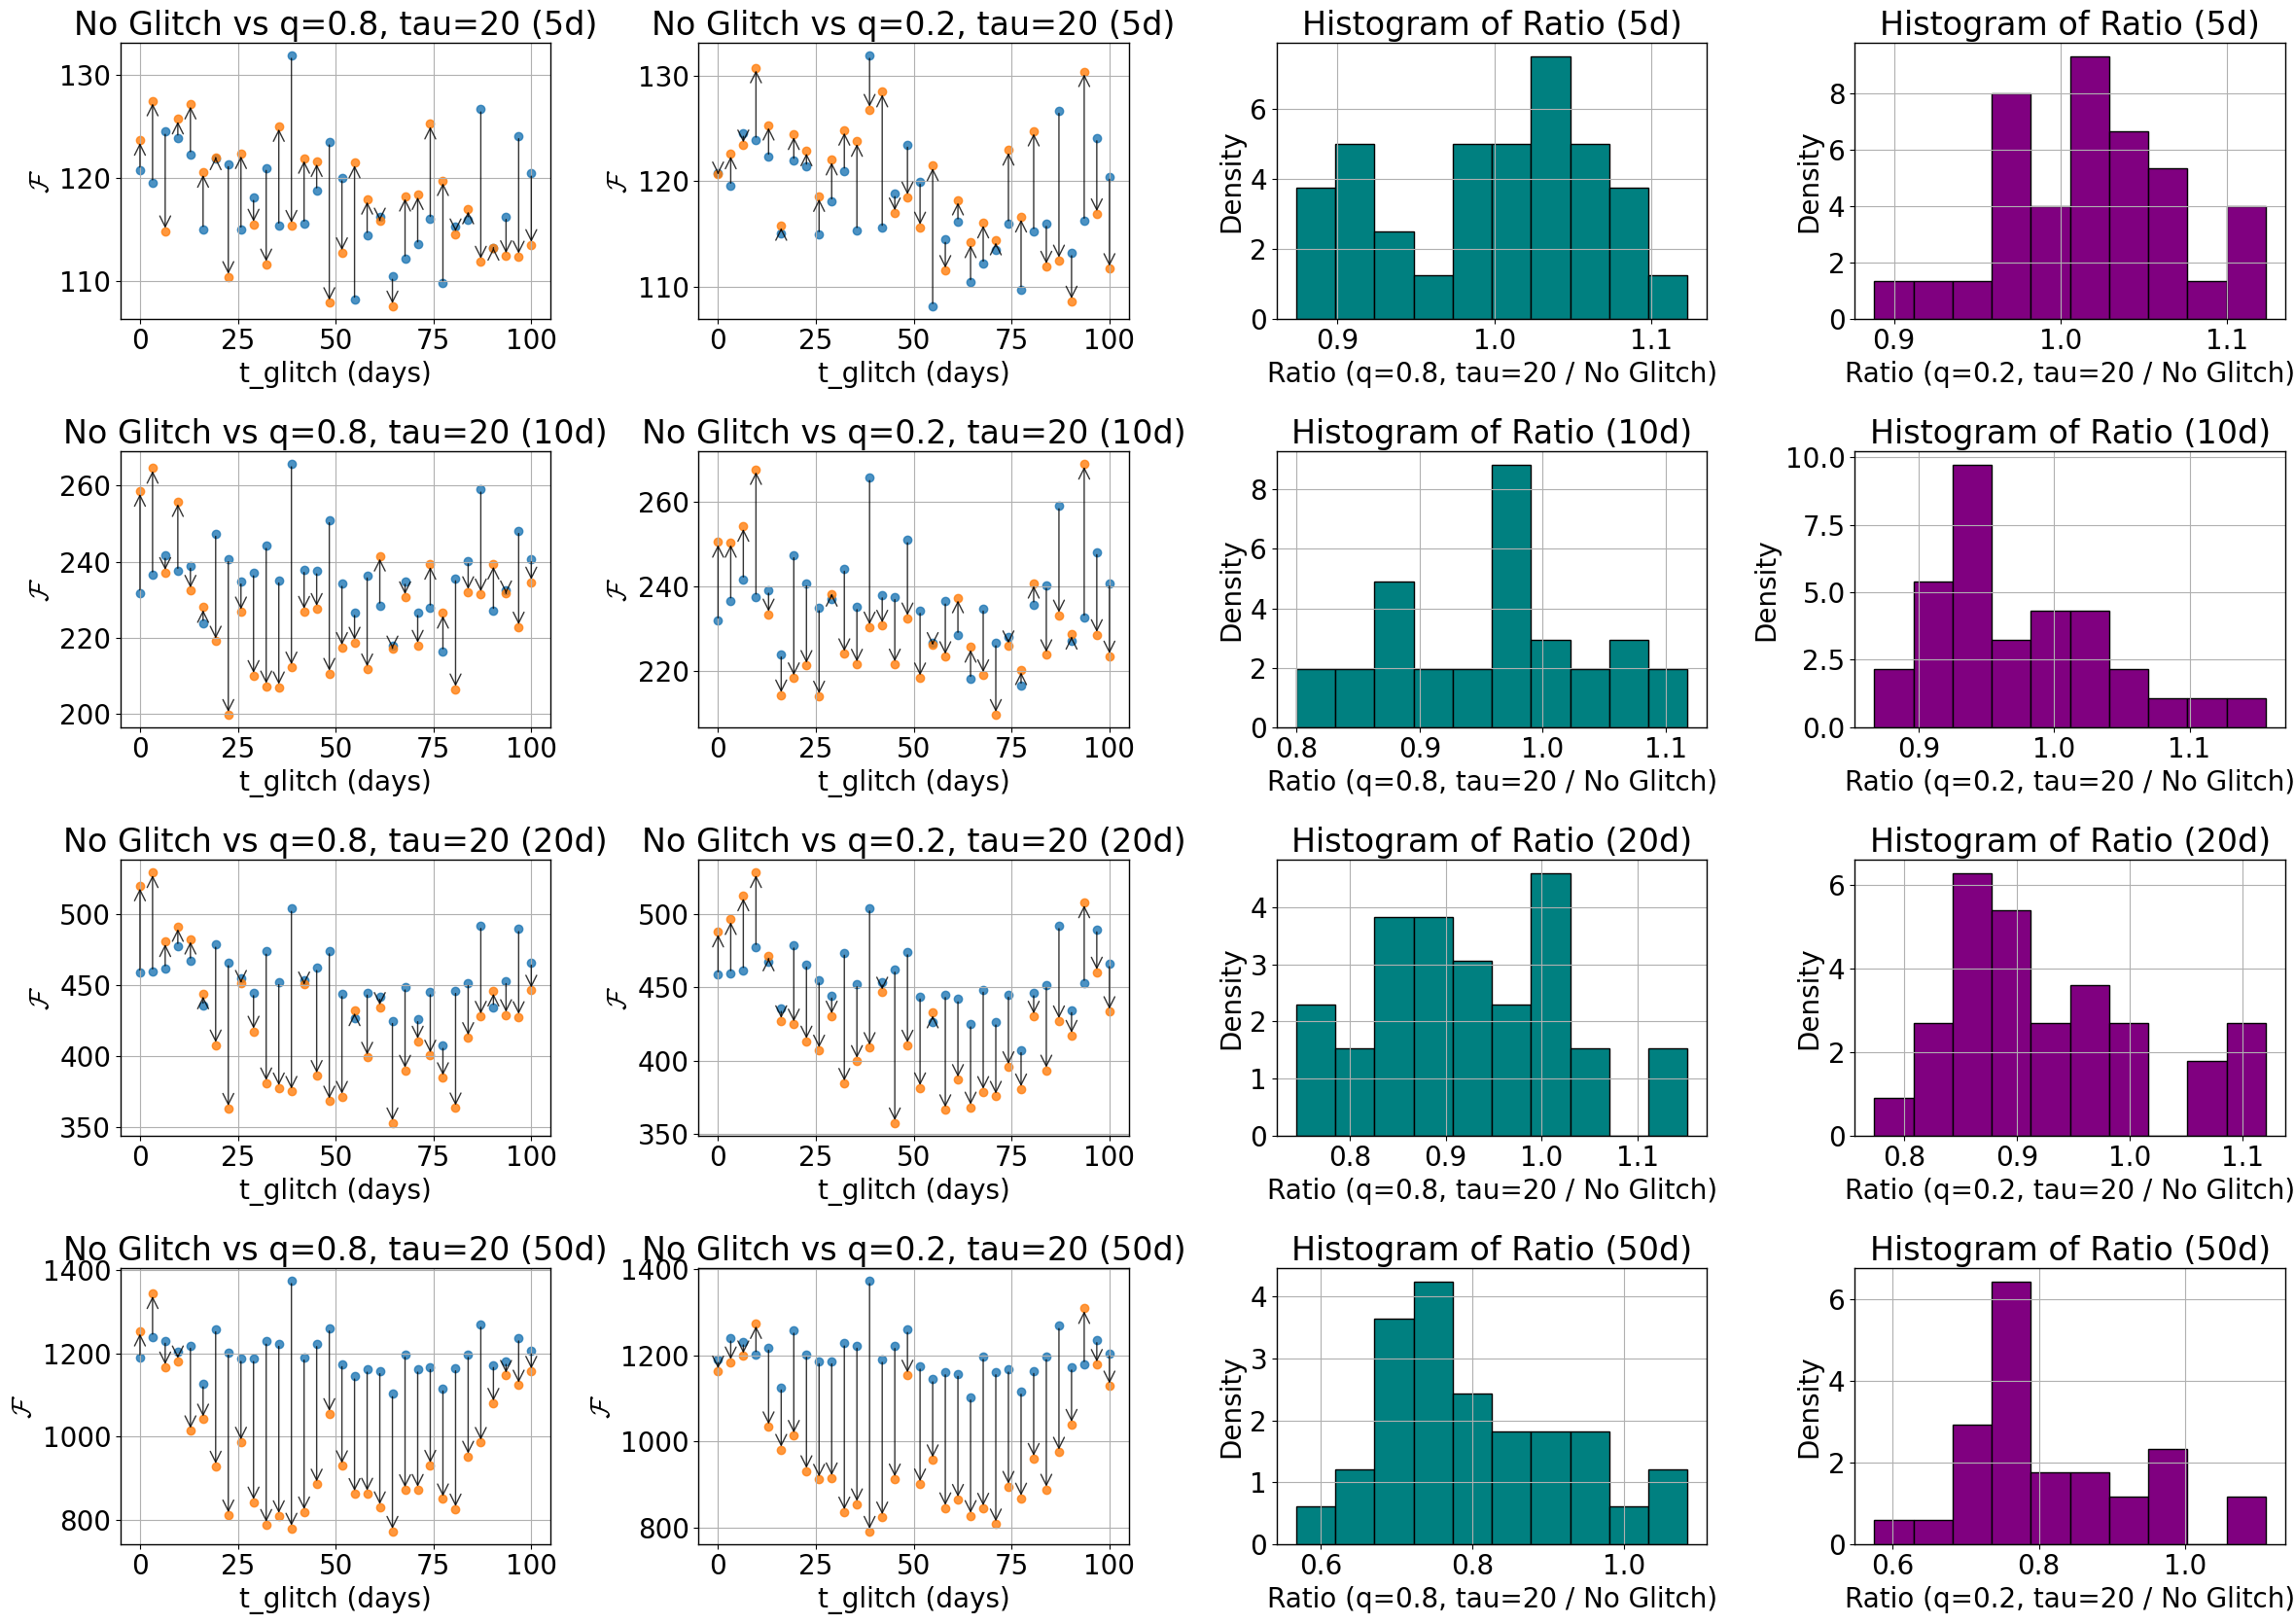

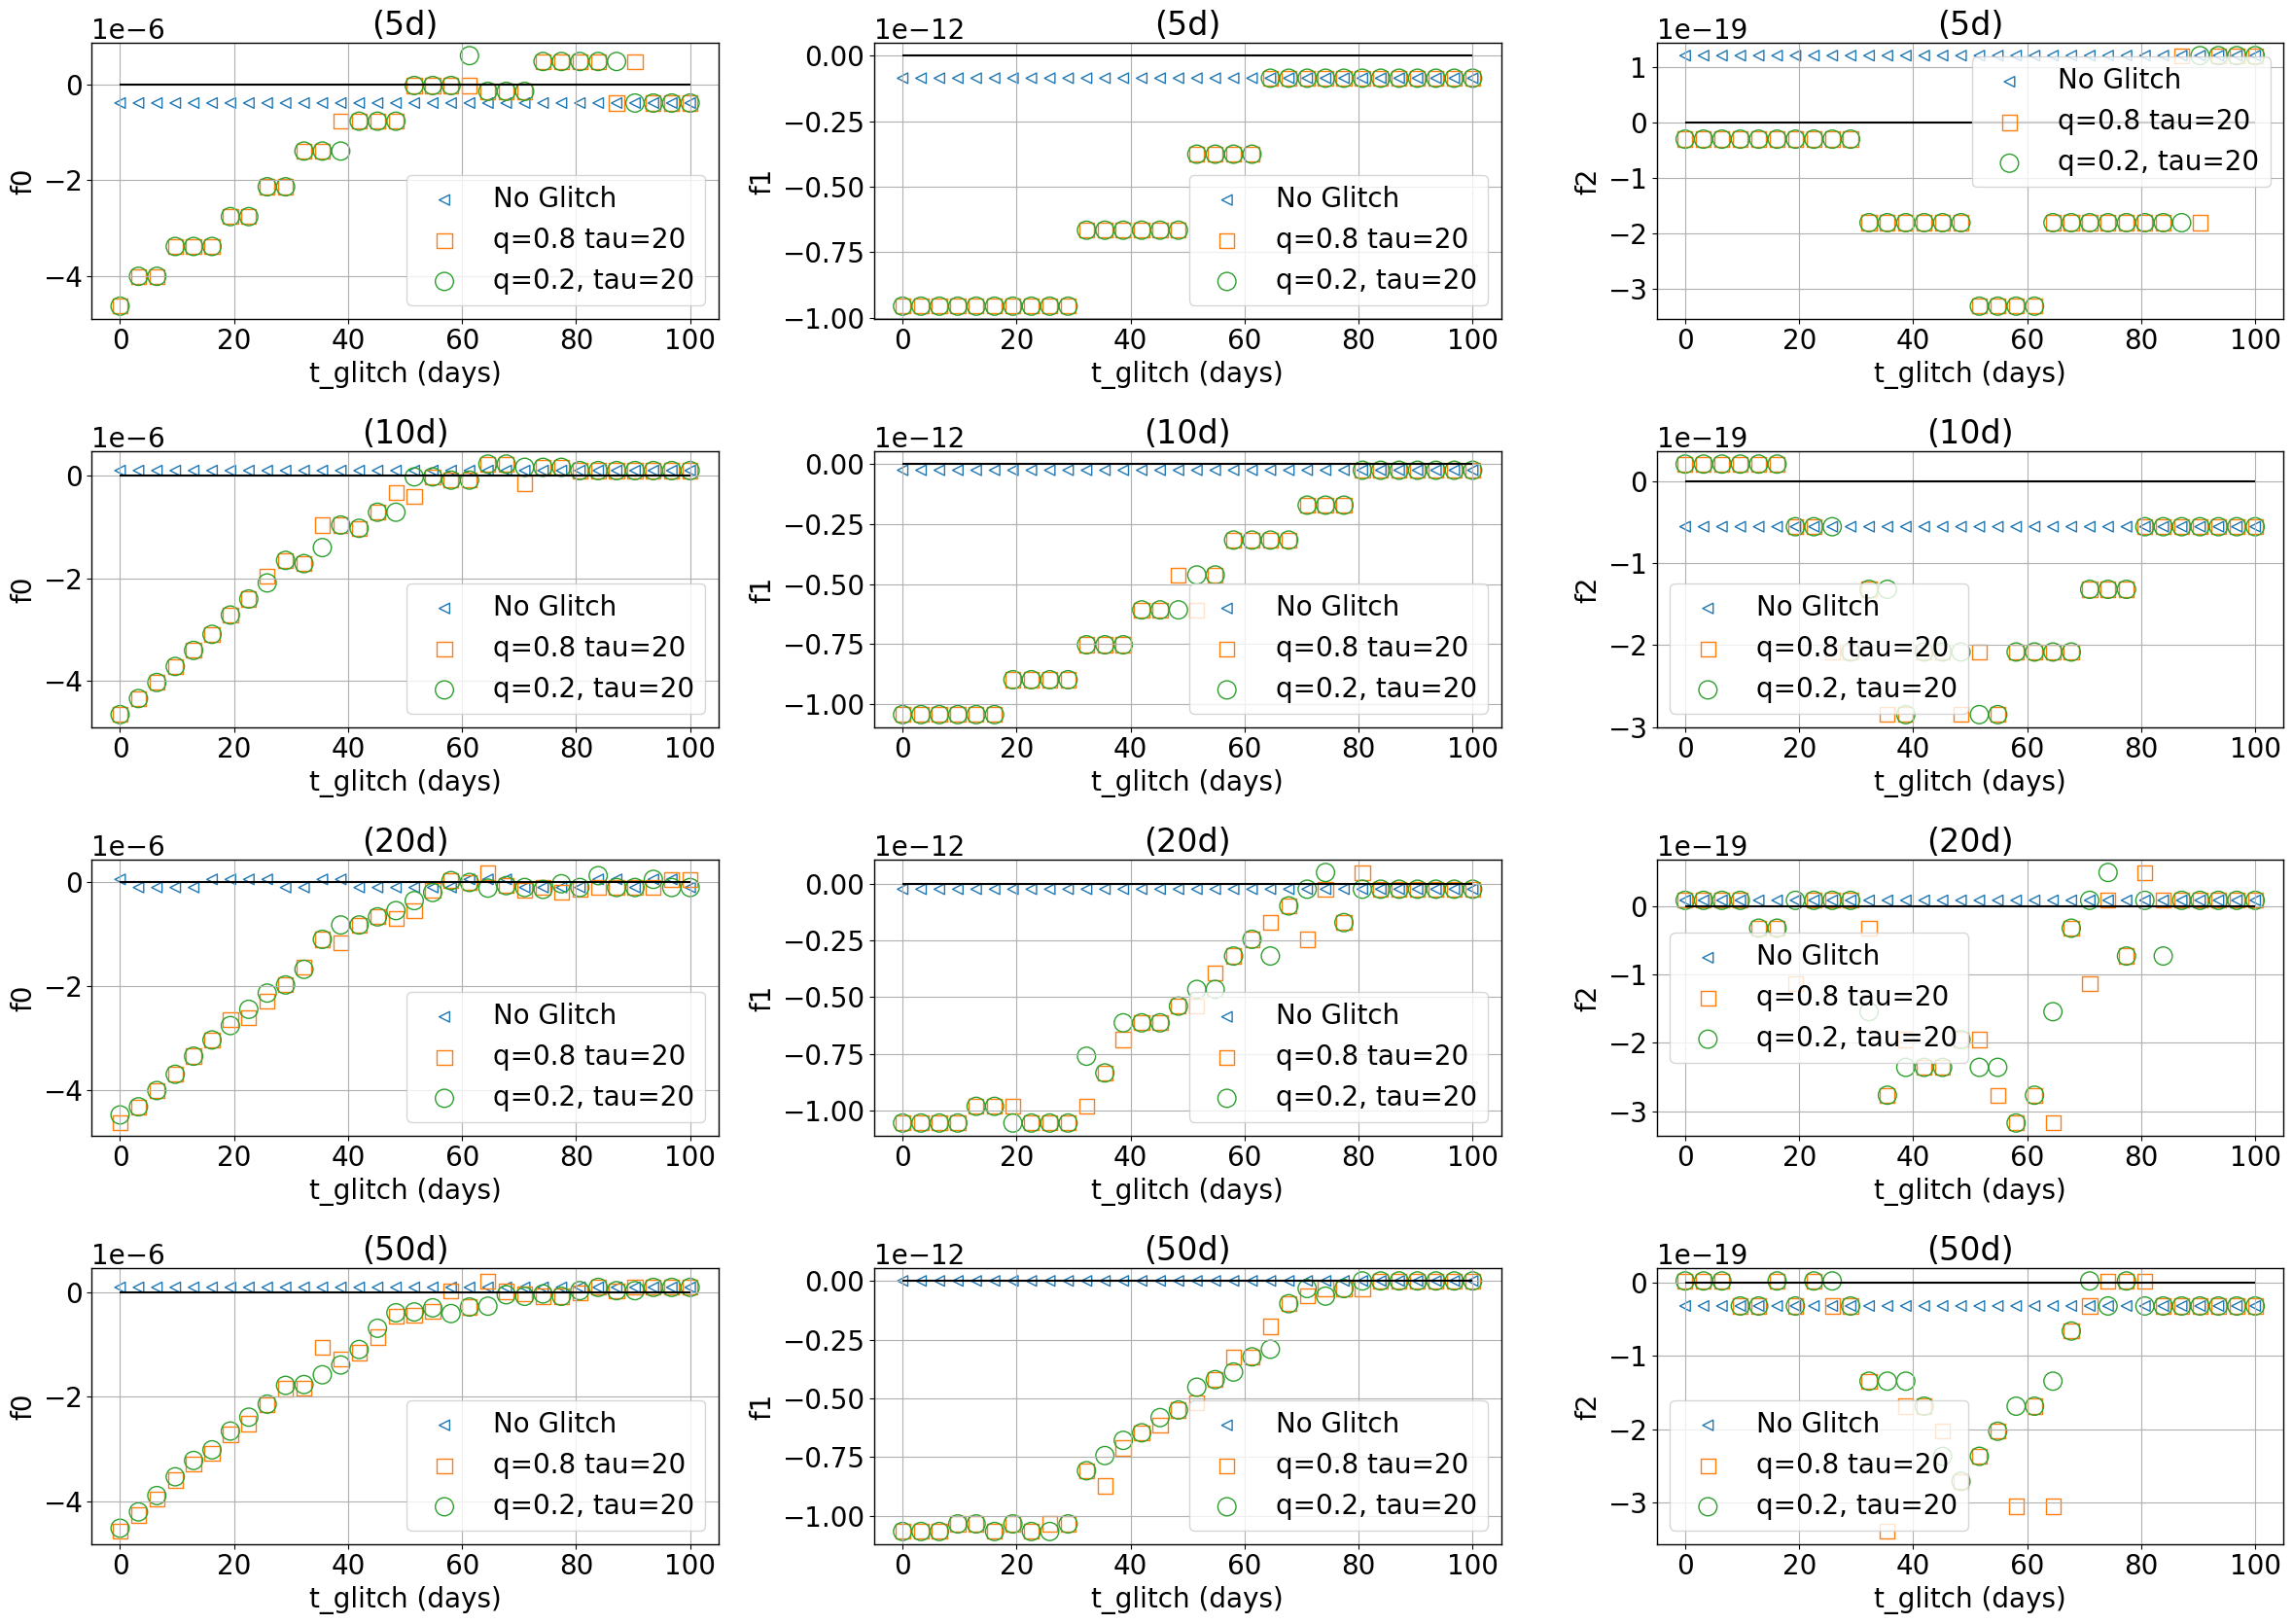

In [16]:
labels = ['no_glitch', 'with_glitch_onlytglitch', 'with_glitch_onlytglitch_q0.2_tau20']
plot_labels = ['No Glitch', 'q=0.8, tau=20', 'q=0.2, tau=20']
plot_glitch_analysis(labels, plot_labels)

plot_bias(
    labels=['no_glitch', 'with_glitch_onlytglitch', 'with_glitch_onlytglitch_q0.2_tau20'],
    plot_labels=['No Glitch', 'q=0.8 tau=20', 'q=0.2, tau=20']
)


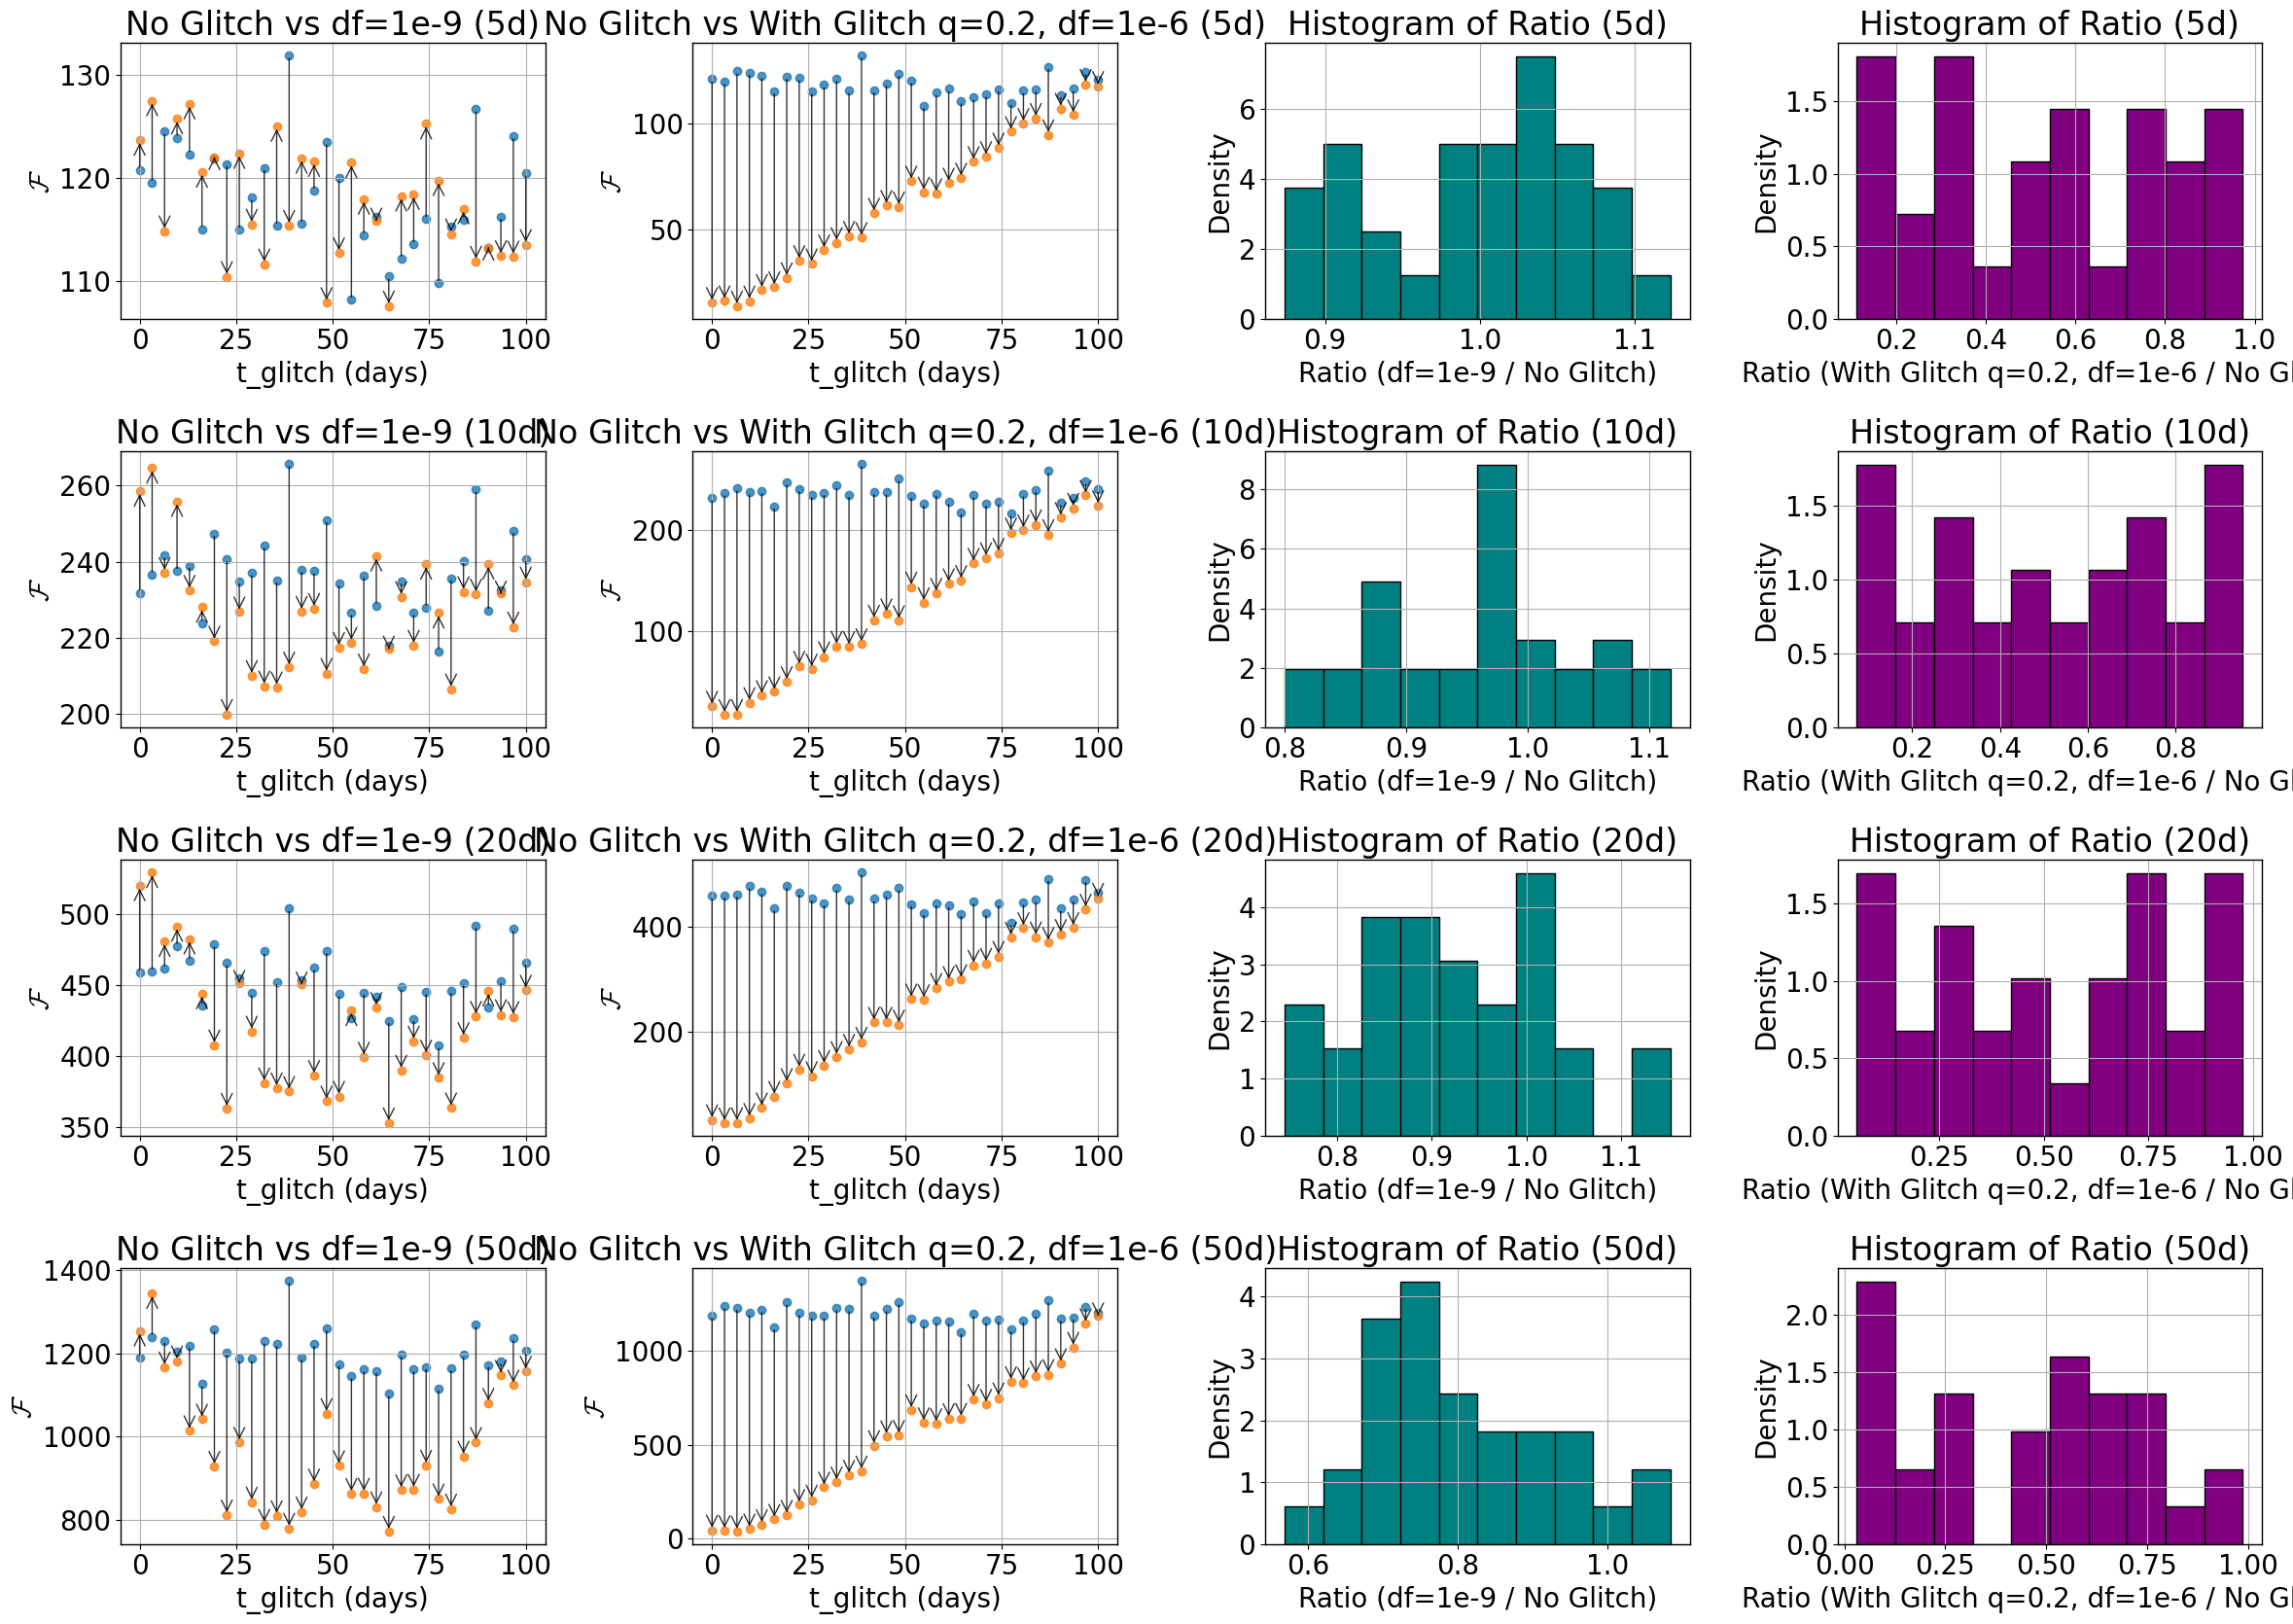

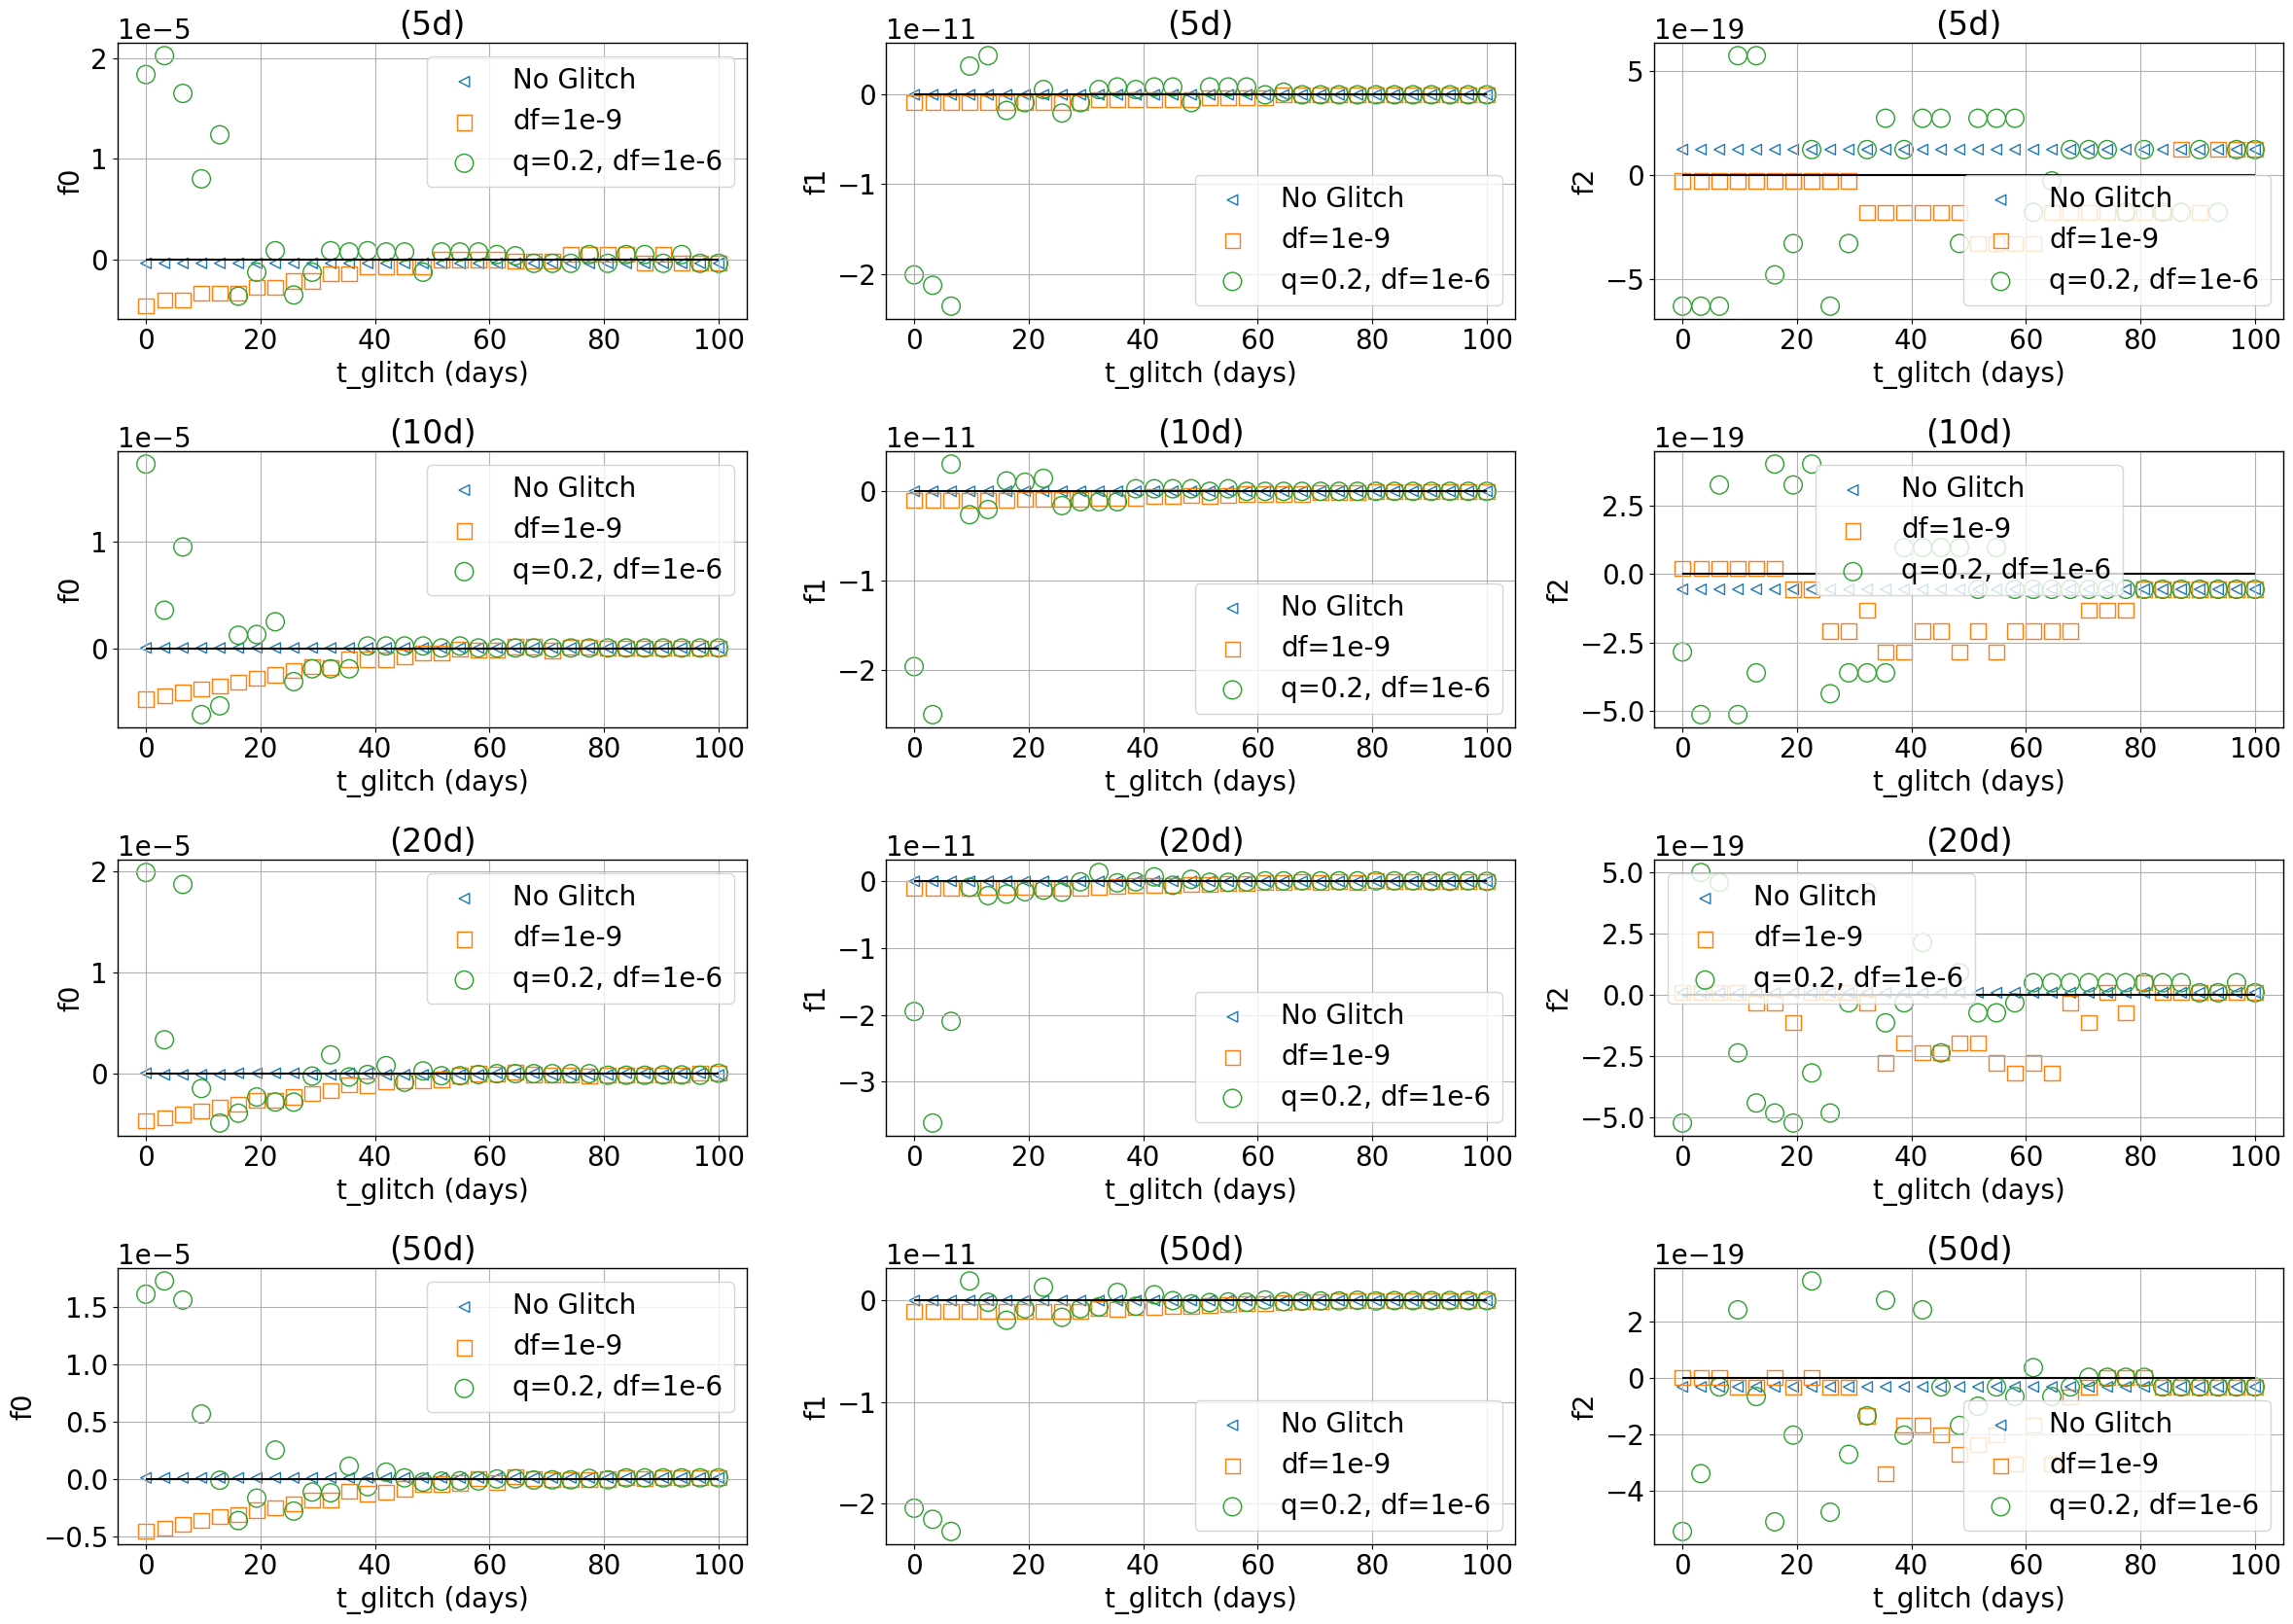

In [17]:
labels = ['no_glitch', 'with_glitch_onlytglitch', 'with_glitch_onlytglitch_df1e-6_q0.2_tau20']
plot_labels = ['No Glitch', 'df=1e-9', 'With Glitch q=0.2, df=1e-6']
plot_glitch_analysis(labels, plot_labels)

plot_bias(
    labels=['no_glitch', 'with_glitch_onlytglitch', 'with_glitch_onlytglitch_df1e-6_q0.2_tau20'],
    plot_labels=['No Glitch', 'df=1e-9', 'q=0.2, df=1e-6']
)
